# 1. Install & Import Dependencies

In [1]:
!pip install jcopml -q
!pip install ipython-autotime -q
!pip uninstall imbalanced-learn scikit-learn -y -q
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3 -q

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 74.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 11.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [2]:
%load_ext autotime

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import sklearn
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import jcopml
from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.plot import plot_missing_value, plot_classification_report, plot_confusion_matrix, plot_correlation_matrix, plot_association_matrix, plot_correlation_ratio, plot_roc_curve, plot_pr_curve
from jcopml.tuning import grid_search_params as gsp
from jcopml.automl import AutoClassifier
from jcopml.feature_importance import mean_score_decrease, mean_loss_decrease
from jcopml.utils import save_model, load_model

from IPython.core.interactiveshell import InteractiveShell

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:,.2f}'.format)
InteractiveShell.ast_node_interactivity = "all"

time: 2.08 s (started: 2025-10-28 14:15:40 +00:00)


# 2. Dataset

In [3]:
df = pd.read_excel('/kaggle/input/Data.xlsx', parse_dates=['Tgl Lahir', 'Tanggal Pengukuran'])
df.head(1)
df.tail(1)

No               NIK                    Nama JK  Tgl Lahir  BB Lahir  \
0   1  3314010911170002  NAUFAL ARFAN PRADYASTA  L 2019-11-09      2.80   

   TB Lahir   Nama Ortu         Prov    Kab/Kota        Kec   Pukesmas  \
0      0.00  TRI PAMONO  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   

  Desa/Kel         Posyandu   RT   RW       Alamat  \
0  BANARAN  WARGO LESTARI 9  NaN  NaN  DUKUHRAMBAT   

                Usia Saat Ukur Tanggal Pengukuran  Berat Tinggi Cara Ukur  \
0  4 Tahun - 10 Bulan - 4 Hari         2024-09-13  18.20    113   Berdiri   

   LiLA                BB/U  ZS BB/U    TB/U ZS TB/U   BB/TB ZS BB/TB  \
0   NaN  Berat Badan Normal     0.07  Normal    0.89  Normal    -0.85   

  Naik Berat Badan PMT Diterima (kg)  Jml Vit A KPSP KIA Detail  
0                N                 -        NaN    -   -

No               NIK             Nama JK  Tgl Lahir  BB Lahir  \
3128  3129  3314100309222075  ASAKHA H AMIRUL  L 2022-09-03      3.00   

      TB Lahir Nama Ortu         Prov    Kab/Kota        Kec   Pukesmas  \
3128     49.00      nita  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   

     Desa/Kel        Posyandu RT   RW      Alamat  \
3128  BUKURAN  NGUDI RAHAYU 1  3  NaN  ngargorejo   

                    Usia Saat Ukur Tanggal Pengukuran  Berat Tinggi Cara Ukur  \
3128  1 Tahun - 11 Bulan - 28 Hari         2024-09-01   8.40     79   Berdiri   

      LiLA           BB/U  ZS BB/U    TB/U ZS TB/U        BB/TB ZS BB/TB  \
3128  0.00  Sangat Kurang    -3.22  Pendek   -2.64  Gizi Kurang    -2.66   

     Naik Berat Badan PMT Diterima (kg)  Jml Vit A KPSP KIA Detail  
3128                O                 -        NaN    -   -

time: 2.9 s (started: 2025-10-28 14:15:42 +00:00)


# 3. Exploratory Data Analysis (EDA) + Feature Engineering

## 3.1. Simple EDA

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3129 entries, 0 to 3128
Data columns (total 35 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   No                  3129 non-null   int64         
 1   NIK                 3129 non-null   int64         
 2   Nama                3129 non-null   object        
 3   JK                  3129 non-null   object        
 4   Tgl Lahir           3129 non-null   datetime64[ns]
 5   BB Lahir            3129 non-null   float64       
 6   TB Lahir            3012 non-null   float64       
 7   Nama Ortu           3127 non-null   object        
 8   Prov                3129 non-null   object        
 9   Kab/Kota            3129 non-null   object        
 10  Kec                 3129 non-null   object        
 11  Pukesmas            3129 non-null   object        
 12  Desa/Kel            3129 non-null   object        
 13  Posyandu            3125 non-null   object      

**<span style="color:#e352d7">Findings:</span>**
* Terdapat 3129 baris dan 35 kolom data
* Kesalahan tipe data pada kolom "Tinggi", "ZS TB/U", "ZS BB/TB", & "PMT Diterima (kg)"

### 3.1.1. Change Wrong Data Type

##### Tinggi

In [5]:
df.Tinggi.unique()

array([113, 107, 103, 102.5, 108.2, 108.5, 102.2, 95.5, 104, 105.8, 101.5,
       102, 112.5, 106.4, 101.6, 100.6, 105.5, 103.6, 99.9, 109, 106, 101,
       109.5, 95.6, 103.1, 100.4, 104.6, 110.3, 104.5, 110, 105, 99.7,
       100.5, 98, 99, 100, 99.2, 106.5, 102.7, 103.7, 97.8, 105.2, 105.6,
       95, 97.5, 108, 98.5, 102.8, 103.2, 99.5, 98.3, 97.7, 96.5, 97,
       103.5, 99.6, 99.1, 101.8, 102.3, 91.4, 91.7, 94, 96, 97.6, 99.3,
       94.5, 111, 107.5, 96.4, 102.1, 93.3, 97.1, 101.7, 100.2, 98.2,
       97.2, 98.9, 96.3, 98.1, 92, 93.4, 98.7, 93, 96.2, 102.9, 98.4,
       96.7, 100.8, 112, 98.8, 95.1, 92.9, 104.3, 101.1, 95.3, 90.5, 95.7,
       95.8, 104.8, 95.4, 97.3, 93.1, 93.5, 88.5, 92.2, 94.6, 94.2, 92.5,
       90, 97.4, 94.7, 86, 96.6, 100.3, 89.8, 91.5, 91, 48, 89.6, 92.6,
       86.6, 87.2, 89, 94.1, 101.4, 93.8, 90.3, 90.1, 85, 87, 94.4, 87.5,
       88, 85.5, 114.5, 91.3, 93.9, 89.5, 88.1, 92.7, 92.3, 96.1, 95.2,
       101.3, 90.4, 107.3, 88.3, 91.2, 86.5, 87.4, 92.1,

time: 14.6 ms (started: 2025-10-28 14:15:45 +00:00)


In [6]:
df["Tinggi"] = df["Tinggi"].replace("-", None).astype("float64")
print(df["Tinggi"].dtype)

float64
time: 14.3 ms (started: 2025-10-28 14:15:45 +00:00)


##### ZS TB/U

In [7]:
df['ZS TB/U'].unique()

array([0.89, -0.62, -1.19, -1.44, -0.35, -0.03, -1.1400000000000001,
       -2.91, -1.02, -0.56, -1.58, -1.49, 0.73, -0.53, -1.4,
       -1.8199999999999998, -0.75, -0.94, -1.23, -1.81, -0.2, -0.72,
       -0.74, -1.62, -1.36, 0.43, -1.12, -1.22, -2.7, -1.8, -0.5, 0.69,
       -0.78, 0.25, -1, -1.79, -1.15, -1.33, -1.51, -1.07, -1.05, -2.15,
       -1.17, -1.77, -1.99, 0.34, -0.88, -1.5699999999999998, -1.31, -1.6,
       -1.11, 0.63, -1.37, -0.66, -2.35, -0.25, -0.05, -2.31, -0.92, 0.08,
       -0.22, -1.85, -0.28, -0.91, -1.25, -1.66, -1.45, 0.3, -1.86, -0.29,
       -1.59, -1.72, -1.9300000000000002, -0.9, -0.7, -1.87, -0.48, -1.5,
       0.6, -0.18, -0.65, -1.67, -0.37, -2.94, -2.2800000000000002, -0.42,
       -1.89, -2.39, 0.82, -1.16, -1.01, -1.7, -1.83, -0.32, 0.05, -2.34,
       -0.57, -2.29, -1.91, -1.53, -1.34, 0.19, -0.27, -0.45, -0.23, 0.41,
       -0.97, 0.76, -1.56, -1.18, -1.6800000000000002, -1.84, -1.9, 0.09,
       0.52, -1.39, -0.98, -1.42, 0.26, -1.78, -1.98, -0.63

time: 17.9 ms (started: 2025-10-28 14:15:45 +00:00)


In [8]:
df["ZS TB/U"] = df["ZS TB/U"].replace("-", None).astype("float64")
print(df["ZS TB/U"].dtype)

float64
time: 12.9 ms (started: 2025-10-28 14:15:45 +00:00)


##### ZS BB/TB

In [9]:
df['ZS BB/TB'].unique()

array([-0.85, 0.2, -0.58, 0.74, -2.86, 0.8, -1.17, -0.16, -0.7, -0.21,
       -0.78, 0.59, -1.04, 0.34, -0.14, 0.75, -0.72, -0.36, 0.21, 0.17,
       -1.61, -0.37, -1.37, -1.5, -0.54, -1.79, -0.5, -1.23, -1.06, -0.66,
       -1.58, -0.96, 0.22, -0.03, -0.22, -0.63, 0.16, 0.13, -0.95, -0.44,
       -0.39, 1.94, -0.92, 1.99, -0.62, -0.15, 0.6, -0.18, -0.1, -0.81,
       -0.31, 0.24, -0.41, -0.24, -0.48, 0.41, 0.82, -0.25, 0.5, -1.39,
       -0.57, 0.02, 1.76, -1.55, 0.91, 0.49, 0.11, -1.4, 0.33, 0.66,
       -1.15, 0.12, 1.23, 0.92, -1.65, -0.59, 0.46, -1.44, -0.29, -1.31,
       1.46, -0.34, -0.53, 1.38, -0.17, 0.76, 0.05, 0.36, -0.05, -0.88,
       0.9, 0.43, -0.23, -1.42, -0.52, -0.01, -0.68, 0.99, -0.35, 0.27,
       0.1, -0.32, 0.77, -0.64, 0.04, 0.55, 0.44, -0.82, 1.29, -1.07,
       -1.78, -0.49, 0.53, 1.25, -0.43, -0.77, -0.8, 0.31, -1.81, -0.69,
       0.64, -1.05, -1.01, 1.13, -0.79, 1.59, 0.37, -1.35, -0.94, 0.14,
       -1.76, 0.01, -0.3, -1.7, -2.01, -1.28, 0.57, 0.03, -1.67

time: 16.8 ms (started: 2025-10-28 14:15:45 +00:00)


In [10]:
df["ZS BB/TB"] = df["ZS BB/TB"].replace("-", None).astype("float64")
print(df["ZS BB/TB"].dtype)

float64
time: 13.2 ms (started: 2025-10-28 14:15:45 +00:00)


##### PMT Diterima (kg)

In [11]:
df['PMT Diterima (kg)'].unique()

array(['-', nan, 2.96], dtype=object)

time: 13.1 ms (started: 2025-10-28 14:15:45 +00:00)


In [12]:
df["PMT Diterima (kg)"] = df["PMT Diterima (kg)"].replace("-", None).astype("float64")
print(df["PMT Diterima (kg)"].dtype)

float64
time: 18.7 ms (started: 2025-10-28 14:15:45 +00:00)


In [13]:
df.dtypes

No                             int64
NIK                            int64
Nama                          object
JK                            object
Tgl Lahir             datetime64[ns]
BB Lahir                     float64
TB Lahir                     float64
Nama Ortu                     object
Prov                          object
Kab/Kota                      object
Kec                           object
Pukesmas                      object
Desa/Kel                      object
Posyandu                      object
RT                            object
RW                            object
Alamat                        object
Usia Saat Ukur                object
Tanggal Pengukuran    datetime64[ns]
Berat                        float64
Tinggi                       float64
Cara Ukur                     object
LiLA                         float64
BB/U                          object
ZS BB/U                      float64
TB/U                          object
ZS TB/U                      float64
B

time: 16.4 ms (started: 2025-10-28 14:15:45 +00:00)


### 3.1.2. Check unique data

In [14]:
df.nunique()

No                    3129
NIK                   2710
Nama                  2679
JK                       2
Tgl Lahir             1408
BB Lahir               138
TB Lahir                51
Nama Ortu             2452
Prov                     1
Kab/Kota                 1
Kec                      1
Pukesmas                 1
Desa/Kel                14
Posyandu                90
RT                      56
RW                      15
Alamat                 727
Usia Saat Ukur        1383
Tanggal Pengukuran      20
Berat                  218
Tinggi                 394
Cara Ukur                2
LiLA                    68
BB/U                     4
ZS BB/U                409
TB/U                     4
ZS TB/U                491
BB/TB                    7
ZS BB/TB               456
Naik Berat Badan         4
PMT Diterima (kg)        1
Jml Vit A                1
KPSP                     1
KIA                      1
Detail                   1
dtype: int64

time: 31.4 ms (started: 2025-10-28 14:15:45 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 3129 unique data pada kolom "No", 2710 unique data pada kolom "NIK", & 2769 unique data pada kolom "Nama" sehingga dapat mengindikasikan terdapat data yang duplikat maupun anomaali antara "nama" dan "NIK"
* Terdapat beberapa kolom yang memiliki 1 unique data yang bisajadi tidak diperlukan dalam proses analisis dan pemodelan, akan tetapi sebaiknya dilakukan pengecekan untuk kolom-kolom tersebut

In [15]:
print("Prov:")
print(df['Prov'].unique(), '\n')
print("Kab/Kota:")
print(df['Kab/Kota'].unique(), '\n')
print("Kec:")
print(df['Kec'].unique(), '\n')
print("Puskesmas:")
print(df['Pukesmas'].unique(), '\n')
print("PMT Diterima (kg):")
print(df['PMT Diterima (kg)'].unique(), '\n')
print("Jml Vit A:")
print(df['Jml Vit A'].unique(), '\n')
print("KPSP:")
print(df['KPSP'].unique(), '\n')
print("KIA:")
print(df['KIA'].unique(), '\n')
print("Detail:")
print(df['Detail'].unique(), '\n')

Prov:
['JAWA TENGAH'] 

Kab/Kota:
['KAB SRAGEN'] 

Kec:
['KALIJAMBE'] 

Puskesmas:
['KALIJAMBE'] 

PMT Diterima (kg):
[ nan 2.96] 

Jml Vit A:
[nan  1.] 

KPSP:
['-' nan] 

KIA:
['-' nan] 

Detail:
['   '] 

time: 9.56 ms (started: 2025-10-28 14:15:45 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Kolom "Prov", "Kab/Kota", "Kec", "Puskesmas", "KPSP", "KIA", dan "Detail" tidak dapat digunakan untuk analisis dan pemodelan
* Kolom "PMT Diterima (kg)" dan "Jml Vit A" dapat digunakan dengan syarat dilakukan impute value pada tahapan preprocessing

### 3.1.3. Descriptive Analysis

### 3.1.3.1. Numeric

In [16]:
df.describe(include=['int64', 'float64']).T

count                     mean                    std  \
No                3,129.00                 1,565.00                 903.41   
NIK               3,129.00 3,179,889,987,751,179.50 638,779,038,976,527.75   
BB Lahir          3,129.00                    95.57                 516.41   
TB Lahir          3,012.00                    43.89                  14.81   
Berat             3,129.00                    11.36                   3.15   
Tinggi            3,128.00                    85.71                  12.60   
LiLA              2,746.00                     9.55                   8.93   
ZS BB/U           3,129.00                    -1.13                   1.12   
ZS TB/U           3,128.00                    -1.34                   1.11   
ZS BB/TB          3,128.00                     0.42                  31.01   
PMT Diterima (kg)     1.00                     2.96                    NaN   
Jml Vit A            23.00                     1.00                   0.00   

                         min                      25%  \
No                      1.00                   783.00   
NIK               115,556.00 3,314,011,907,230,001.00   
BB Lahir                0.00                     3.00   
TB Lahir                0.00                    48.00   
Berat                   2.00                     9.20   
Tinggi                 43.00                    77.00   
LiLA                    0.00                     0.00   
ZS BB/U                -4.58                    -1.77   
ZS TB/U               -12.61                    -2.01   
ZS BB/TB               -7.41                    -1.20   
PMT Diterima (kg)       2.96                     2.96   
Jml Vit A               1.00                     1.00   

                                       50%                      75%  \
No                                1,565.00                 2,347.00   
NIK               3,314,015,408,210,001.00 3,314,101,610,239,758.00   
BB Lahir                              3.00                     3.30   
TB Lahir                             49.00                    49.00   
Berat                                11.40                    13.50   
Tinggi                               87.00                    95.43   
LiLA                                 14.00                    16.00   
ZS BB/U                              -1.17                    -0.50   
ZS TB/U                              -1.40                    -0.67   
ZS BB/TB                             -0.58                     0.08   
PMT Diterima (kg)                     2.96                     2.96   
Jml Vit A                             1.00                     1.00   

                                       max  
No                                3,129.00  
NIK               4,430,999,887,600,001.00  
BB Lahir                          4,200.00  
TB Lahir                            106.00  
Berat                                62.00  
Tinggi                              115.00  
LiLA                                155.00  
ZS BB/U                              34.06  
ZS TB/U                               3.63  
ZS BB/TB                            999.99  
PMT Diterima (kg)                     2.96  
Jml Vit A                             1.00

time: 42.3 ms (started: 2025-10-28 14:15:45 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat Anomali BB Lahir yaitu nilai minimumnya 0
* Terdapat Anomali TB Lahir yaitu nilai minimumnya 0
* Terdapat Anomali LiLA yaitu nilai minimumnya 0

In [17]:
df[df['BB Lahir'] < 1]['BB Lahir'].value_counts()
df[df['TB Lahir'] < 1]['TB Lahir'].value_counts()
df[df['LiLA'] < 1]['LiLA'].value_counts()

BB Lahir
0.00    39
0.35     1
Name: count, dtype: int64

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in less
  return op(a, b)


TB Lahir
0.00    276
0.50      2
0.49      1
Name: count, dtype: int64

LiLA
0.00    1104
Name: count, dtype: int64

time: 24.2 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Fitur LiLA sepertinya perlu dilakukan pengecekan lebih lanjut karena memiliki banyak nilai 0
* BB Lahir dan TB Lahir dibawah angka 1 dapat dihapus

In [18]:
print('Sebelum mengubah 0 menjadi NaN')
df['LiLA'].nunique()
df['LiLA'].unique()

df["LiLA"] = df["LiLA"].replace(0, np.nan)
print(df["LiLA"].dtype)

df['LiLA'].nunique()
df['LiLA'].unique()

Sebelum mengubah 0 menjadi NaN


68

array([   nan,  19.  ,   0.  ,  16.  ,  18.  ,  17.  ,  15.  ,  13.  ,
        16.2 ,  14.  ,  51.5 ,  16.5 ,  17.5 ,  15.5 ,  20.  ,  16.4 ,
        13.5 ,  14.5 ,  13.6 ,  18.5 ,  16.7 ,  44.5 ,  43.  ,  15.2 ,
        14.4 ,  16.3 ,  21.  ,  15.1 ,  48.  ,  13.2 ,  18.7 ,  38.  ,
        42.  ,  50.  ,  12.  ,  15.4 ,  15.75,  14.2 ,  13.3 ,  14.6 ,
        14.7 ,  45.  ,  46.  ,  14.3 ,  44.  ,  41.  ,  15.7 ,  39.  ,
       155.  ,  13.7 ,  43.5 ,  14.8 ,  15.3 ,  14.1 ,  11.5 ,  15.8 ,
        14.9 ,  13.4 ,  40.  ,  13.8 ,  37.  ,  12.5 ,  37.5 ,  11.  ,
        13.1 ,   1.  ,  13.9 ,  11.3 ,  12.3 ])

float64


67

array([   nan,  19.  ,  16.  ,  18.  ,  17.  ,  15.  ,  13.  ,  16.2 ,
        14.  ,  51.5 ,  16.5 ,  17.5 ,  15.5 ,  20.  ,  16.4 ,  13.5 ,
        14.5 ,  13.6 ,  18.5 ,  16.7 ,  44.5 ,  43.  ,  15.2 ,  14.4 ,
        16.3 ,  21.  ,  15.1 ,  48.  ,  13.2 ,  18.7 ,  38.  ,  42.  ,
        50.  ,  12.  ,  15.4 ,  15.75,  14.2 ,  13.3 ,  14.6 ,  14.7 ,
        45.  ,  46.  ,  14.3 ,  44.  ,  41.  ,  15.7 ,  39.  , 155.  ,
        13.7 ,  43.5 ,  14.8 ,  15.3 ,  14.1 ,  11.5 ,  15.8 ,  14.9 ,
        13.4 ,  40.  ,  13.8 ,  37.  ,  12.5 ,  37.5 ,  11.  ,  13.1 ,
         1.  ,  13.9 ,  11.3 ,  12.3 ])

time: 15.5 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Dilakukan pengubahan dari nilai 0 ke nilai null (NaN / Missing Value) pada kolom **"LiLA"**

In [19]:
df.shape
df = df[~((df['BB Lahir'] < 1) | (df['TB Lahir'] < 1))]
df.shape

(3129, 35)

(2849, 35)

time: 15.6 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 3129 baris data sebelum menghapus BB Lahir dan TB lahir di bawah 1
* Tersisa 2849 baris data setelah menghapus BB Lahir dan TB lahir di bawah 1

In [20]:
df[df['BB Lahir'] > df['Berat']].shape
df[df['TB Lahir'] > df['Tinggi']].shape

(149, 35)

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)


(1, 35)

time: 17.1 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 149 baris data anomali pada berat badan (Berat Badan Lahir lebih berat daripada Berat Badan Pengukuran)
* Terdapat 1 baris data anomali pada tinggi badan (Tinggi Badan Lahir lebih tinggi daripada Tinggi Badan Pengukuran)

In [21]:
df.shape
df = df[~((df['BB Lahir'] > df['Berat']) | (df['TB Lahir'] > df['Tinggi']))]
df.shape

(2849, 35)

(2699, 35)

time: 14.4 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 2849 baris data sebelum menghapus anomali pada berat dan tinggi badan
* Tersisa 2699 baris data sebelum setelah anomali pada berat dan tinggi badan

### 3.1.3.2. Categoric

In [22]:
df.describe(include=['object']).T

count unique                         top  freq
Nama              2699   2313                        AIRA     4
JK                2699      2                           L  1443
Nama Ortu         2697   2136                        AYAH    11
Prov              2699      1                 JAWA TENGAH  2699
Kab/Kota          2699      1                  KAB SRAGEN  2699
Kec               2699      1                   KALIJAMBE  2699
Pukesmas          2699      1                   KALIJAMBE  2699
Desa/Kel          2699     14                     BANARAN   320
Posyandu          2695     90                     MAWAR 3   108
RT                2387     53                           5   179
RW                1354     15                           1   437
Alamat            2699    674                    WONOSARI    73
Usia Saat Ukur    2699   1289  0 Tahun - 0 Bulan - 0 Hari    18
Cara Ukur         2699      2                     Berdiri  1874
BB/U              2699      4          Berat Badan Normal  2277
TB/U              2699      4                      Normal  2013
BB/TB             2699      7                      Normal  2370
Naik Berat Badan  2699      4                           T  1328
KPSP              2657      1                           -  2657
KIA               2695      1                           -  2695
Detail            2699      1                              2699

time: 50.6 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Nama ortu yang sama yaitu "AYAH" berulang sebanyak 11 kali tetapi tidak jadi masalah karena bukan merupakan fitur untuk pemodelan
* "Desa/Kel" dan "Posyandu" bisa saja dijadikan fitur untuk pemodelan karena memiliki cukup unique data untuk digunakan sebagai fitur
* "Usia saat ukur" tidak dapat digunakan sebagai fitur secara langsung, harus dilakukan feature extraction, atau pembuatan fitur "usia saat ukur" baru pada tahap feature engineering
* Cara ukur terbanyak yaitu dilakukan secara berdiri yaitu sebanyak 1959 kali pengukuran

### 3.1.3.3. Date

In [23]:
df.describe(include=['datetime64[ns]']).T

count                           mean                  min  \
Tgl Lahir           2699  2022-02-26 03:51:33.145609728  2019-09-09 00:00:00   
Tanggal Pengukuran  2699  2024-09-08 04:39:02.200815104  2024-09-01 00:00:00   

                                    25%                  50%  \
Tgl Lahir           2021-01-26 12:00:00  2022-02-12 00:00:00   
Tanggal Pengukuran  2024-09-05 00:00:00  2024-09-08 00:00:00   

                                    75%                  max  
Tgl Lahir           2023-04-10 00:00:00  2024-09-23 00:00:00  
Tanggal Pengukuran  2024-09-11 00:00:00  2024-09-23 00:00:00

time: 15.5 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Tanggal Kelahiran paling tua yaitu "2019-09-09" dan paling terbaru yaitu pada tanggal "2024-09-23"
* Tanggal Pengukuran paling lama yaitu "2024-09-01" dan paling terbaru yaitu pada tanggal "2024-09-23"
* Pengukuran dalam dataset dilakukan selama 23 hari
* Sepertinya terdapat anak yang lahir dan diukur dihari yang sama

In [24]:
df[df['Tanggal Pengukuran'] < df['Tgl Lahir']]

Empty DataFrame
Columns: [No, NIK, Nama, JK, Tgl Lahir, BB Lahir, TB Lahir, Nama Ortu, Prov, Kab/Kota, Kec, Pukesmas, Desa/Kel, Posyandu, RT, RW, Alamat, Usia Saat Ukur, Tanggal Pengukuran, Berat, Tinggi, Cara Ukur, LiLA, BB/U, ZS BB/U, TB/U, ZS TB/U, BB/TB, ZS BB/TB, Naik Berat Badan, PMT Diterima (kg), Jml Vit A, KPSP, KIA, Detail]
Index: []

time: 25.5 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Tidak terdapat anomali dimana tanggal pengukuran dilakukan lebih awal daripada tanggal lahir

In [25]:
len(df[df['Tanggal Pengukuran'] == df['Tgl Lahir']])

18

time: 15.3 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 18 anak yang memiliki tanggal pengukuran dan tanggal lahir yang sama, tetapi ini bukanlah suatu anomali kecuali dilakukan pengecekan lebih lanjut pada berat badan dan tinggi badan

In [26]:
len(df[(df['Tanggal Pengukuran'] == df['Tgl Lahir']) & (df['BB Lahir'] == df['Berat']) & (df['TB Lahir'] == df['Tinggi'])])

18

time: 15.3 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Setelah dilakukan pengecekan lebih lanjut, jumlahnya tetap sama, sehingga dapat dipastikan bahwa tidak terdapat keanehan pada tanggal lahir dan tanggal pengukuran

#### Menambah Feature Usia Saat Ukur

In [27]:
df['Usia Saat Ukur'] = df['Tanggal Pengukuran'] - df['Tgl Lahir']

time: 11.6 ms (started: 2025-10-28 14:15:46 +00:00)


In [28]:
df['Usia Saat Ukur'].describe()

count                           2699
mean     925 days 00:47:29.055205632
std      484 days 14:47:27.750791808
min                  0 days 00:00:00
25%                519 days 00:00:00
50%                936 days 00:00:00
75%               1320 days 00:00:00
max               1831 days 00:00:00
Name: Usia Saat Ukur, dtype: object

time: 18.1 ms (started: 2025-10-28 14:15:46 +00:00)


In [29]:
df['Usia Saat Ukur (hari)'] = df['Usia Saat Ukur'].dt.days
df['Usia Saat Ukur (hari)'].describe()

count   2,699.00
mean      925.03
std       484.62
min         0.00
25%       519.00
50%       936.00
75%     1,320.00
max     1,831.00
Name: Usia Saat Ukur (hari), dtype: float64

time: 25.3 ms (started: 2025-10-28 14:15:46 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Pengukuran tercepat yaitu diusia 0 hari atau pada saat anak tersebut dilahirkan
* Pengukuran paling lambat yaitu diusia 1831 hari atau 5 tahun 1 bulan
* Rata-rata pengukuran diusia 916.78 hari 2 tahun 6 bulan

## 3.2. Missing Value

missing_value     %
No                                 0  0.00
NIK                                0  0.00
Nama                               0  0.00
JK                                 0  0.00
Tgl Lahir                          0  0.00
BB Lahir                           0  0.00
TB Lahir                         114  4.22
Nama Ortu                          2  0.07
Prov                               0  0.00
Kab/Kota                           0  0.00
Kec                                0  0.00
Pukesmas                           0  0.00
Desa/Kel                           0  0.00
Posyandu                           4  0.15
RT                               312 11.56
RW                              1345 49.83
Alamat                             0  0.00
Usia Saat Ukur                     0  0.00
Tanggal Pengukuran                 0  0.00
Berat                              0  0.00
Tinggi                             1  0.04
Cara Ukur                          0  0.00
LiLA                            1263 46.80
BB/U                               0  0.00
ZS BB/U                            0  0.00
TB/U                               0  0.00
ZS TB/U                            1  0.04
BB/TB                              0  0.00
ZS BB/TB                           1  0.04
Naik Berat Badan                   0  0.00
PMT Diterima (kg)               2698 99.96
Jml Vit A                       2678 99.22
KPSP                              42  1.56
KIA                                4  0.15
Detail                             0  0.00
Usia Saat Ukur (hari)              0  0.00

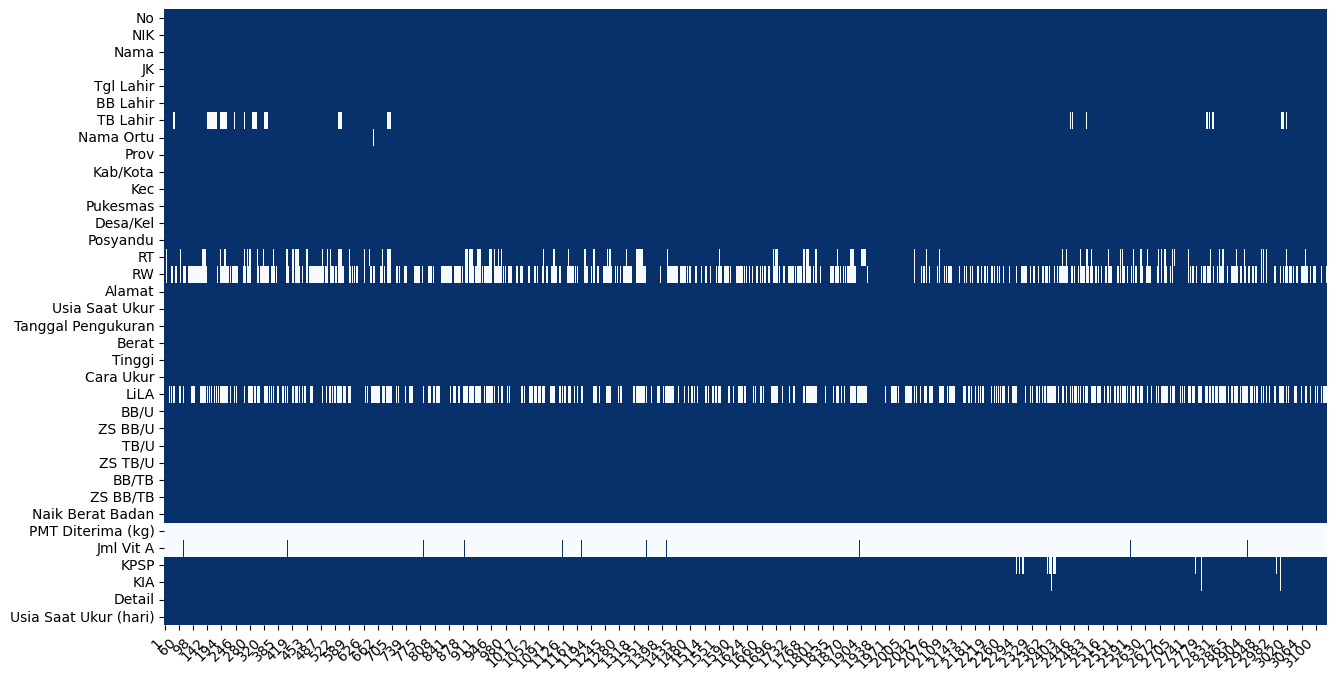

time: 1.34 s (started: 2025-10-28 14:15:46 +00:00)


In [30]:
plot_missing_value(
    df,
    return_df=True,
    feature_alignment='r',
    figsize=(15, 8),
)

**<span style="color:#e352d7">Findings:</span>**
* Terdapat 3.74% missing value pada **"TB Lahir"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 0.13% missing value pada **"Posyandu"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 11.09% missing value pada "RT" tetapi bukan sebuah fitur
* Terdapat 48.68% missing value pada "RW" tetapi bukan sebuah fitur
* Terdapat 0.04% missing value pada **"Tinggi"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 46.37% missing value pada **"LiLA"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 0.04% missing value pada **"ZS TB/U"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 0.04% missing value pada **"ZS BB/TB"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 99.96% missing value pada **"PMT Diterima (kg)"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 99.19% missing value pada **"Jml Vit A"** dan dapat dilakukan impute pada tahap preprocessing
* Terdapat 1.51% missing value pada "KPSP" tetapi bukan sebuah fitur
* Terdapat 0.14% missing value pada "KIA" tetapi bukan sebuah fitur

## 3.2. Duplicate Data

In [31]:
total_duplikat_all = df.duplicated().sum()
print(f"Total duplikat (semua kolom identik): {total_duplikat_all}")

Total duplikat (semua kolom identik): 0
time: 15.7 ms (started: 2025-10-28 14:15:47 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Tidak terdapat baris duplikat yang memiliki nilai sama untuk semua kolom

In [32]:
total_duplikat_nik = df.duplicated(subset=['NIK']).sum()
print(f"\nTotal duplikat (berdasarkan NIK): {total_duplikat_nik}")

total_duplikat_nama = df.duplicated(subset=['Nama']).sum()
print(f"Total duplikat (berdasarkan NAMA): {total_duplikat_nama}")


Total duplikat (berdasarkan NIK): 360
Total duplikat (berdasarkan NAMA): 386
time: 3.59 ms (started: 2025-10-28 14:15:47 +00:00)


In [33]:
total_duplikat_nik = df.duplicated(subset=['NIK']).sum()
print(f"\nTotal duplikat (berdasarkan NIK): {total_duplikat_nik}")

total_duplikat_nama = df.duplicated(subset=['Nama']).sum()
print(f"Total duplikat (berdasarkan NAMA): {total_duplikat_nama}")

if total_duplikat_nik > 0:
    print("\nContoh baris duplikat (berdasarkan NIK):")
    display(df[df.duplicated(subset=['NIK'], keep=False)].sort_values('NIK').head(6))

if total_duplikat_nama > 0:
    print("\nContoh baris duplikat (berdasarkan Nama):")
    display(df[df.duplicated(subset=['Nama'], keep=False)].sort_values('Nama').head(6))


Total duplikat (berdasarkan NIK): 360
Total duplikat (berdasarkan NAMA): 386

Contoh baris duplikat (berdasarkan NIK):


No        NIK                    Nama JK  Tgl Lahir  BB Lahir  \
2880  2881    3314000  TAMAM RAZZAN DAIFULLAH  L 2022-01-23      2.70   
2536  2537    3314000  TAMAM RAZZAN DAIFULLAH  L 2022-01-23      2.70   
2405  2406   32112121          NADISA ZAKIA S  P 2019-11-29      3.20   
2793  2794   32112121          NADISA ZAKIA S  P 2019-11-29      3.20   
2483  2484  232111333           GALISA YASMIN  P 2021-06-06      3.00   
2847  2848  232111333           GALISA YASMIN  P 2021-06-06      3.00   

      TB Lahir  Nama Ortu         Prov    Kab/Kota        Kec   Pukesmas  \
2880     48.00  Eva Anis   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2536     48.00  Eva Anis   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2405     48.00     Burhan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2793     48.00     Burhan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2483     49.00    harsono  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2847     49.00    harsono  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   

        Desa/Kel      Posyandu RT   RW       Alamat Usia Saat Ukur  \
2880     NGEBUNG  AMAL SEHAT 1  1  NaN        Bubak       957 days   
2536     NGEBUNG  AMAL SEHAT 1  1  NaN        Bubak       957 days   
2405  SAMBEREMBE     EKAWATI 2  9  NaN   sambirembe      1742 days   
2793  SAMBEREMBE     EKAWATI 2  9  NaN   sambirembe      1742 days   
2483  SAMBEREMBE     EKAWATI 2  8  NaN  sambirembe       1187 days   
2847  SAMBEREMBE     EKAWATI 2  8  NaN  sambirembe       1187 days   

     Tanggal Pengukuran  Berat  Tinggi Cara Ukur  LiLA    BB/U  ZS BB/U  \
2880         2024-09-06  10.30   85.50   Berdiri   NaN  Kurang    -2.33   
2536         2024-09-06  10.30   85.50   Berdiri   NaN  Kurang    -2.33   
2405         2024-09-05  12.20   91.50   Berdiri 14.00  Kurang    -2.73   
2793         2024-09-05  12.20   91.50   Berdiri 14.00  Kurang    -2.73   
2483         2024-09-05  10.80   88.50   Berdiri 13.50  Kurang    -2.30   
2847         2024-09-05  10.80   88.50   Berdiri 13.50  Kurang    -2.30   

               TB/U  ZS TB/U   BB/TB  ZS BB/TB Naik Berat Badan  \
2880         Pendek    -2.15  Normal     -1.70                T   
2536         Pendek    -2.15  Normal     -1.70                T   
2405  Sangat Pendek    -3.53  Normal     -0.74                O   
2793  Sangat Pendek    -3.53  Normal     -0.74                O   
2483         Pendek    -2.18  Normal     -1.47                N   
2847         Pendek    -2.18  Normal     -1.47                N   

      PMT Diterima (kg)  Jml Vit A KPSP KIA Detail  Usia Saat Ukur (hari)  
2880                NaN        NaN    -   -                           957  
2536                NaN        NaN    -   -                           957  
2405                NaN        NaN    -   -                          1742  
2793                NaN        NaN    -   -                          1742  
2483                NaN        NaN    -   -                          1187  
2847                NaN        NaN    -   -                          1187


Contoh baris duplikat (berdasarkan Nama):


No               NIK                    Nama JK  Tgl Lahir  BB Lahir  \
59      60  3314100312199098       ABDUL RAUP ANNAFI  L 2019-12-03      2.70   
2398  2399  3314100312199098       ABDUL RAUP ANNAFI  L 2019-12-03      2.70   
1084  1085  3314013004210001        ABDURAHMAN KAHFI  L 2021-04-30      3.00   
2562  2563  3314013004210001        ABDURAHMAN KAHFI  L 2021-04-30      3.00   
2942  2943  3314011511220001  ABIMANYU DANNAR BUANA   L 2022-11-15      2.70   
2650  2651  3314011511220001  ABIMANYU DANNAR BUANA   L 2022-11-15      2.70   

      TB Lahir       Nama Ortu         Prov    Kab/Kota        Kec   Pukesmas  \
59       48.00        SUGIYONO  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2398     48.00        SUGIYONO  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
1084     50.00  Febri Setiawan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2562     50.00  Febri Setiawan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2942     47.00    Ari ngaisah   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2650     47.00    Ari ngaisah   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   

              Desa/Kel       Posyandu  RT RW       Alamat Usia Saat Ukur  \
59               KEDEN  WARGO MULYO 2   4  1  KEDEN KULON      1743 days   
2398             KEDEN  WARGO MULYO 2   4  1  KEDEN KULON      1743 days   
1084  JETIS KARANGPUNG    SIDOLUHUR 4  11  2     Rewungan      1221 days   
2562  JETIS KARANGPUNG    SIDOLUHUR 4  11  2     Rewungan      1221 days   
2942          KRIKILAN   SARI SAKTI 1   1  1     Ngrukun        664 days   
2650          KRIKILAN   SARI SAKTI 1   1  1     Ngrukun        664 days   

     Tanggal Pengukuran  Berat  Tinggi   Cara Ukur  LiLA                BB/U  \
59           2024-09-10  14.30   97.80     Berdiri 16.00  Berat Badan Normal   
2398         2024-09-10  14.30   97.80     Berdiri 16.00  Berat Badan Normal   
1084         2024-09-02  11.80   86.50     Berdiri 14.00  Berat Badan Normal   
2562         2024-09-02  11.80   86.50     Berdiri 14.00  Berat Badan Normal   
2942         2024-09-09   9.20   75.00  Terlentang   NaN              Kurang   
2650         2024-09-09   9.20   75.00  Terlentang   NaN              Kurang   

      ZS BB/U           TB/U  ZS TB/U   BB/TB  ZS BB/TB Naik Berat Badan  \
59      -1.70         Pendek    -2.35  Normal     -0.39                N   
2398    -1.70         Pendek    -2.35  Normal     -0.39                N   
1084    -1.98  Sangat Pendek    -3.14  Normal     -0.25                T   
2562    -1.98  Sangat Pendek    -3.14  Normal     -0.25                T   
2942    -2.14  Sangat Pendek    -3.72  Normal     -0.39                N   
2650    -2.14  Sangat Pendek    -3.72  Normal     -0.39                N   

      PMT Diterima (kg)  Jml Vit A KPSP KIA Detail  Usia Saat Ukur (hari)  
59                  NaN        NaN    -   -                          1743  
2398                NaN        NaN    -   -                          1743  
1084                NaN        NaN    -   -                          1221  
2562                NaN        NaN    -   -                          1221  
2942                NaN        NaN    -   -                           664  
2650                NaN        NaN    -   -                           664

time: 59.5 ms (started: 2025-10-28 14:15:47 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 384 baris duplikat berdasarkan **"NIK"**
* Terdapat 412 baris duplikat berdasarkan **"Nama"**

In [34]:
total_duplikat_nik = df.duplicated(subset=['NIK', 'Tanggal Pengukuran']).sum()
print(f"\nTotal duplikat (berdasarkan NIK): {total_duplikat_nik}")

total_duplikat_nama = df.duplicated(subset=['Nama', 'Tanggal Pengukuran']).sum()
print(f"Total duplikat (berdasarkan NAMA): {total_duplikat_nama}")

if total_duplikat_nik > 0:
    print("\nContoh baris duplikat (berdasarkan NIK):")
    display(df[df.duplicated(subset=['NIK', 'Tanggal Pengukuran'], keep=False)].sort_values('NIK').head(6))

if total_duplikat_nama > 0:
    print("\nContoh baris duplikat (berdasarkan Nama):")
    display(df[df.duplicated(subset=['Nama', 'Tanggal Pengukuran'], keep=False)].sort_values('Nama').head(6))


Total duplikat (berdasarkan NIK): 360
Total duplikat (berdasarkan NAMA): 363

Contoh baris duplikat (berdasarkan NIK):


No        NIK                    Nama JK  Tgl Lahir  BB Lahir  \
2880  2881    3314000  TAMAM RAZZAN DAIFULLAH  L 2022-01-23      2.70   
2536  2537    3314000  TAMAM RAZZAN DAIFULLAH  L 2022-01-23      2.70   
2405  2406   32112121          NADISA ZAKIA S  P 2019-11-29      3.20   
2793  2794   32112121          NADISA ZAKIA S  P 2019-11-29      3.20   
2483  2484  232111333           GALISA YASMIN  P 2021-06-06      3.00   
2847  2848  232111333           GALISA YASMIN  P 2021-06-06      3.00   

      TB Lahir  Nama Ortu         Prov    Kab/Kota        Kec   Pukesmas  \
2880     48.00  Eva Anis   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2536     48.00  Eva Anis   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2405     48.00     Burhan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2793     48.00     Burhan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2483     49.00    harsono  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2847     49.00    harsono  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   

        Desa/Kel      Posyandu RT   RW       Alamat Usia Saat Ukur  \
2880     NGEBUNG  AMAL SEHAT 1  1  NaN        Bubak       957 days   
2536     NGEBUNG  AMAL SEHAT 1  1  NaN        Bubak       957 days   
2405  SAMBEREMBE     EKAWATI 2  9  NaN   sambirembe      1742 days   
2793  SAMBEREMBE     EKAWATI 2  9  NaN   sambirembe      1742 days   
2483  SAMBEREMBE     EKAWATI 2  8  NaN  sambirembe       1187 days   
2847  SAMBEREMBE     EKAWATI 2  8  NaN  sambirembe       1187 days   

     Tanggal Pengukuran  Berat  Tinggi Cara Ukur  LiLA    BB/U  ZS BB/U  \
2880         2024-09-06  10.30   85.50   Berdiri   NaN  Kurang    -2.33   
2536         2024-09-06  10.30   85.50   Berdiri   NaN  Kurang    -2.33   
2405         2024-09-05  12.20   91.50   Berdiri 14.00  Kurang    -2.73   
2793         2024-09-05  12.20   91.50   Berdiri 14.00  Kurang    -2.73   
2483         2024-09-05  10.80   88.50   Berdiri 13.50  Kurang    -2.30   
2847         2024-09-05  10.80   88.50   Berdiri 13.50  Kurang    -2.30   

               TB/U  ZS TB/U   BB/TB  ZS BB/TB Naik Berat Badan  \
2880         Pendek    -2.15  Normal     -1.70                T   
2536         Pendek    -2.15  Normal     -1.70                T   
2405  Sangat Pendek    -3.53  Normal     -0.74                O   
2793  Sangat Pendek    -3.53  Normal     -0.74                O   
2483         Pendek    -2.18  Normal     -1.47                N   
2847         Pendek    -2.18  Normal     -1.47                N   

      PMT Diterima (kg)  Jml Vit A KPSP KIA Detail  Usia Saat Ukur (hari)  
2880                NaN        NaN    -   -                           957  
2536                NaN        NaN    -   -                           957  
2405                NaN        NaN    -   -                          1742  
2793                NaN        NaN    -   -                          1742  
2483                NaN        NaN    -   -                          1187  
2847                NaN        NaN    -   -                          1187


Contoh baris duplikat (berdasarkan Nama):


No               NIK                    Nama JK  Tgl Lahir  BB Lahir  \
59      60  3314100312199098       ABDUL RAUP ANNAFI  L 2019-12-03      2.70   
2398  2399  3314100312199098       ABDUL RAUP ANNAFI  L 2019-12-03      2.70   
1084  1085  3314013004210001        ABDURAHMAN KAHFI  L 2021-04-30      3.00   
2562  2563  3314013004210001        ABDURAHMAN KAHFI  L 2021-04-30      3.00   
2650  2651  3314011511220001  ABIMANYU DANNAR BUANA   L 2022-11-15      2.70   
2942  2943  3314011511220001  ABIMANYU DANNAR BUANA   L 2022-11-15      2.70   

      TB Lahir       Nama Ortu         Prov    Kab/Kota        Kec   Pukesmas  \
59       48.00        SUGIYONO  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2398     48.00        SUGIYONO  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
1084     50.00  Febri Setiawan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2562     50.00  Febri Setiawan  JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2650     47.00    Ari ngaisah   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   
2942     47.00    Ari ngaisah   JAWA TENGAH  KAB SRAGEN  KALIJAMBE  KALIJAMBE   

              Desa/Kel       Posyandu  RT RW       Alamat Usia Saat Ukur  \
59               KEDEN  WARGO MULYO 2   4  1  KEDEN KULON      1743 days   
2398             KEDEN  WARGO MULYO 2   4  1  KEDEN KULON      1743 days   
1084  JETIS KARANGPUNG    SIDOLUHUR 4  11  2     Rewungan      1221 days   
2562  JETIS KARANGPUNG    SIDOLUHUR 4  11  2     Rewungan      1221 days   
2650          KRIKILAN   SARI SAKTI 1   1  1     Ngrukun        664 days   
2942          KRIKILAN   SARI SAKTI 1   1  1     Ngrukun        664 days   

     Tanggal Pengukuran  Berat  Tinggi   Cara Ukur  LiLA                BB/U  \
59           2024-09-10  14.30   97.80     Berdiri 16.00  Berat Badan Normal   
2398         2024-09-10  14.30   97.80     Berdiri 16.00  Berat Badan Normal   
1084         2024-09-02  11.80   86.50     Berdiri 14.00  Berat Badan Normal   
2562         2024-09-02  11.80   86.50     Berdiri 14.00  Berat Badan Normal   
2650         2024-09-09   9.20   75.00  Terlentang   NaN              Kurang   
2942         2024-09-09   9.20   75.00  Terlentang   NaN              Kurang   

      ZS BB/U           TB/U  ZS TB/U   BB/TB  ZS BB/TB Naik Berat Badan  \
59      -1.70         Pendek    -2.35  Normal     -0.39                N   
2398    -1.70         Pendek    -2.35  Normal     -0.39                N   
1084    -1.98  Sangat Pendek    -3.14  Normal     -0.25                T   
2562    -1.98  Sangat Pendek    -3.14  Normal     -0.25                T   
2650    -2.14  Sangat Pendek    -3.72  Normal     -0.39                N   
2942    -2.14  Sangat Pendek    -3.72  Normal     -0.39                N   

      PMT Diterima (kg)  Jml Vit A KPSP KIA Detail  Usia Saat Ukur (hari)  
59                  NaN        NaN    -   -                          1743  
2398                NaN        NaN    -   -                          1743  
1084                NaN        NaN    -   -                          1221  
2562                NaN        NaN    -   -                          1221  
2650                NaN        NaN    -   -                           664  
2942                NaN        NaN    -   -                           664

time: 48.3 ms (started: 2025-10-28 14:15:47 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 384 baris duplikat berdasarkan **"NIK"** dan melakukan pengukuran dihari yang sama
* Terdapat 388 baris duplikat berdasarkan **"Nama"** dan melakukan pengukuran dihari yang sama

In [35]:
df.shape

mask_nik = df.duplicated(subset=['NIK', 'Tanggal Pengukuran'], keep='first')

mask_nama = df.duplicated(subset=['Nama', 'Tanggal Pengukuran'], keep='first')

mask_all = mask_nik | mask_nama

df = df[~mask_all].copy()

df.shape

total_duplikat_nik = df.duplicated(subset=['NIK', 'Tanggal Pengukuran']).sum()
print(f"\nTotal duplikat (berdasarkan NIK): {total_duplikat_nik}")

total_duplikat_nama = df.duplicated(subset=['Nama', 'Tanggal Pengukuran']).sum()
print(f"Total duplikat (berdasarkan NAMA): {total_duplikat_nama}")

(2699, 36)

(2334, 36)


Total duplikat (berdasarkan NIK): 0
Total duplikat (berdasarkan NAMA): 0
time: 15.9 ms (started: 2025-10-28 14:15:47 +00:00)


**<span style="color:#e352d7">Findings:</span>**
* Terdapat 2849 baris data sebelum menghapus dupliikat data (salah satu baris)
* Tersisa 2459 baris data setelah menghapus dupliikat data (salah satu baris)

## 3.3. Univariate Analysis

### 3.3.1. Univariate Analysis - Target

<Figure size 800x600 with 0 Axes>

Text(0.0, 1986.0, '1986')

Text(1.0, 283.0, '283')

Text(2.0, 61.0, '61')

Text(3.0, 4.0, '4')

Text(0.5, 0, 'Height-for-Age Category (TB/U)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of Height-for-Age Categories')

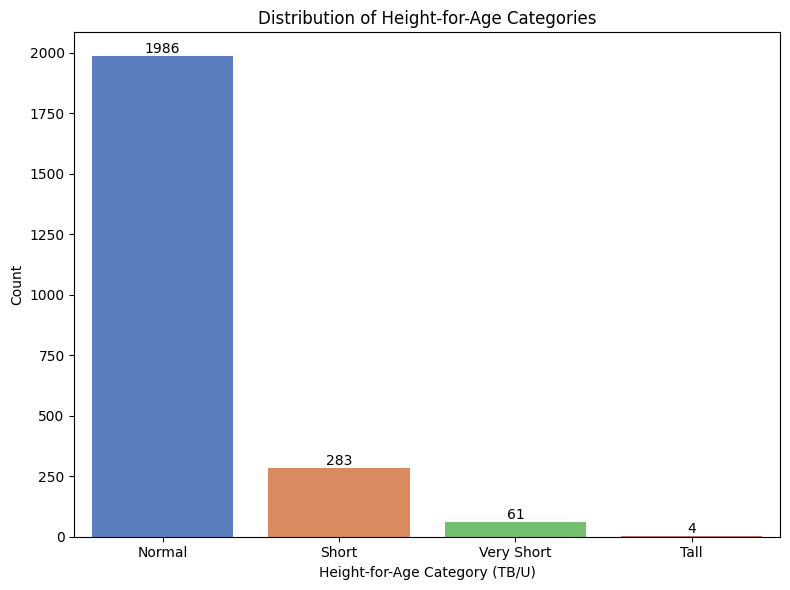

time: 250 ms (started: 2025-10-28 14:15:47 +00:00)


In [36]:
# Ganti nama kategori ke bahasa Inggris
df['TB/U'] = df['TB/U'].replace({
    'Normal': 'Normal',
    'Pendek': 'Short',
    'Sangat Pendek': 'Very Short',
    'Tinggi': 'Tall'
})

# Buat plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='TB/U', palette='muted')

# Tambahkan label jumlah di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Ubah label sumbu dan judul ke bahasa Inggris
plt.xlabel('Height-for-Age Category (TB/U)')
plt.ylabel('Count')
plt.title('Distribution of Height-for-Age Categories')

plt.tight_layout()
plt.show()

In [37]:
# df['TB/U'] = df['TB/U'].apply(lambda x: 'Normal sampai Tinggi' if x in ['Normal', 'Tinggi'] else x)

time: 251 µs (started: 2025-10-28 14:15:48 +00:00)


<Figure size 800x600 with 0 Axes>

Text(0.0, 1990.0, '1990')

Text(1.0, 283.0, '283')

Text(2.0, 61.0, '61')

Text(0.5, 0, 'Height-for-Age Category (TB/U)')

Text(0, 0.5, 'Count')

Text(0.5, 1.0, 'Distribution of Height-for-Age Categories')

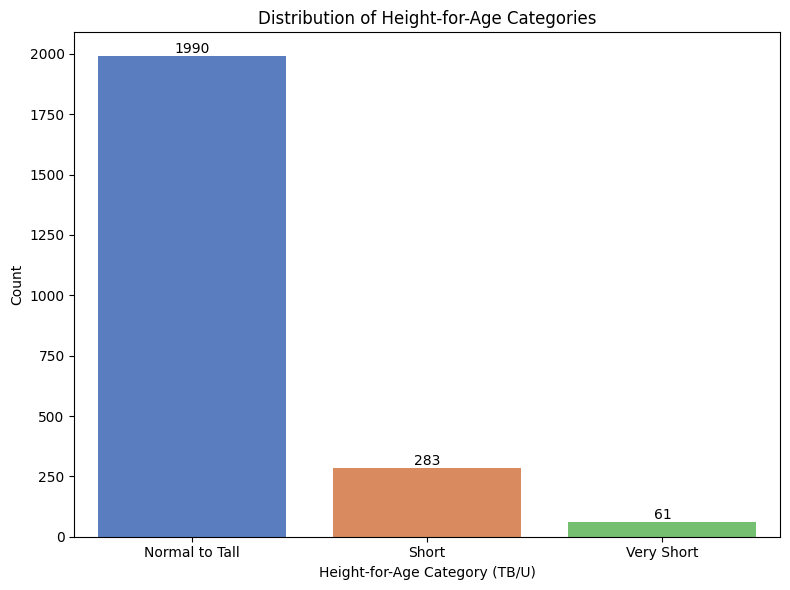

time: 245 ms (started: 2025-10-28 14:15:48 +00:00)


In [38]:
df['TB/U'] = df['TB/U'].apply(lambda x: 'Normal to Tall' if x in ['Normal', 'Tall'] else x)
df['TB/U'] = df['TB/U'].replace({
    'Pendek': 'Short',
    'Sangat Pendek': 'Very Short'
})

# Buat plot
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=df, x='TB/U', palette='muted')

# Tambahkan label jumlah di atas batang
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)}',               # Angka bulat
                (p.get_x() + p.get_width() / 2, height),
                ha='center', va='bottom')

# Ubah label sumbu dan judul ke bahasa Inggris
plt.xlabel('Height-for-Age Category (TB/U)')
plt.ylabel('Count')
plt.title('Distribution of Height-for-Age Categories')

plt.tight_layout()
plt.show()

### 3.3.1. Univariate Analysis - Features - Target - Outlier

In [39]:
def remove_outlier(df, contamination=0.001, random_state=42, column=''):
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=random_state
    )
    
    # Buat mask untuk data yang TIDAK NaN
    mask_not_nan = df[column].notna()
    
    # Ambil data yang valid (tidak NaN)
    X_valid = df.loc[mask_not_nan, column].values.reshape(-1, 1)
    
    # Fit predict hanya pada data valid
    predictions = iso_forest.fit_predict(X_valid)
    
    # Buat mask untuk inliers (bukan outlier)
    mask_inliers = predictions == 1
    
    # Gabungkan: Pertahankan NaN + Pertahankan inliers
    # Baris dengan NaN = True (dipertahankan)
    # Baris valid yang bukan outlier = True (dipertahankan)
    # Baris valid yang outlier = False (dibuang)
    final_mask = ~mask_not_nan | (mask_not_nan & pd.Series(mask_inliers, index=df[mask_not_nan].index).reindex(df.index, fill_value=False))
    
    stats = {
        'total_rows_before': len(df),
        'nan_values': (~mask_not_nan).sum(),
        'outliers_removed': mask_not_nan.sum() - mask_inliers.sum(),
        'total_rows_after': final_mask.sum(),
        'percentage_removed': ((len(df) - final_mask.sum()) / len(df) * 100),
        'original_mean': df[column].mean(),
        'new_mean': df.loc[final_mask, column].mean(),
        'original_std': df[column].std(),
        'new_std': df.loc[final_mask, column].std(),
    }
    
    return df[final_mask].copy(), stats

time: 1.31 ms (started: 2025-10-28 14:15:48 +00:00)


#### 3.3.1.1. Berat Badan (Sebelum Handling Outlier)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Birth Weight and Current Weight')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Weight (kg)')

([<matplotlib.axis.XTick at 0x7ff5de0c14d0>,
 [Text(0, 0, 'Birth Weight'), Text(1, 0, 'Current Weight')])

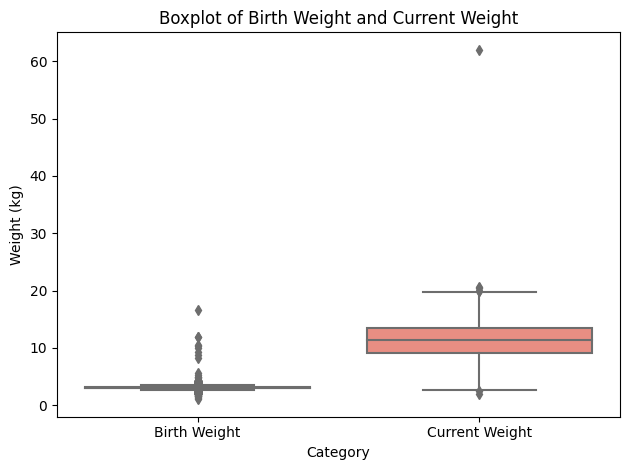

time: 213 ms (started: 2025-10-28 14:15:48 +00:00)


In [40]:
# Buat boxplot menggunakan kolom asli
sns.boxplot(
    data=df[['BB Lahir', 'Berat']],
    palette={'BB Lahir': 'skyblue', 'Berat': 'salmon'}
)

# Ganti judul dan label sumbu ke bahasa Inggris
plt.title('Boxplot of Birth Weight and Current Weight')
plt.xlabel('Category')
plt.ylabel('Weight (kg)')

# Ganti label kategori di sumbu x ke bahasa Inggris tanpa ubah DataFrame
plt.xticks(
    ticks=[0, 1],
    labels=['Birth Weight', 'Current Weight']
)

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: xlabel='BB Lahir'>

Text(0.5, 1.0, 'Distribution of Birth Weight')

Text(0.5, 0, 'Birth Weight (kg)')

Text(0, 0.5, 'Density')

<Axes: >

<Axes: xlabel='Berat'>

Text(0.5, 1.0, 'Distribution of Current Weight')

Text(0.5, 0, 'Current Weight (kg)')

Text(0, 0.5, 'Density')

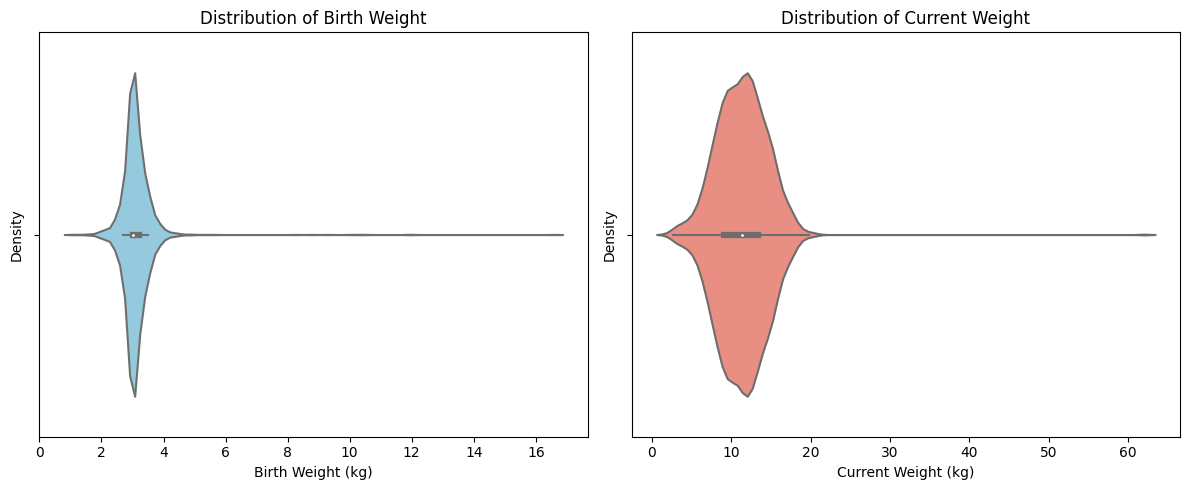

time: 389 ms (started: 2025-10-28 14:15:48 +00:00)


In [41]:
# Atur ukuran figure
plt.figure(figsize=(12, 5))

# Plot pertama: Birth Weight
plt.subplot(1, 2, 1)
sns.violinplot(data=df, x='BB Lahir', color='skyblue')
plt.title('Distribution of Birth Weight')
plt.xlabel('Birth Weight (kg)')
plt.ylabel('Density')

# Plot kedua: Current Weight
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='Berat', color='salmon')
plt.title('Distribution of Current Weight')
plt.xlabel('Current Weight (kg)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 3.3.1.2. Tinggi Badan (Sebelum Handling Outlier)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Birth Height and Current Height')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Height (cm)')

([<matplotlib.axis.XTick at 0x7ff5dd8a9710>,
 [Text(0, 0, 'Birth Height'), Text(1, 0, 'Current Height')])

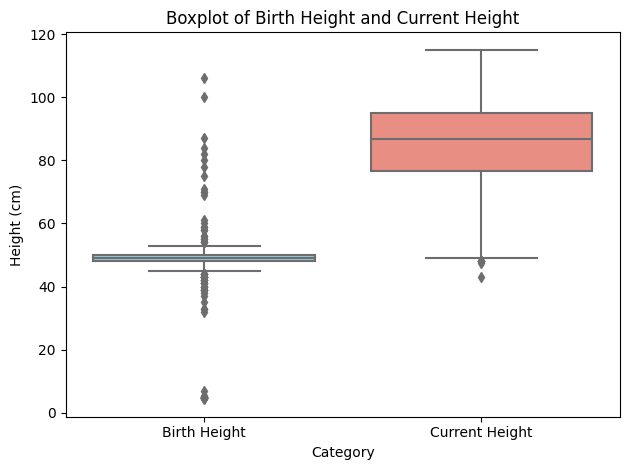

time: 199 ms (started: 2025-10-28 14:15:49 +00:00)


In [42]:
# Buat boxplot menggunakan kolom asli
sns.boxplot(
    data=df[['TB Lahir', 'Tinggi']],
    palette={'TB Lahir': 'skyblue', 'Tinggi': 'salmon'}
)

# Ubah label dan judul ke bahasa Inggris
plt.title('Boxplot of Birth Height and Current Height')
plt.xlabel('Category')
plt.ylabel('Height (cm)')

# Ganti label sumbu x tanpa ubah kolom DataFrame
plt.xticks(
    ticks=[0, 1],
    labels=['Birth Height', 'Current Height']
)

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: xlabel='TB Lahir'>

Text(0.5, 1.0, 'Distribution of Birth Height')

Text(0.5, 0, 'Birth Height (cm)')

Text(0, 0.5, 'Density')

<Axes: >

<Axes: xlabel='Tinggi'>

Text(0.5, 1.0, 'Distribution of Current Height')

Text(0.5, 0, 'Current Height (cm)')

Text(0, 0.5, 'Density')

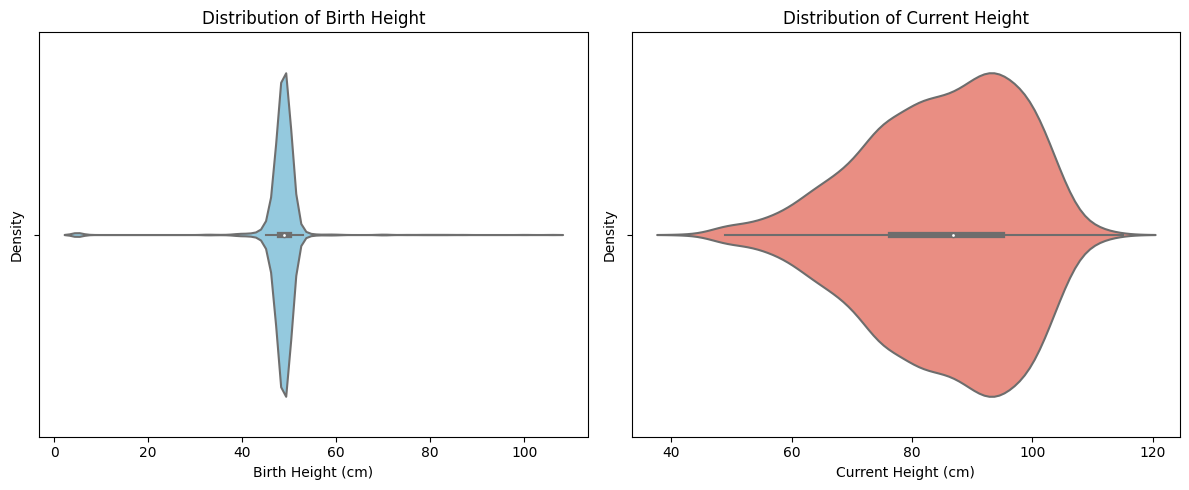

time: 379 ms (started: 2025-10-28 14:15:49 +00:00)


In [43]:
# Atur ukuran figure
plt.figure(figsize=(12, 5))

# Plot pertama: Birth Height
plt.subplot(1, 2, 1)
sns.violinplot(data=df, x='TB Lahir', color='skyblue')
plt.title('Distribution of Birth Height')
plt.xlabel('Birth Height (cm)')
plt.ylabel('Density')

# Plot kedua: Current Height
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='Tinggi', color='salmon')
plt.title('Distribution of Current Height')
plt.xlabel('Current Height (cm)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 3.3.1.3. LiLA (Sebelum Handling Outlier)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Mid-Upper Arm Circumference (LiLA)')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Circumference (cm)')

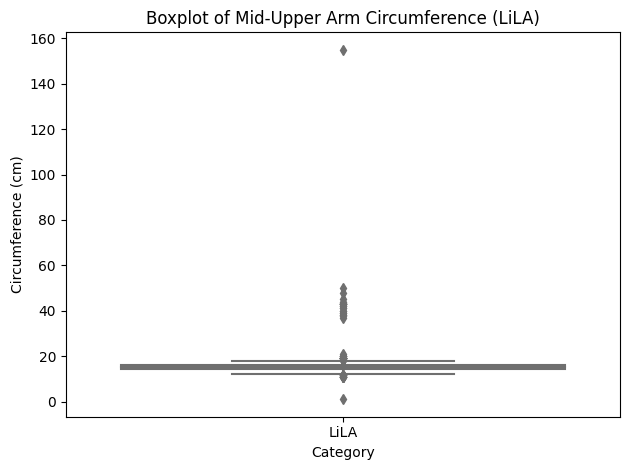

time: 196 ms (started: 2025-10-28 14:15:49 +00:00)


In [44]:
# Buat boxplot untuk LiLA
sns.boxplot(data=df[['LiLA']], color='skyblue')

# Tambahkan judul dan label sumbu dalam bahasa Inggris
plt.title('Boxplot of Mid-Upper Arm Circumference (LiLA)')
plt.xlabel('Category')
plt.ylabel('Circumference (cm)')

plt.tight_layout()
plt.show()

<Axes: xlabel='LiLA'>

Text(0.5, 1.0, 'Distribution of Mid-Upper Arm Circumference (LiLA)')

Text(0.5, 0, 'Mid-Upper Arm Circumference (cm)')

Text(0, 0.5, 'Density')

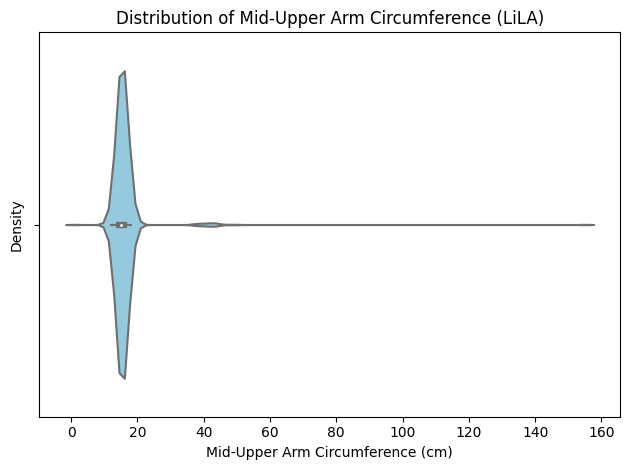

time: 199 ms (started: 2025-10-28 14:15:49 +00:00)


In [45]:
# Buat violin plot untuk LiLA
sns.violinplot(data=df, x='LiLA', color='skyblue')

# Ubah judul dan label sumbu ke bahasa Inggris
plt.title('Distribution of Mid-Upper Arm Circumference (LiLA)')
plt.xlabel('Mid-Upper Arm Circumference (cm)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 3.3.1.4. Usia Saat Ukur (hari)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Age at Measurement (days)')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Age (days)')

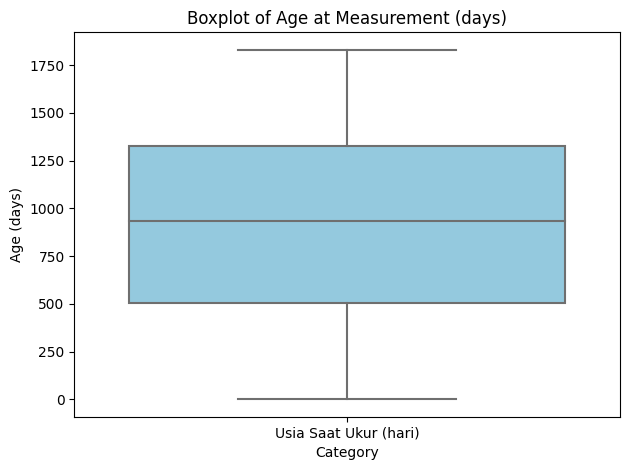

time: 188 ms (started: 2025-10-28 14:15:50 +00:00)


In [46]:
# Buat boxplot untuk kolom 'Usia Saat Ukur (hari)'
sns.boxplot(data=df[['Usia Saat Ukur (hari)']], color='skyblue')

# Ubah judul dan label sumbu ke bahasa Inggris
plt.title('Boxplot of Age at Measurement (days)')
plt.xlabel('Category')
plt.ylabel('Age (days)')

plt.tight_layout()
plt.show()

<Axes: xlabel='Usia Saat Ukur (hari)'>

Text(0.5, 1.0, 'Distribution of Age at Measurement (days)')

Text(0.5, 0, 'Age at Measurement (days)')

Text(0, 0.5, 'Density')

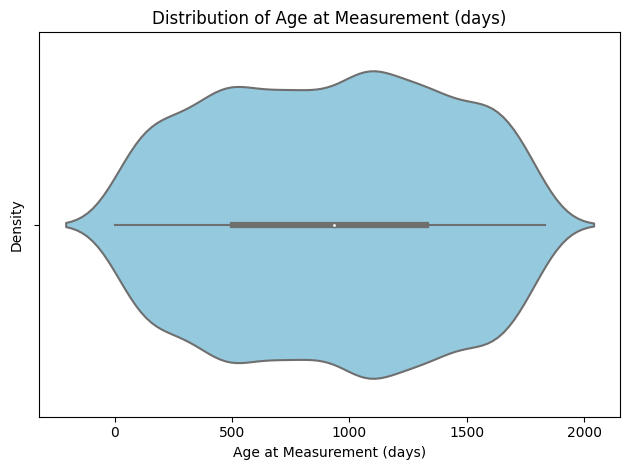

time: 177 ms (started: 2025-10-28 14:15:50 +00:00)


In [47]:
# Buat violin plot untuk kolom 'Usia Saat Ukur (hari)'
sns.violinplot(data=df, x='Usia Saat Ukur (hari)', color='skyblue')

# Ubah judul dan label sumbu ke bahasa Inggris
plt.title('Distribution of Age at Measurement (days)')
plt.xlabel('Age at Measurement (days)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [48]:
df, stats = remove_outlier(df, contamination=0.1, column='BB Lahir')
rows_before = stats['total_rows_before']
df, stats = remove_outlier(df, contamination=0.01, column='Berat')
df, stats = remove_outlier(df, contamination=0.01, column='TB Lahir')
df, stats = remove_outlier(df, contamination=0.01, column='Tinggi')
df, stats = remove_outlier(df, contamination=0.01, column='LiLA')
rows_after = stats['total_rows_after']
print(f"Original rows: {rows_before}")
print(f"Rows after cleaning: {rows_after}")
print(f"Overall Percentage removed: {((rows_before - rows_after) / rows_before) * 100:.2f}%")

Original rows: 2334
Rows after cleaning: 2063
Overall Percentage removed: 11.61%
time: 941 ms (started: 2025-10-28 14:15:50 +00:00)


#### 3.3.1.4. Berat Badan (Setelah Handling Outlier)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Birth Weight and Current Weight (Outlier Handled)')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Weight (kg)')

([<matplotlib.axis.XTick at 0x7ff5dda40f10>,
 [Text(0, 0, 'Birth Weight'), Text(1, 0, 'Current Weight')])

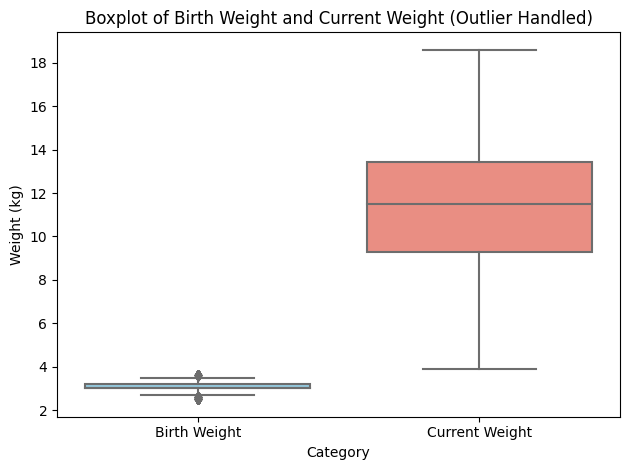

time: 342 ms (started: 2025-10-28 14:15:51 +00:00)


In [49]:
# Buat boxplot menggunakan kolom asli
sns.boxplot(
    data=df[['BB Lahir', 'Berat']],
    palette={'BB Lahir': 'skyblue', 'Berat': 'salmon'}
)

# Ubah label dan judul ke bahasa Inggris
plt.title('Boxplot of Birth Weight and Current Weight (Outlier Handled)')
plt.xlabel('Category')
plt.ylabel('Weight (kg)')

# Ganti label sumbu x tanpa ubah kolom DataFrame
plt.xticks(
    ticks=[0, 1],
    labels=['Birth Weight', 'Current Weight']
)

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: xlabel='BB Lahir'>

Text(0.5, 1.0, 'Distribution of Birth Weight (Outlier Handled)')

Text(0.5, 0, 'Birth Weight (kg)')

Text(0, 0.5, 'Density')

<Axes: >

<Axes: xlabel='Berat'>

Text(0.5, 1.0, 'Distribution of Current Weight (Outlier Handled)')

Text(0.5, 0, 'Current Weight (kg)')

Text(0, 0.5, 'Density')

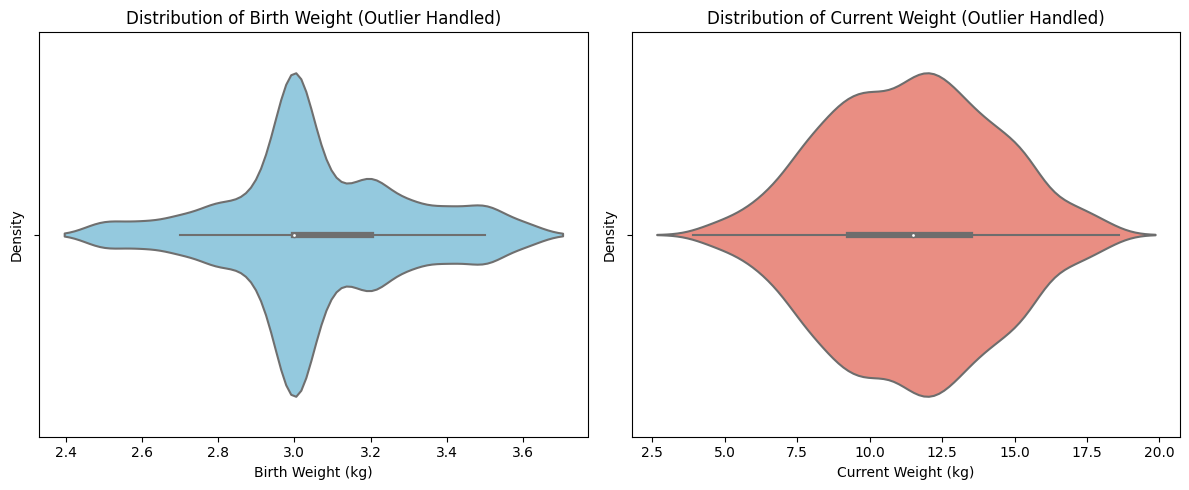

time: 365 ms (started: 2025-10-28 14:15:51 +00:00)


In [50]:
# Atur ukuran figure
plt.figure(figsize=(12, 5))

# Plot pertama: Birth Weight
plt.subplot(1, 2, 1)
sns.violinplot(data=df, x='BB Lahir', color='skyblue')
plt.title('Distribution of Birth Weight (Outlier Handled)')
plt.xlabel('Birth Weight (kg)')
plt.ylabel('Density')

# Plot kedua: Current Weight
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='Berat', color='salmon')
plt.title('Distribution of Current Weight (Outlier Handled)')
plt.xlabel('Current Weight (kg)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 3.3.1.5. Tinggi Badan (Setelah Handling Outlier)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Birth Height and Current Height (Outlier Handled)')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Height (cm)')

([<matplotlib.axis.XTick at 0x7ff5ddc796d0>,
 [Text(0, 0, 'Birth Height'), Text(1, 0, 'Current Height')])

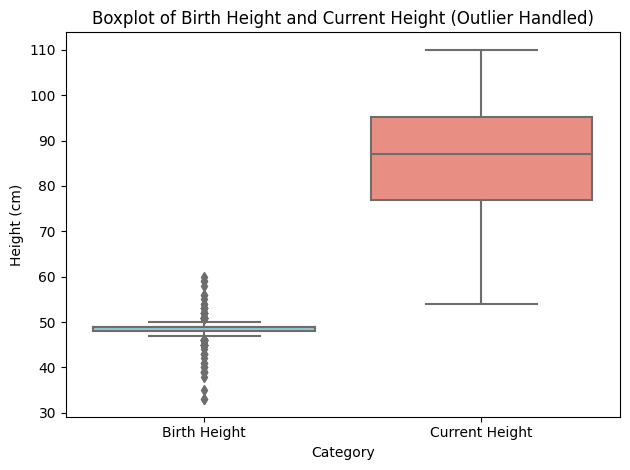

time: 222 ms (started: 2025-10-28 14:15:52 +00:00)


In [51]:
# Buat boxplot menggunakan kolom asli
sns.boxplot(
    data=df[['TB Lahir', 'Tinggi']],
    palette={'TB Lahir': 'skyblue', 'Tinggi': 'salmon'}
)

# Ubah judul dan label sumbu ke bahasa Inggris
plt.title('Boxplot of Birth Height and Current Height (Outlier Handled)')
plt.xlabel('Category')
plt.ylabel('Height (cm)')

# Ganti label sumbu x tanpa mengubah kolom DataFrame
plt.xticks(
    ticks=[0, 1],
    labels=['Birth Height', 'Current Height']
)

plt.tight_layout()
plt.show()

<Figure size 1200x500 with 0 Axes>

<Axes: >

<Axes: xlabel='TB Lahir'>

Text(0.5, 1.0, 'Distribution of Birth Height (Outlier Handled)')

Text(0.5, 0, 'Birth Height (cm)')

Text(0, 0.5, 'Density')

<Axes: >

<Axes: xlabel='Tinggi'>

Text(0.5, 1.0, 'Distribution of Current Height (Outlier Handled)')

Text(0.5, 0, 'Current Height (cm)')

Text(0, 0.5, 'Density')

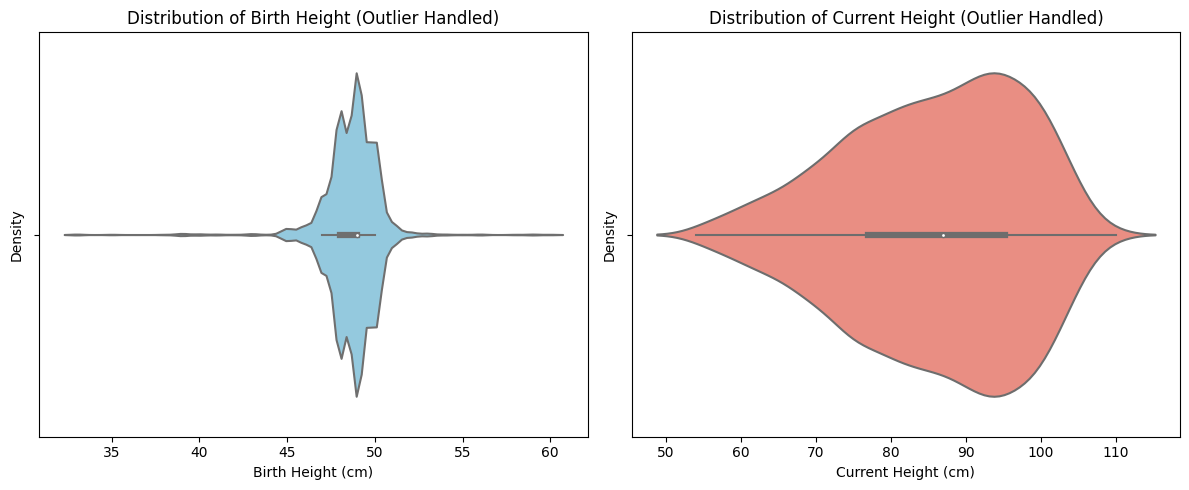

time: 361 ms (started: 2025-10-28 14:15:52 +00:00)


In [52]:
# Atur ukuran figure
plt.figure(figsize=(12, 5))

# Plot pertama: Birth Height
plt.subplot(1, 2, 1)
sns.violinplot(data=df, x='TB Lahir', color='skyblue')
plt.title('Distribution of Birth Height (Outlier Handled)')
plt.xlabel('Birth Height (cm)')
plt.ylabel('Density')

# Plot kedua: Current Height
plt.subplot(1, 2, 2)
sns.violinplot(data=df, x='Tinggi', color='salmon')
plt.title('Distribution of Current Height (Outlier Handled)')
plt.xlabel('Current Height (cm)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

#### 3.3.1.6. Tinggi Badan (Setelah Handling Outlier)

<Axes: >

Text(0.5, 1.0, 'Boxplot of Mid-Upper Arm Circumference (LiLA) (Outlier Handled)')

Text(0.5, 0, 'Category')

Text(0, 0.5, 'Circumference (cm)')

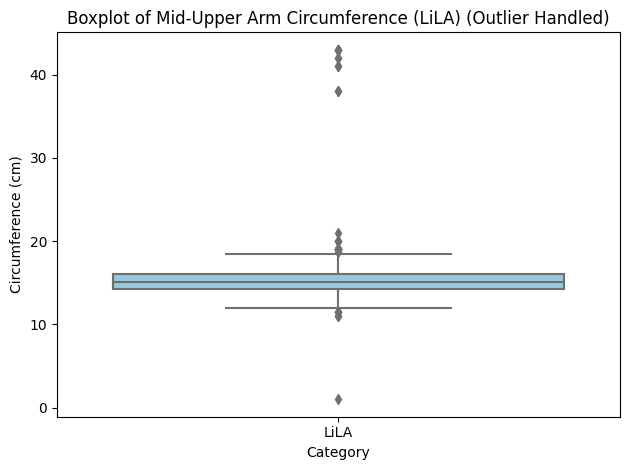

time: 161 ms (started: 2025-10-28 14:15:52 +00:00)


In [53]:
# Buat boxplot untuk LiLA
sns.boxplot(data=df[['LiLA']], palette={'LiLA': 'skyblue'})

# Ubah judul dan label sumbu ke bahasa Inggris
plt.title('Boxplot of Mid-Upper Arm Circumference (LiLA) (Outlier Handled)')
plt.xlabel('Category')
plt.ylabel('Circumference (cm)')

plt.tight_layout()
plt.show()

<Axes: xlabel='LiLA'>

Text(0.5, 1.0, 'Distribution of Mid-Upper Arm Circumference (LiLA) (Outlier Handled)')

Text(0.5, 0, 'Mid-Upper Arm Circumference (cm)')

Text(0, 0.5, 'Density')

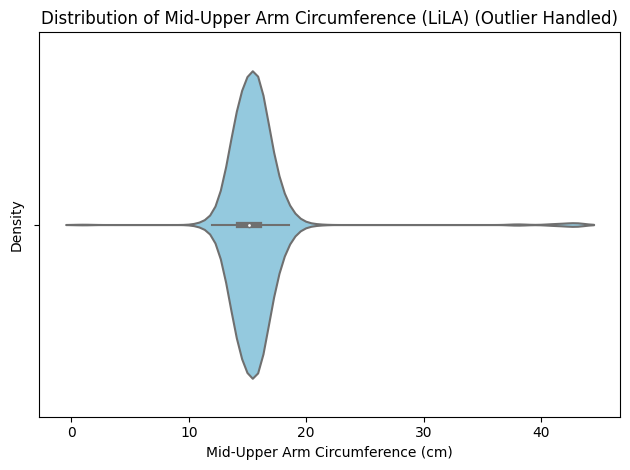

time: 181 ms (started: 2025-10-28 14:15:52 +00:00)


In [54]:
# Buat violin plot untuk LiLA
sns.violinplot(data=df, x='LiLA', color='skyblue')

# Ubah judul dan label sumbu ke bahasa Inggris
plt.title('Distribution of Mid-Upper Arm Circumference (LiLA) (Outlier Handled)')
plt.xlabel('Mid-Upper Arm Circumference (cm)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


## 3.4. Bivariate Analysis

### 3.4.1. Correlation Matrix (Numeric vs Target)

In [55]:
df_encoded = df.copy()
df_encoded['TB/U'] = df['TB/U'].map({
    'Sangat Pendek' : 0,
    'Pendek' : 1,
    'Normal sampai Tinggi' : 2,
})

time: 2.56 ms (started: 2025-10-28 14:15:53 +00:00)


In [56]:
df_encoded['Jml Vit A'].value_counts()
df_encoded['Jml Vit A'] = df_encoded['Jml Vit A'].fillna(0)
df_encoded['Jml Vit A'].value_counts()

Jml Vit A
1.00    19
Name: count, dtype: int64

Jml Vit A
0.00    2044
1.00      19
Name: count, dtype: int64

time: 16.6 ms (started: 2025-10-28 14:15:53 +00:00)


In [57]:
df_encoded['PMT Diterima (kg)'].value_counts()
df_encoded['PMT Diterima (kg)'] = df['PMT Diterima (kg)'].fillna(0)
df_encoded['PMT Diterima (kg)'].value_counts()

PMT Diterima (kg)
2.96    1
Name: count, dtype: int64

PMT Diterima (kg)
0.00    2062
2.96       1
Name: count, dtype: int64

time: 12.2 ms (started: 2025-10-28 14:15:53 +00:00)


In [58]:
plot_correlation_matrix(df_encoded, target_col='TB/U', numeric_col='auto')

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

time: 909 ms (started: 2025-10-28 14:15:53 +00:00)


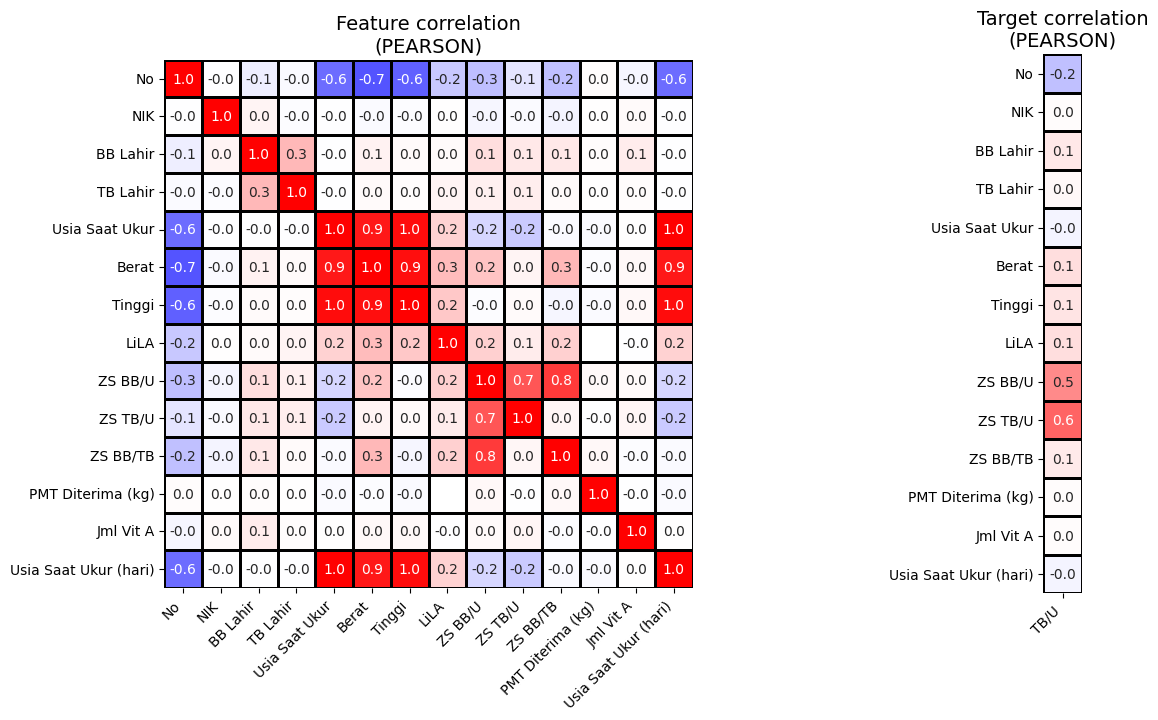
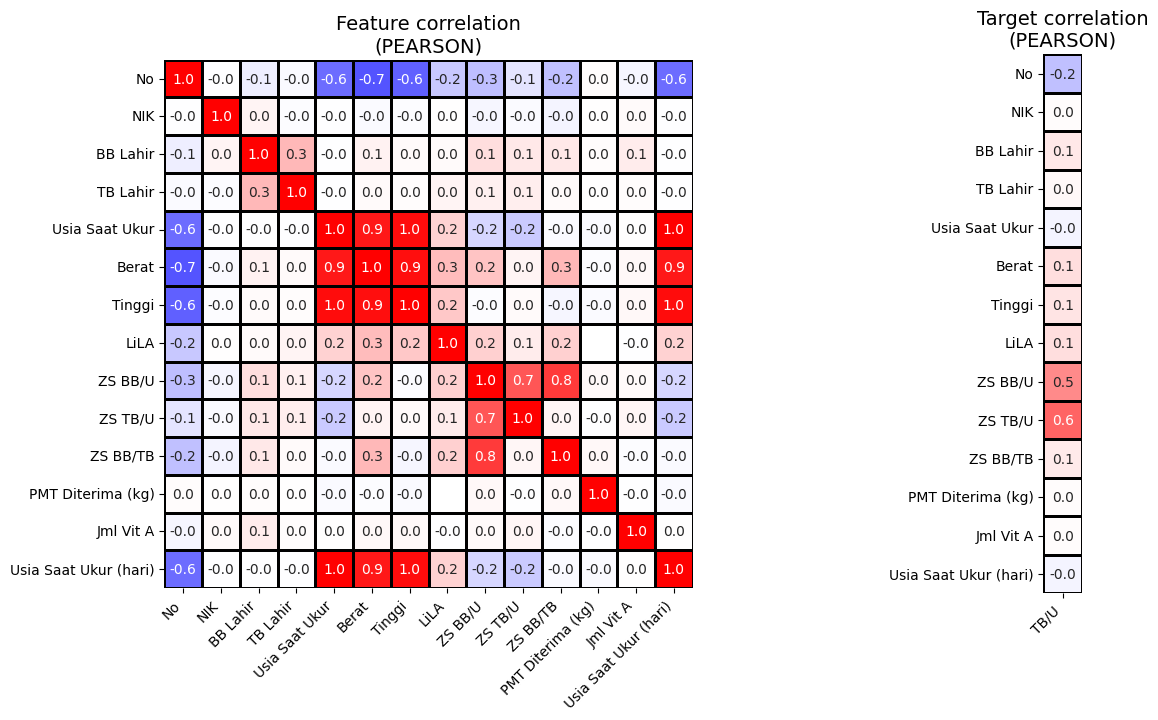

<Axes: xlabel='ZS TB/U', ylabel='TB/U'>

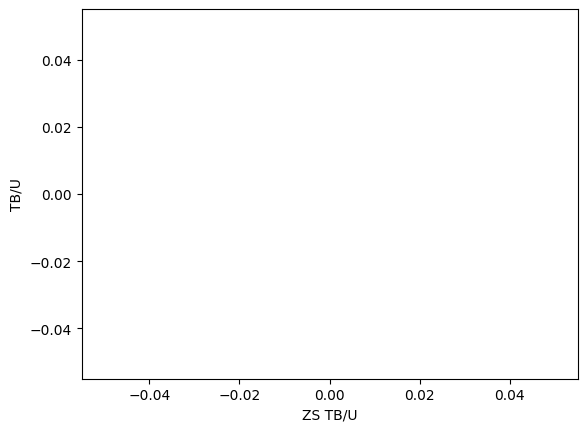

time: 159 ms (started: 2025-10-28 14:15:53 +00:00)


In [59]:
sns.regplot(data=df_encoded, x='ZS TB/U', y='TB/U', color='darkgreen')

<Axes: xlabel='ZS BB/U', ylabel='TB/U'>

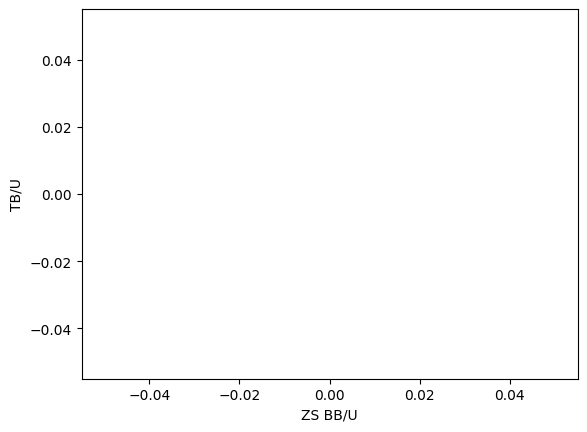

time: 156 ms (started: 2025-10-28 14:15:54 +00:00)


In [60]:
sns.regplot(data=df_encoded, x='ZS BB/U', y='TB/U', color='darkblue')

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Distribution of Height-for-Age Z-Score (ZS TB/U) by Height-for-Age Category (TB/U)')

/tmp/ipykernel_37/236779597.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


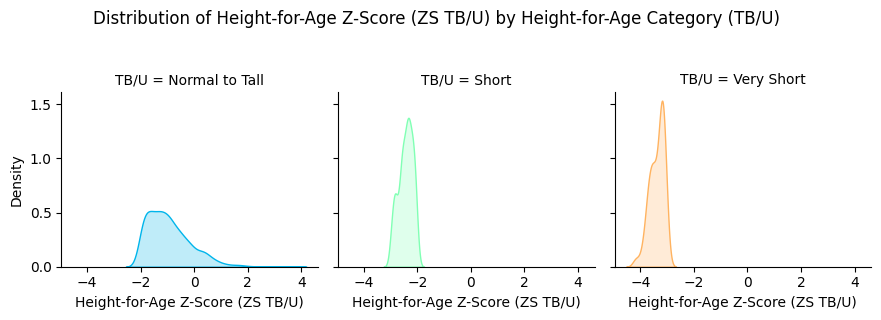

time: 723 ms (started: 2025-10-28 14:15:54 +00:00)


In [61]:
# Buat FacetGrid untuk distribusi Z-score Height-for-Age berdasarkan kategori Height-for-Age
g = sns.FacetGrid(df, col='TB/U', hue='TB/U', palette='rainbow')
g.map(sns.kdeplot, 'ZS TB/U', fill=True)

# Ubah judul dan label sumbu ke bahasa Inggris
g.fig.suptitle('Distribution of Height-for-Age Z-Score (ZS TB/U) by Height-for-Age Category (TB/U)', y=1.05)
g.set_axis_labels('Height-for-Age Z-Score (ZS TB/U)', 'Density')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Distribution of Height-for-Age Z-Score (ZS TB/U) by Height-for-Age Category (TB/U)')

Text(0.5, 9.444444444444438, 'Height-for-Age Z-Score (ZS TB/U)')

Text(18.68897222222222, 0.5, 'Density')

/tmp/ipykernel_37/2971161200.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


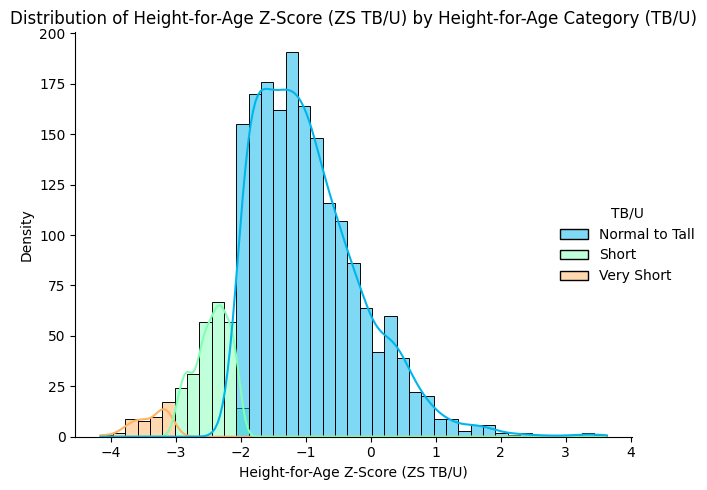

time: 668 ms (started: 2025-10-28 14:15:55 +00:00)


In [62]:
# Buat distribusi plot untuk Height-for-Age Z-Score berdasarkan kategori TB/U
sns.displot(data=df, x='ZS TB/U', hue='TB/U', kde=True, palette='rainbow')

# Tambahkan judul dan label sumbu dalam bahasa Inggris
plt.title('Distribution of Height-for-Age Z-Score (ZS TB/U) by Height-for-Age Category (TB/U)')
plt.xlabel('Height-for-Age Z-Score (ZS TB/U)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.05, 'Distribution of Weight-for-Age Z-Score (ZS BB/U) by Height-for-Age Category (TB/U)')

/tmp/ipykernel_37/920772908.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


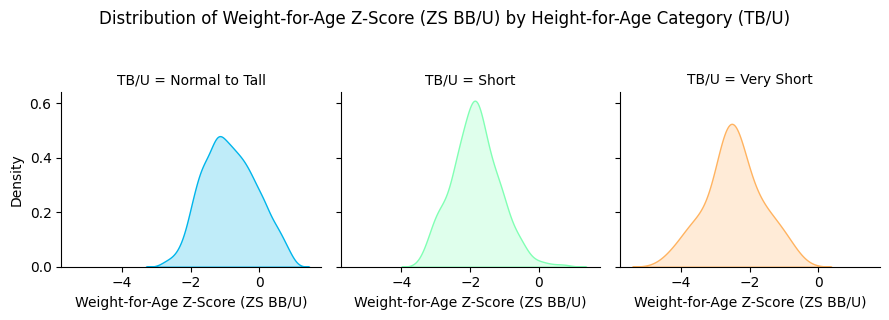

time: 877 ms (started: 2025-10-28 14:15:55 +00:00)


In [63]:
# Buat FacetGrid untuk distribusi Z-score Weight-for-Age berdasarkan kategori Height-for-Age
g = sns.FacetGrid(df, col='TB/U', hue='TB/U', palette='rainbow')
g.map(sns.kdeplot, 'ZS BB/U', fill=True)

# Ubah judul dan label sumbu ke bahasa Inggris
g.fig.suptitle('Distribution of Weight-for-Age Z-Score (ZS BB/U) by Height-for-Age Category (TB/U)', y=1.05)
g.set_axis_labels('Weight-for-Age Z-Score (ZS BB/U)', 'Density')

plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-l

Text(0.5, 1.0, 'Distribution of ZS BB/U by TB/U')

Text(0.5, 9.444444444444438, 'ZS BB/U')

Text(18.68897222222222, 0.5, 'Density')

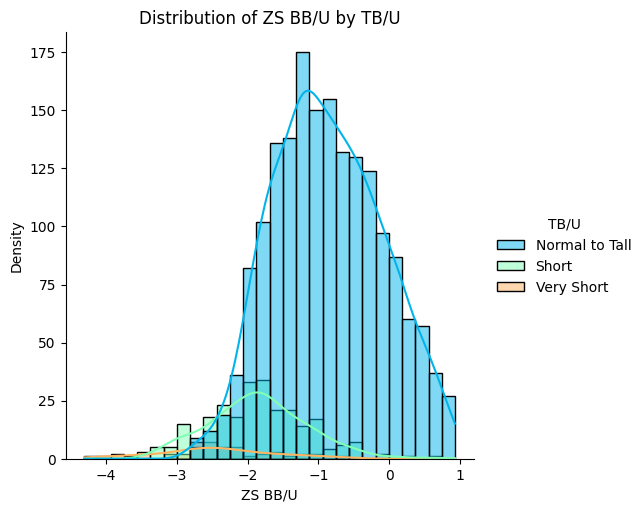

time: 567 ms (started: 2025-10-28 14:15:56 +00:00)


In [64]:
sns.displot(data=df, x='ZS BB/U', hue='TB/U', kde=True, palette='rainbow')

plt.title('Distribution of ZS BB/U by TB/U')
plt.xlabel('ZS BB/U')
plt.ylabel('Density')
plt.show()

### 3.4.2. Association Matrix (Categoric vs Target)

In [65]:
plot_association_matrix(df.drop(['Prov', 'Kab/Kota', 'Kec', 'Pukesmas', 'KPSP', 'KIA', 'Detail'], axis=1, inplace=False), target_col='TB/U', categoric_col='auto')

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

time: 2.42 s (started: 2025-10-28 14:15:57 +00:00)


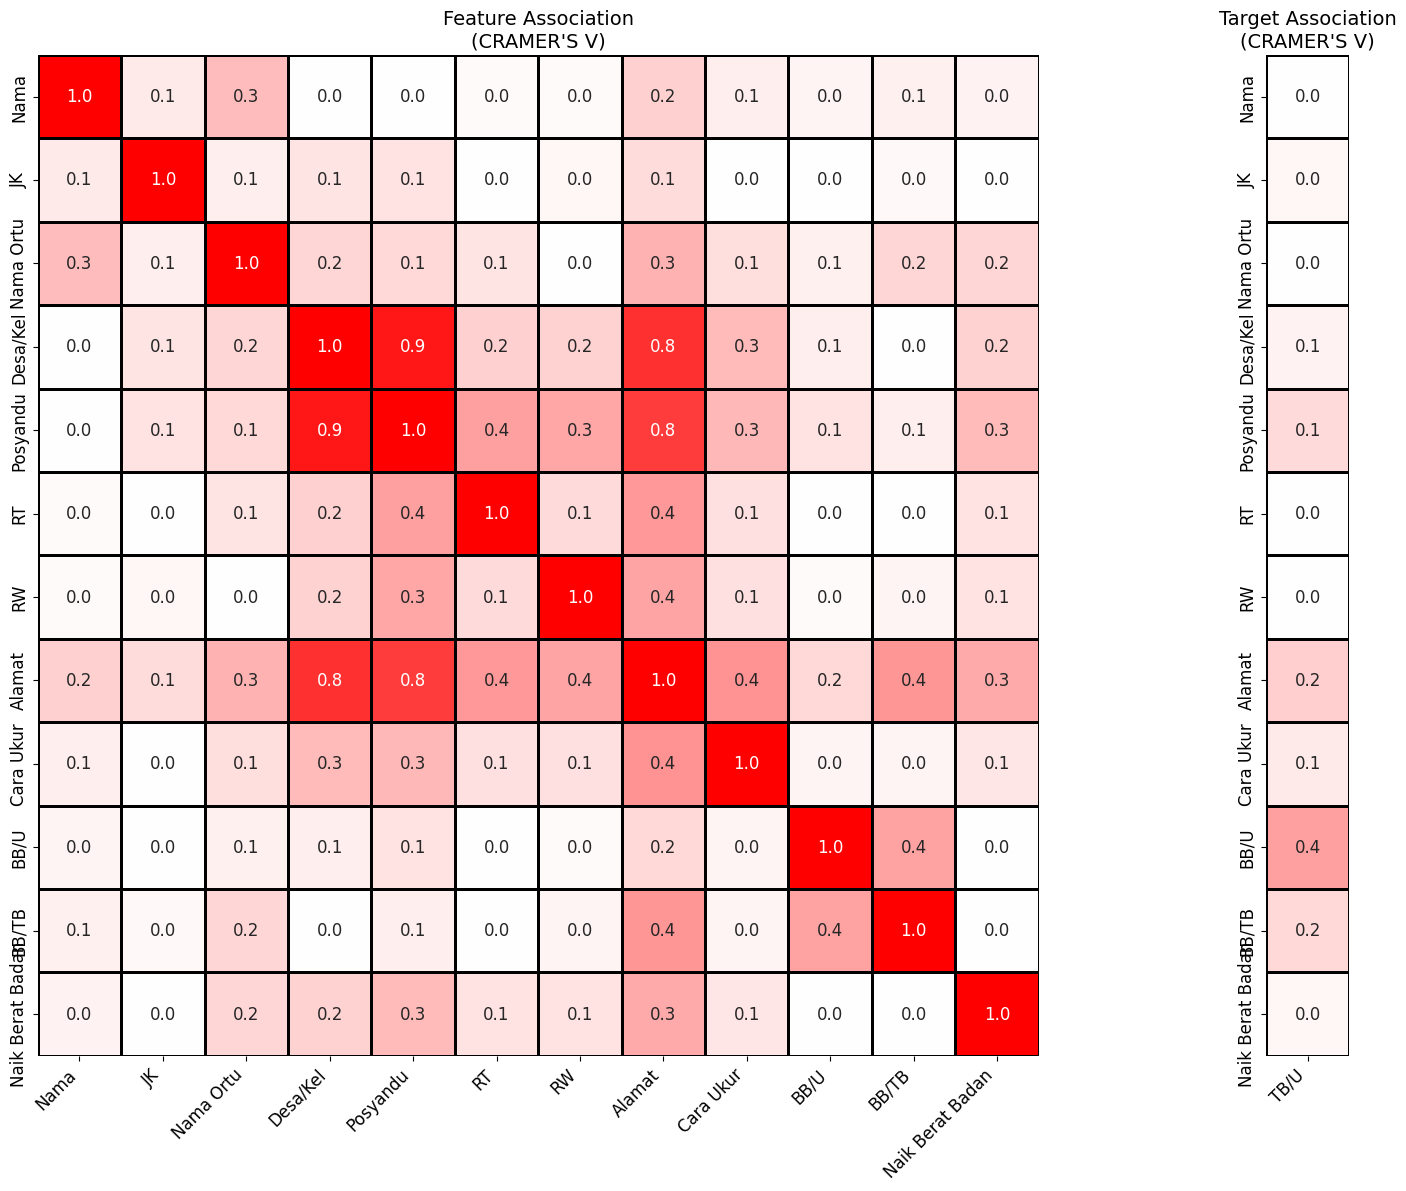
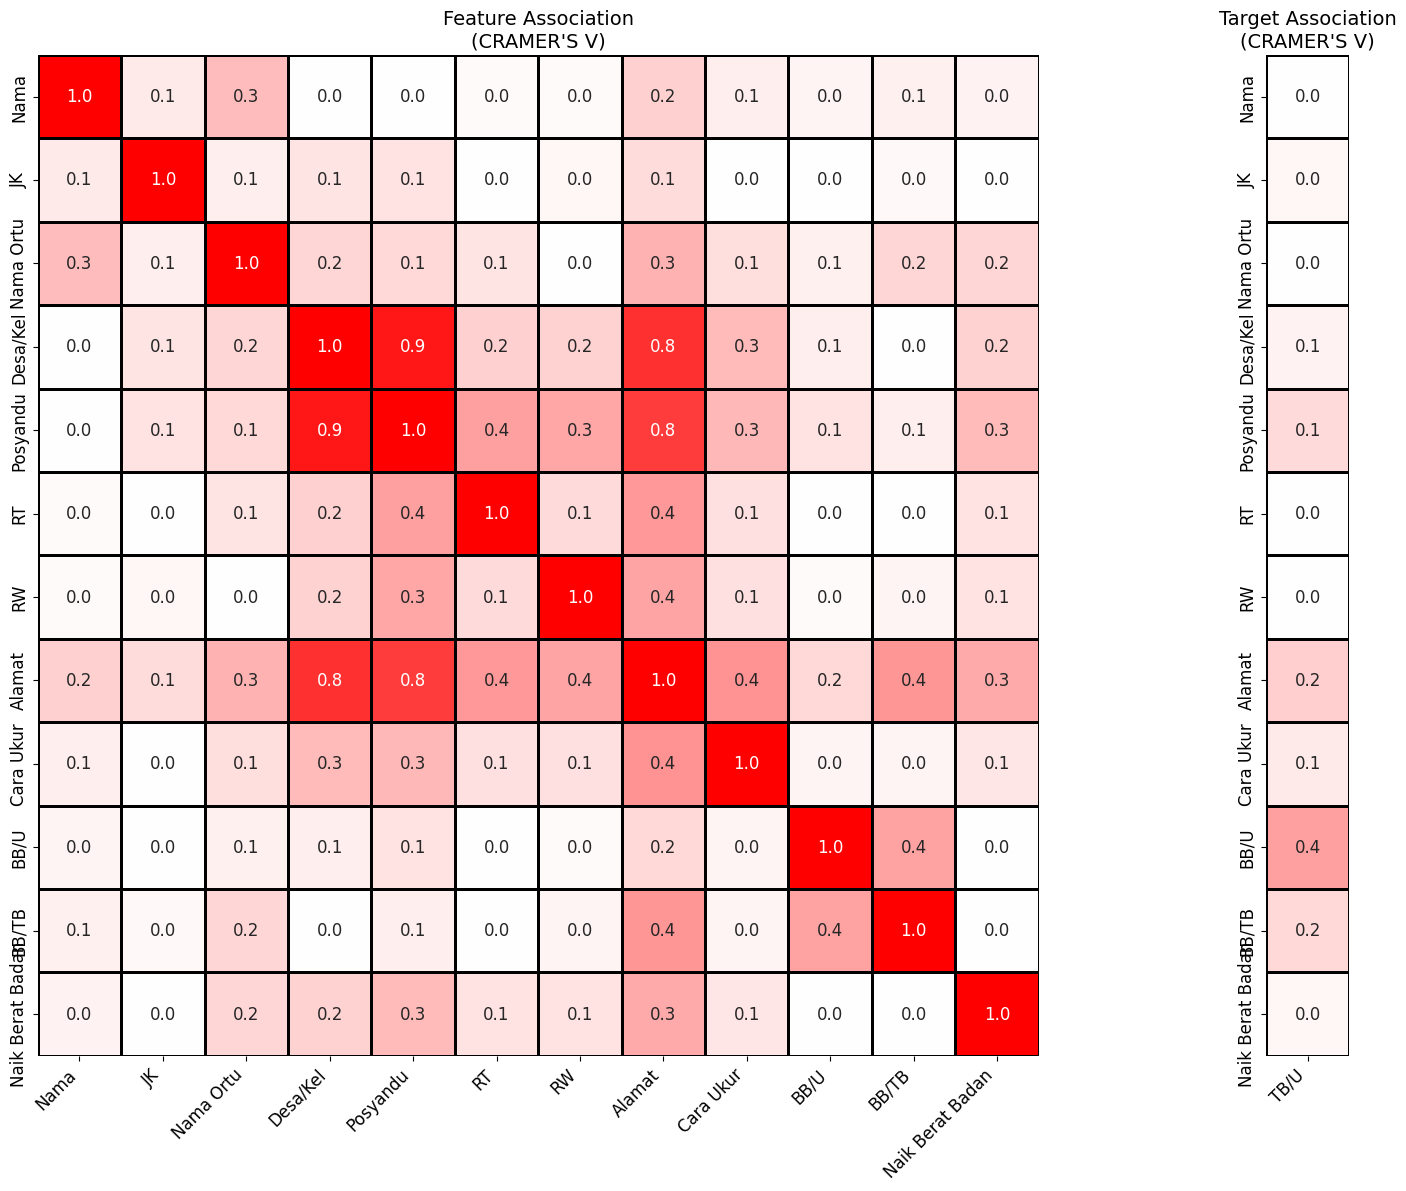

<Axes: xlabel='JK', ylabel='count'>

<Axes: xlabel='Posyandu', ylabel='count'>

<Axes: xlabel='Cara Ukur', ylabel='count'>

<Axes: xlabel='BB/U', ylabel='count'>

<Axes: xlabel='BB/TB', ylabel='count'>

<Axes: xlabel='Naik Berat Badan', ylabel='count'>

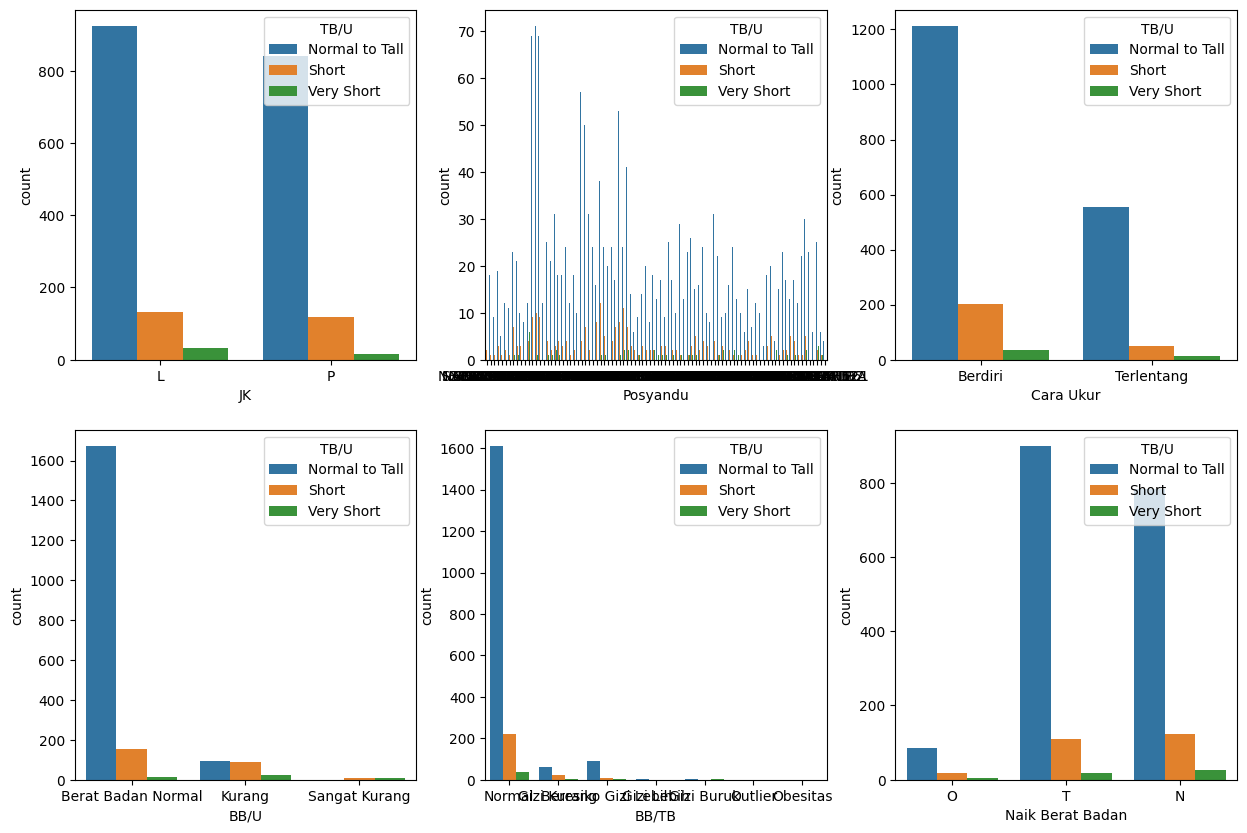

time: 2.37 s (started: 2025-10-28 14:15:59 +00:00)


In [66]:
cat_cols = ['JK', 'Posyandu', 'Cara Ukur', 'BB/U', 'BB/TB', 'Naik Berat Badan']

fig, axes = plt.subplots(2, 3, figsize=(15,10))
for cat, ax in zip(cat_cols, axes.flatten()):
    sns.countplot(x=cat, data=df, hue='TB/U', ax=ax)

## 3.5. Data Preparation Before Splitting

### 3.5.1. Handling Missing "Jml Vit A"

In [67]:
# df['Jml Vit A'].value_counts()
# df['Jml Vit A'] = df['Jml Vit A'].fillna(0)
# df['Jml Vit A'].value_counts()

time: 353 µs (started: 2025-10-28 14:16:01 +00:00)


### 3.5.2. Handling Missing "PMT Diterima (kg)"

In [68]:
# df['PMT Diterima (kg)'].value_counts()
# df['PMT Diterima (kg)'] = df['PMT Diterima (kg)'].fillna(0)
# df['PMT Diterima (kg)'].value_counts()

time: 14 ms (started: 2025-10-28 14:16:01 +00:00)


### 3.5.3. Handling low value counts BB/TB  

In [69]:
print(df['BB/TB'].value_counts())

BB/TB
Normal                 1865
Beresiko Gizi Lebih     100
Gizi Kurang              88
Gizi Lebih                4
Gizi Buruk                4
Outlier                   1
Obesitas                  1
Name: count, dtype: int64
time: 13.6 ms (started: 2025-10-28 14:16:01 +00:00)


In [70]:
df['BB/TB'] = df['BB/TB'].replace({
    'Outlier': 'Gizi Lebih',
    'Obesitas': 'Gizi Lebih'
})

print(df['BB/TB'].value_counts())

BB/TB
Normal                 1865
Beresiko Gizi Lebih     100
Gizi Kurang              88
Gizi Lebih                6
Gizi Buruk                4
Name: count, dtype: int64
time: 15.3 ms (started: 2025-10-28 14:16:02 +00:00)


# 4. Splitting Dataset & Label Encoding

In [71]:
df.nunique()

No                       2063
NIK                      2063
Nama                     2046
JK                          2
Tgl Lahir                1223
BB Lahir                   29
TB Lahir                   26
Nama Ortu                1889
Prov                        1
Kab/Kota                    1
Kec                         1
Pukesmas                    1
Desa/Kel                   14
Posyandu                   90
RT                         51
RW                         13
Alamat                    606
Usia Saat Ukur           1204
Tanggal Pengukuran         18
Berat                     178
Tinggi                    341
Cara Ukur                   2
LiLA                       52
BB/U                        3
ZS BB/U                   379
TB/U                        3
ZS TB/U                   433
BB/TB                       5
ZS BB/TB                  428
Naik Berat Badan            3
PMT Diterima (kg)           1
Jml Vit A                   1
KPSP                        1
KIA       

time: 21.5 ms (started: 2025-10-28 14:16:02 +00:00)


In [72]:
# --- TARGET ---
target = ['TB/U']

# --- NON-FEATURES ---
non_features = [
    'ZS TB/U', 'No', 'NIK', 'Nama', 'Tgl Lahir', 'Nama Ortu',
    'Prov', 'Kab/Kota', 'Kec', 'Pukesmas', 'Alamat',
    'RT', 'RW', 'KPSP', 'KIA', 'Detail',
    'Usia Saat Ukur', 'Tanggal Pengukuran',
    'PMT Diterima (kg)', 'Jml Vit A']  # kolom konstan (hanya 1 nilai)
print(f'Non Features: {non_features}\n')

# --- FITUR ---
features = [col for col in df.columns if col not in non_features + target]
print(f'Features: {features}\n')

# --- KOLOM TANGGAL ---
date_cols = ['Tgl Lahir', 'Tanggal Pengukuran']
print(f'Date columns: {date_cols}\n')

# --- KOLOM KATEGORIK ---
cat_cols = [
    'JK',               # 2 kategori
    'Desa/Kel',         # 14 kategori
    'Posyandu',         # 90 kategori
    'Cara Ukur',        # 2 kategori
    'BB/U',             # 3 kategori
    'BB/TB',            # 5 kategori
    'Naik Berat Badan'  # 3 kategori
]
print(f'Categoric Columns: {cat_cols}\n')

# --- KOLOM NUMERIK ---
num_cols = [col for col in df.columns if col in features and col not in cat_cols and col not in target]
print(f'Numeric Columns: {num_cols}\n')


# --- KATEGORI HIGH & LOW CARDINALITY ---
# High-card dan low-card dari non_features
high_card = [col for col in cat_cols if col in features and col not in target and df[col].nunique() > 5]
print(f'High Cardinality Categoric: {high_card}\n')
low_card = [col for col in cat_cols if col in features and col not in target and df[col].nunique() <= 5]
print(f'Low Cardinality Categoric: {low_card}\n')

Non Features: ['ZS TB/U', 'No', 'NIK', 'Nama', 'Tgl Lahir', 'Nama Ortu', 'Prov', 'Kab/Kota', 'Kec', 'Pukesmas', 'Alamat', 'RT', 'RW', 'KPSP', 'KIA', 'Detail', 'Usia Saat Ukur', 'Tanggal Pengukuran', 'PMT Diterima (kg)', 'Jml Vit A']

Features: ['JK', 'BB Lahir', 'TB Lahir', 'Desa/Kel', 'Posyandu', 'Berat', 'Tinggi', 'Cara Ukur', 'LiLA', 'BB/U', 'ZS BB/U', 'BB/TB', 'ZS BB/TB', 'Naik Berat Badan', 'Usia Saat Ukur (hari)']

Date columns: ['Tgl Lahir', 'Tanggal Pengukuran']

Categoric Columns: ['JK', 'Desa/Kel', 'Posyandu', 'Cara Ukur', 'BB/U', 'BB/TB', 'Naik Berat Badan']

Numeric Columns: ['BB Lahir', 'TB Lahir', 'Berat', 'Tinggi', 'LiLA', 'ZS BB/U', 'ZS BB/TB', 'Usia Saat Ukur (hari)']

High Cardinality Categoric: ['Desa/Kel', 'Posyandu']

Low Cardinality Categoric: ['JK', 'Cara Ukur', 'BB/U', 'BB/TB', 'Naik Berat Badan']

time: 6.9 ms (started: 2025-10-28 14:16:02 +00:00)


In [73]:
X = df[features]
y = df[target].values.ravel() 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_train.shape

((1650, 15), (413, 15), (1650,), (1650,))

time: 22.6 ms (started: 2025-10-28 14:16:02 +00:00)


In [74]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Label Mapping:", label_mapping)

Label Mapping: {'Normal to Tall': 0, 'Short': 1, 'Very Short': 2}
time: 8.71 ms (started: 2025-10-28 14:16:02 +00:00)


# 5. Preprocessing Pipeline

In [75]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(impute='knn', poly=2, transform=None, scaling='minmax', memory=None, n_neighbors=5, weights='uniform'), num_cols),
    ('low_card_cols', cat_pipe(impute='most_frequent', encoder='onehot', memory=False), low_card),
    ('high_card_cols', cat_pipe(impute='most_frequent', encoder='ordinal', memory=False), high_card),
], verbose=False)

preprocessor

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('imputer', KNNImputer()),
                                                 ('poly', PolynomialFeatures()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['BB Lahir', 'TB Lahir', 'Berat', 'Tinggi',
                                  'LiLA', 'ZS BB/U', 'ZS BB/TB',
                                  'Usia Saat Ukur (hari)']),
                                ('low_card_cols',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['JK', 'Cara Ukur', 'BB/U', 'BB/TB',
                                  'Naik Berat Badan']),
                                ('high_card_cols',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ordinal',
                                                  OrdinalEncoder())]),
                                 ['Desa/Kel', 'Posyandu'])])

time: 46.6 ms (started: 2025-10-28 14:16:02 +00:00)


# 6. SMOTE

## 6.1. SMOTE Pipeline (ImbPipeline)

In [76]:
smote_preprocessor = ImbPipeline([
    ('prep', preprocessor),
    ('smote', SMOTE(random_state=42, sampling_strategy='not majority'))
])

smote_preprocessor

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('smote',
                 SMOTE(random_state=42, sampling_strategy='not majority'))])

time: 82.3 ms (started: 2025-10-28 14:16:02 +00:00)


## 6.2. Visualize SMOTE Data

Text(0.0, 1412.0, '1412')

Text(1.0, 200.0, '200')

Text(2.0, 38.0, '38')

Text(0.5, 1.0, 'Label Distribution Before SMOTE on Training Data')

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

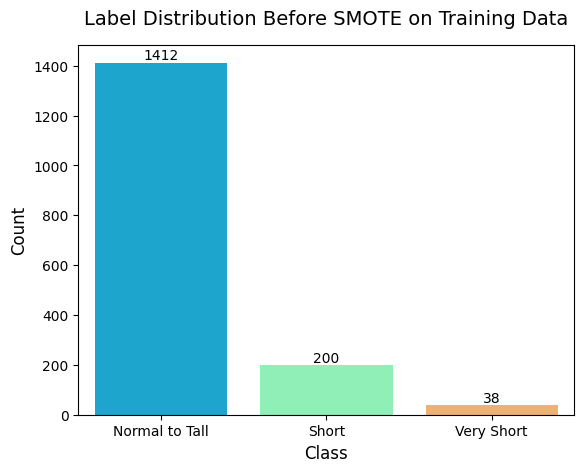

time: 175 ms (started: 2025-10-28 14:16:02 +00:00)


In [77]:
ax = sns.countplot(
    x=y_train,
    order=['Normal to Tall', 'Short', 'Very Short'],
    palette='rainbow'
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{round(height)}',                               # Count text
        (p.get_x() + p.get_width() / 2, height),          # Position
        ha='center', va='bottom'                          # Center-align above bar
    )

plt.title('Label Distribution Before SMOTE on Training Data', fontsize=14, pad=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


In [78]:
# 1. Transform data dengan preprocessor
X_preprocessed = preprocessor.fit_transform(X_train)

# 2. Terapkan SMOTE
smote = SMOTE(random_state=42, sampling_strategy='not majority')
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y_train)

# 3. Konversi ke DataFrame (opsional)
import pandas as pd
X_res_df = pd.DataFrame(X_resampled)
y_res_df = pd.Series(y_resampled, name='Target')

# 4. Gabung hasilnya jika ingin lihat
resampled_df = pd.concat([X_res_df, y_res_df], axis=1)

time: 159 ms (started: 2025-10-28 14:16:02 +00:00)


Text(0.0, 1412.0, '1412')

Text(1.0, 1412.0, '1412')

Text(2.0, 1412.0, '1412')

Text(0.5, 1.0, 'Label Distribution After SMOTE on Training Data')

Text(0.5, 0, 'Class')

Text(0, 0.5, 'Count')

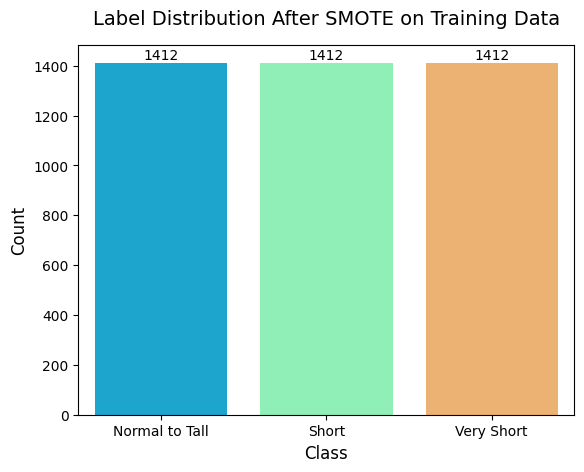

time: 164 ms (started: 2025-10-28 14:16:02 +00:00)


In [79]:
ax = sns.countplot(
    x=y_res_df,
    order=['Normal to Tall', 'Short', 'Very Short'],
    palette='rainbow'
)

for p in ax.patches:
    height = p.get_height()
    ax.annotate(
        f'{round(height)}',                               # Count text
        (p.get_x() + p.get_width() / 2, height),          # Position
        ha='center', va='bottom'                          # Center-align above bar
    )

plt.title('Label Distribution After SMOTE on Training Data', fontsize=14, pad=15)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show()


# 7. Model Pipeline


## 7.1. Base Logistic Regression (without & with SMOTE)

In [80]:
lr_pipe = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression())
])

lr_pipe

lr_pipe_smote = ImbPipeline([
    *smote_preprocessor.steps,
    ('algo', LogisticRegression())
])

lr_pipe_smote

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('algo', LogisticRegression())])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('smote',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', LogisticRegression())])

time: 153 ms (started: 2025-10-28 14:16:02 +00:00)


## 7.2. Base k-Nearest Neighbors (without & with SMOTE)

In [81]:
knn_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', KNeighborsClassifier())
])

knn_pipe

knn_pipe_smote = ImbPipeline([
    *smote_preprocessor.steps,
    ('algo', KNeighborsClassifier())
])

knn_pipe_smote

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('algo', KNeighborsClassifier())])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('smote',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', KNeighborsClassifier())])

time: 155 ms (started: 2025-10-28 14:16:02 +00:00)


## 7.3. Base Support Vector Machine (without & with SMOTE)

In [82]:
svm_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', SVC())
])

svm_pipe

svm_pipe_smote = ImbPipeline([
    *smote_preprocessor.steps,
    ('algo', SVC())
])

svm_pipe_smote

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('algo', SVC())])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('smote',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', SVC())])

time: 165 ms (started: 2025-10-28 14:16:03 +00:00)


## 7.4. Base Random Forest (without & with SMOTE)

In [83]:
rf_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', RandomForestClassifier())
])

rf_pipe

rf_pipe_smote = ImbPipeline([
    *smote_preprocessor.steps,
    ('algo', RandomForestClassifier())
])

rf_pipe_smote

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('algo', RandomForestClassifier())])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['JK', 'Cara Ukur', 'BB/U',
                                                   'BB/TB',
                                                   'Naik Berat Badan']),
                                                 ('high_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ordinal',
                                                                   OrdinalEncoder())]),
                                                  ['Desa/Kel', 'Posyandu'])])),
                ('smote',
                 SMOTE(random_state=42, sampling_strategy='not majority')),
                ('algo', RandomForestClassifier())])

time: 158 ms (started: 2025-10-28 14:16:03 +00:00)


## 7.5. Base XGBoost (without & with SMOTE)

In [84]:
xgb_pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('algo', XGBClassifier())
])

xgb_pipe

xgb_pipe_smote = ImbPipeline([
    *smote_preprocessor.steps,
    ('algo', XGBClassifier())
])

xgb_pipe_smote

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('on...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('poly',
                                                                   PolynomialFeatures()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['BB Lahir', 'TB Lahir',
                                                   'Berat', 'Tinggi', 'LiLA',
                                                   'ZS BB/U', 'ZS BB/TB',
                                                   'Usia Saat Ukur (hari)']),
                                                 ('low_card_cols',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   On...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

time: 170 ms (started: 2025-10-28 14:16:03 +00:00)


# 8. Model Training, Hyperparameter Tuning, Cross-Validation, & Save Models

In [85]:
def train_and_evaluate(pipe, X_train, y_train, X_test, y_test, average='macro', model_name='model'):

    # Training
    model = pipe.fit(X_train, y_train)

    # Prediksi
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Metrik Train
    train_metrics = {
        'Accuracy': accuracy_score(y_train, y_pred_train),
        'F1': f1_score(y_train, y_pred_train, average=average),
        'Precision': precision_score(y_train, y_pred_train, average=average),
        'Recall': recall_score(y_train, y_pred_train, average=average)
    }

    # Metrik Test
    test_metrics = {
        'Accuracy': accuracy_score(y_test, y_pred_test),
        'F1': f1_score(y_test, y_pred_test, average=average),
        'Precision': precision_score(y_test, y_pred_test, average=average),
        'Recall': recall_score(y_test, y_pred_test, average=average)
    }

    # Tampilkan hasil
    print(f"\n=== {model_name} METRICS ===\n")
    print("Train Metrics:")
    for k, v in train_metrics.items():
        if k == 'F1':
           print(f"> {k}:\t\t{v:.4f} ({v:.2f}%)")
        else:
            print(f"> {k}:\t{v:.4f} ({v:.2f}%)")

    print("\nTest Metrics:")
    for k, v in test_metrics.items():
        if k == 'F1':
           print(f"> {k}:\t\t{v:.4f} ({v:.2f}%)")
        else:
            print(f"> {k}:\t{v:.4f} ({v:.2f}%)")
    print()
    
    return y_pred_train, y_pred_test, model

time: 1.65 ms (started: 2025-10-28 14:16:03 +00:00)


In [86]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

time: 14.6 ms (started: 2025-10-28 14:16:03 +00:00)


## 8.1. Logistic Regression

In [87]:
model_name = 'LOGISTIC-REGRESSION'

time: 11.1 ms (started: 2025-10-28 14:16:03 +00:00)


### 8.1.1. Base Model (Without & With SMOTE)

In [88]:
lr_y_pred_train, lr_y_pred_test, lr_model = train_and_evaluate(lr_pipe, X_train, y_train, X_test, y_test, average='macro', model_name=f'{model_name} (NON-SMOTE)')
lr_smote_y_pred_train, lr_smote_pred_test, lr_smote_model = train_and_evaluate(lr_pipe_smote, X_train, y_train, X_test, y_test, average='macro', model_name=f'{model_name} (SMOTE)')

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== LOGISTIC-REGRESSION (NON-SMOTE) METRICS ===

Train Metrics:
> Accuracy:	0.9061 (0.91%)
> F1:		0.5858 (0.59%)
> Precision:	0.7299 (0.73%)
> Recall:	0.5285 (0.53%)

Test Metrics:
> Accuracy:	0.9056 (0.91%)
> F1:		0.5375 (0.54%)
> Precision:	0.6229 (0.62%)
> Recall:	0.5000 (0.50%)


=== LOGISTIC-REGRESSION (SMOTE) METRICS ===

Train Metrics:
> Accuracy:	0.8570 (0.86%)
> F1:		0.6542 (0.65%)
> Precision:	0.5977 (0.60%)
> Recall:	0.7844 (0.78%)

Test Metrics:
> Accuracy:	0.8862 (0.89%)
> F1:		0.7200 (0.72%)
> Precision:	0.6625 (0.66%)
> Recall:	0.8259 (0.83%)

time: 1.53 s (started: 2025-10-28 14:16:03 +00:00)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### 8.1.2. Hyperparameter Tuning & Cross-Validation

In [89]:
lr_model_tuned = GridSearchCV(lr_pipe_smote, gsp.logreg_params, cv=3, n_jobs=1, verbose=10)
lr_model_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 14 candidates, totalling 42 fits
[CV 1/3; 1/14] START algo__C=0.001, algo__fit_intercept=True....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 1/14] END algo__C=0.001, algo__fit_intercept=True;, score=0.762 total time=   0.6s
[CV 2/3; 1/14] START algo__C=0.001, algo__fit_intercept=True....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 1/14] END algo__C=0.001, algo__fit_intercept=True;, score=nan total time=   0.5s
[CV 3/3; 1/14] START algo__C=0.001, algo__fit_intercept=True....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 1/14] END algo__C=0.001, algo__fit_intercept=True;, score=0.676 total time=   0.5s
[CV 1/3; 2/14] START algo__C=0.001, algo__fit_intercept=False...................
[CV 1/3; 2/14] END algo__C=0.001, algo__fit_intercept=False;, score=0.784 total time=   0.4s
[CV 2/3; 2/14] START algo__C=0.001, algo__fit_intercept=False...................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 2/14] END algo__C=0.001, algo__fit_intercept=False;, score=nan total time=   0.5s
[CV 3/3; 2/14] START algo__C=0.001, algo__fit_intercept=False...................
[CV 3/3; 2/14] END algo__C=0.001, algo__fit_intercept=False;, score=0.673 total time=   0.6s
[CV 1/3; 3/14] START algo__C=0.01, algo__fit_intercept=True.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 3/14] END algo__C=0.01, algo__fit_intercept=True;, score=0.835 total time=   0.6s
[CV 2/3; 3/14] START algo__C=0.01, algo__fit_intercept=True.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 3/14] END algo__C=0.01, algo__fit_intercept=True;, score=nan total time=   0.6s
[CV 3/3; 3/14] START algo__C=0.01, algo__fit_intercept=True.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 3/14] END algo__C=0.01, algo__fit_intercept=True;, score=0.816 total time=   0.5s
[CV 1/3; 4/14] START algo__C=0.01, algo__fit_intercept=False....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 4/14] END algo__C=0.01, algo__fit_intercept=False;, score=0.840 total time=   0.7s
[CV 2/3; 4/14] START algo__C=0.01, algo__fit_intercept=False....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 4/14] END algo__C=0.01, algo__fit_intercept=False;, score=nan total time=   0.7s
[CV 3/3; 4/14] START algo__C=0.01, algo__fit_intercept=False....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 4/14] END algo__C=0.01, algo__fit_intercept=False;, score=0.811 total time=   0.9s
[CV 1/3; 5/14] START algo__C=0.1, algo__fit_intercept=True......................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 5/14] END algo__C=0.1, algo__fit_intercept=True;, score=0.851 total time=   0.5s
[CV 2/3; 5/14] START algo__C=0.1, algo__fit_intercept=True......................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 5/14] END algo__C=0.1, algo__fit_intercept=True;, score=nan total time=   0.7s
[CV 3/3; 5/14] START algo__C=0.1, algo__fit_intercept=True......................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 5/14] END algo__C=0.1, algo__fit_intercept=True;, score=0.855 total time=   0.7s
[CV 1/3; 6/14] START algo__C=0.1, algo__fit_intercept=False.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 6/14] END algo__C=0.1, algo__fit_intercept=False;, score=0.847 total time=   0.5s
[CV 2/3; 6/14] START algo__C=0.1, algo__fit_intercept=False.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 6/14] END algo__C=0.1, algo__fit_intercept=False;, score=nan total time=   0.6s
[CV 3/3; 6/14] START algo__C=0.1, algo__fit_intercept=False.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 6/14] END algo__C=0.1, algo__fit_intercept=False;, score=0.836 total time=   0.5s
[CV 1/3; 7/14] START algo__C=1.0, algo__fit_intercept=True......................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 7/14] END algo__C=1.0, algo__fit_intercept=True;, score=0.860 total time=   0.6s
[CV 2/3; 7/14] START algo__C=1.0, algo__fit_intercept=True......................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 7/14] END algo__C=1.0, algo__fit_intercept=True;, score=nan total time=   0.6s
[CV 3/3; 7/14] START algo__C=1.0, algo__fit_intercept=True......................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 7/14] END algo__C=1.0, algo__fit_intercept=True;, score=0.865 total time=   0.5s
[CV 1/3; 8/14] START algo__C=1.0, algo__fit_intercept=False.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 8/14] END algo__C=1.0, algo__fit_intercept=False;, score=0.820 total time=   0.6s
[CV 2/3; 8/14] START algo__C=1.0, algo__fit_intercept=False.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 8/14] END algo__C=1.0, algo__fit_intercept=False;, score=nan total time=   0.5s
[CV 3/3; 8/14] START algo__C=1.0, algo__fit_intercept=False.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 8/14] END algo__C=1.0, algo__fit_intercept=False;, score=0.875 total time=   0.8s
[CV 1/3; 9/14] START algo__C=10.0, algo__fit_intercept=True.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 9/14] END algo__C=10.0, algo__fit_intercept=True;, score=0.851 total time=   0.6s
[CV 2/3; 9/14] START algo__C=10.0, algo__fit_intercept=True.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 9/14] END algo__C=10.0, algo__fit_intercept=True;, score=nan total time=   0.5s
[CV 3/3; 9/14] START algo__C=10.0, algo__fit_intercept=True.....................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 9/14] END algo__C=10.0, algo__fit_intercept=True;, score=0.851 total time=   0.6s
[CV 1/3; 10/14] START algo__C=10.0, algo__fit_intercept=False...................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 10/14] END algo__C=10.0, algo__fit_intercept=False;, score=0.858 total time=   0.7s
[CV 2/3; 10/14] START algo__C=10.0, algo__fit_intercept=False...................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 10/14] END algo__C=10.0, algo__fit_intercept=False;, score=nan total time=   0.8s
[CV 3/3; 10/14] START algo__C=10.0, algo__fit_intercept=False...................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 10/14] END algo__C=10.0, algo__fit_intercept=False;, score=0.864 total time=   0.5s
[CV 1/3; 11/14] START algo__C=100.0, algo__fit_intercept=True...................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 11/14] END algo__C=100.0, algo__fit_intercept=True;, score=0.873 total time=   0.6s
[CV 2/3; 11/14] START algo__C=100.0, algo__fit_intercept=True...................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 11/14] END algo__C=100.0, algo__fit_intercept=True;, score=nan total time=   0.8s
[CV 3/3; 11/14] START algo__C=100.0, algo__fit_intercept=True...................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 11/14] END algo__C=100.0, algo__fit_intercept=True;, score=0.865 total time=   0.6s
[CV 1/3; 12/14] START algo__C=100.0, algo__fit_intercept=False..................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 12/14] END algo__C=100.0, algo__fit_intercept=False;, score=0.849 total time=   0.6s
[CV 2/3; 12/14] START algo__C=100.0, algo__fit_intercept=False..................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 12/14] END algo__C=100.0, algo__fit_intercept=False;, score=nan total time=   0.8s
[CV 3/3; 12/14] START algo__C=100.0, algo__fit_intercept=False..................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 12/14] END algo__C=100.0, algo__fit_intercept=False;, score=0.838 total time=   1.0s
[CV 1/3; 13/14] START algo__C=1000.0, algo__fit_intercept=True..................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 13/14] END algo__C=1000.0, algo__fit_intercept=True;, score=0.867 total time=   0.6s
[CV 2/3; 13/14] START algo__C=1000.0, algo__fit_intercept=True..................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 13/14] END algo__C=1000.0, algo__fit_intercept=True;, score=nan total time=   0.6s
[CV 3/3; 13/14] START algo__C=1000.0, algo__fit_intercept=True..................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 3/3; 13/14] END algo__C=1000.0, algo__fit_intercept=True;, score=0.833 total time=   0.8s
[CV 1/3; 14/14] START algo__C=1000.0, algo__fit_intercept=False.................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/3; 14/14] END algo__C=1000.0, algo__fit_intercept=False;, score=0.869 total time=   0.5s
[CV 2/3; 14/14] START algo__C=1000.0, algo__fit_intercept=False.................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/loc

[CV 2/3; 14/14] END algo__C=1000.0, algo__fit_intercept=False;, score=nan total time=   0.5s
[CV 3/3; 14/14] START algo__C=1000.0, algo__fit_intercept=False.................


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


[CV 3/3; 14/14] END algo__C=1000.0, algo__fit_intercept=False;, score=0.871 total time=   0.5s


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['BB '
                                                                          'Lahir',
                                                                          'TB '
                                                                          'Lahir',
                                                                          'Berat',
                                                                          'Tinggi',
                                                                          'LiLA',
                                                                          'ZS '
                                                                          'BB/U',
                                                                          'ZS '
                                                                          'BB/TB',
                                                                          'Usia '
                                                                          'Saat '
                                                                          'Ukur '
                                                                          '(hari)']),
                                                                        ('low_card_cols',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImput...
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['Desa/Kel',
                                                                          'Posyandu'])])),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('algo', LogisticRegression())]),
             n_jobs=1,
             param_grid={'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'algo__fit_intercept': [True, False]},
             verbose=10)

time: 27.2 s (started: 2025-10-28 14:16:05 +00:00)


In [90]:
lr_model_tuned.best_params_
lr_model_tuned.score(X_train, y_train), lr_model_tuned.best_score_, lr_model_tuned.score(X_test, y_test)

{'algo__C': 0.001, 'algo__fit_intercept': True}

(0.8042424242424242, nan, 0.8280871670702179)

time: 107 ms (started: 2025-10-28 14:16:32 +00:00)


In [91]:
print(f'\nPARAMETER TERBAIK :')
pd.DataFrame(lr_model_tuned.best_params_.items(), columns=['Parameter', 'Value'])
print(f'\nK-Fold Cross Validation History :')
pd.DataFrame(lr_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).head(5)
pd.DataFrame(lr_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).tail(5)


PARAMETER TERBAIK :


Parameter Value
0              algo__C  0.00
1  algo__fit_intercept  True


K-Fold Cross Validation History :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0           0.52          0.06             0.04            0.00   
1           0.43          0.08             0.05            0.02   
2           0.51          0.04             0.04            0.01   
3           0.68          0.10             0.05            0.02   
4           0.62          0.09             0.04            0.00   

   param_algo__C  param_algo__fit_intercept  \
0           0.00                       True   
1           0.00                      False   
2           0.01                       True   
3           0.01                      False   
4           0.10                       True   

                                             params  split0_test_score  \
0   {'algo__C': 0.001, 'algo__fit_intercept': True}               0.76   
1  {'algo__C': 0.001, 'algo__fit_intercept': False}               0.78   
2    {'algo__C': 0.01, 'algo__fit_intercept': True}               0.83   
3   {'algo__C': 0.01, 'algo__fit_intercept': False}               0.84   
4     {'algo__C': 0.1, 'algo__fit_intercept': True}               0.85   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0                NaN               0.68              NaN             NaN   
1                NaN               0.67              NaN             NaN   
2                NaN               0.82              NaN             NaN   
3                NaN               0.81              NaN             NaN   
4                NaN               0.85              NaN             NaN   

   rank_test_score  
0                1  
1                1  
2                1  
3                1  
4                1

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
9            0.64          0.11             0.04            0.01   
10           0.58          0.10             0.07            0.02   
11           0.74          0.13             0.06            0.02   
12           0.60          0.10             0.07            0.02   
13           0.50          0.01             0.04            0.01   

    param_algo__C  param_algo__fit_intercept  \
9           10.00                      False   
10         100.00                       True   
11         100.00                      False   
12       1,000.00                       True   
13       1,000.00                      False   

                                               params  split0_test_score  \
9     {'algo__C': 10.0, 'algo__fit_intercept': False}               0.86   
10    {'algo__C': 100.0, 'algo__fit_intercept': True}               0.87   
11   {'algo__C': 100.0, 'algo__fit_intercept': False}               0.85   
12   {'algo__C': 1000.0, 'algo__fit_intercept': True}               0.87   
13  {'algo__C': 1000.0, 'algo__fit_intercept': False}               0.87   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
9                 NaN               0.86              NaN             NaN   
10                NaN               0.87              NaN             NaN   
11                NaN               0.84              NaN             NaN   
12                NaN               0.83              NaN             NaN   
13                NaN               0.87              NaN             NaN   

    rank_test_score  
9                 1  
10                1  
11                1  
12                1  
13                1

time: 29.5 ms (started: 2025-10-28 14:16:32 +00:00)


In [92]:
save_model(lr_model, model_name+'-BASE-MODEL.pkl', folder_name=model_name)
save_model(lr_smote_model, model_name+'-SMOTE-MODEL.pkl', folder_name=model_name)
save_model(lr_model_tuned, model_name+'-SMOTE-TUNED-MODEL.pkl', folder_name=model_name)
print(f'\nModel {model_name} saved!!!')

Model is pickled as LOGISTIC-REGRESSION/LOGISTIC-REGRESSION-BASE-MODEL.pkl
Model is pickled as LOGISTIC-REGRESSION/LOGISTIC-REGRESSION-SMOTE-MODEL.pkl
Model is pickled as LOGISTIC-REGRESSION/LOGISTIC-REGRESSION-SMOTE-TUNED-MODEL.pkl

Model LOGISTIC-REGRESSION saved!!!
time: 6.3 ms (started: 2025-10-28 14:16:32 +00:00)


## 8.2. k-Nearest Neighbors

In [93]:
model_name = 'K-NEAREST-NEIGHBORS'

time: 6.53 ms (started: 2025-10-28 14:16:32 +00:00)


### 8.2.1. Base Model

In [94]:
knn_y_pred_train, knn_y_pred_test, knn_model = train_and_evaluate(knn_pipe, X_train, y_train_encoded, X_test, y_test_encoded, average='macro', model_name=f'{model_name} (NON-SMOTE)')
knn_smote_y_pred_train, knn_smote_y_pred_test, knn_smote_model = train_and_evaluate(knn_pipe_smote, X_train, y_train_encoded, X_test, y_test_encoded, average='macro', model_name=f'{model_name} (SMOTE)')


=== K-NEAREST-NEIGHBORS (NON-SMOTE) METRICS ===

Train Metrics:
> Accuracy:	0.8764 (0.88%)
> F1:		0.4579 (0.46%)
> Precision:	0.8587 (0.86%)
> Recall:	0.4228 (0.42%)

Test Metrics:
> Accuracy:	0.8547 (0.85%)
> F1:		0.3918 (0.39%)
> Precision:	0.7318 (0.73%)
> Recall:	0.3772 (0.38%)


=== K-NEAREST-NEIGHBORS (SMOTE) METRICS ===

Train Metrics:
> Accuracy:	0.8121 (0.81%)
> F1:		0.7114 (0.71%)
> Precision:	0.6396 (0.64%)
> Recall:	0.9211 (0.92%)

Test Metrics:
> Accuracy:	0.6586 (0.66%)
> F1:		0.3862 (0.39%)
> Precision:	0.3958 (0.40%)
> Recall:	0.4437 (0.44%)

time: 469 ms (started: 2025-10-28 14:16:32 +00:00)


### 8.2.2. Hyperparameter Tuning & Cross-Validation

In [95]:
knn_model_tuned = GridSearchCV(knn_pipe_smote, gsp.knn_params, cv=3, n_jobs=1, verbose=10)
knn_model_tuned.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 90 candidates, totalling 270 fits
[CV 1/3; 1/90] START algo__n_neighbors=1, algo__p=1, algo__weights=uniform......
[CV 1/3; 1/90] END algo__n_neighbors=1, algo__p=1, algo__weights=uniform;, score=0.811 total time=   0.2s
[CV 2/3; 1/90] START algo__n_neighbors=1, algo__p=1, algo__weights=uniform......


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 1/90] END algo__n_neighbors=1, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 1/90] START algo__n_neighbors=1, algo__p=1, algo__weights=uniform......
[CV 3/3; 1/90] END algo__n_neighbors=1, algo__p=1, algo__weights=uniform;, score=0.785 total time=   0.2s
[CV 1/3; 2/90] START algo__n_neighbors=1, algo__p=1, algo__weights=distance.....
[CV 1/3; 2/90] END algo__n_neighbors=1, algo__p=1, algo__weights=distance;, score=0.811 total time=   0.1s
[CV 2/3; 2/90] START algo__n_neighbors=1, algo__p=1, algo__weights=distance.....
[CV 2/3; 2/90] END algo__n_neighbors=1, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 2/90] START algo__n_neighbors=1, algo__p=1, algo__weights=distance.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 2/90] END algo__n_neighbors=1, algo__p=1, algo__weights=distance;, score=0.785 total time=   0.1s
[CV 1/3; 3/90] START algo__n_neighbors=1, algo__p=1.5, algo__weights=uniform....
[CV 1/3; 3/90] END algo__n_neighbors=1, algo__p=1.5, algo__weights=uniform;, score=0.784 total time=   2.1s
[CV 2/3; 3/90] START algo__n_neighbors=1, algo__p=1.5, algo__weights=uniform....
[CV 2/3; 3/90] END algo__n_neighbors=1, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 3/90] START algo__n_neighbors=1, algo__p=1.5, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 3/90] END algo__n_neighbors=1, algo__p=1.5, algo__weights=uniform;, score=0.765 total time=   2.1s
[CV 1/3; 4/90] START algo__n_neighbors=1, algo__p=1.5, algo__weights=distance...
[CV 1/3; 4/90] END algo__n_neighbors=1, algo__p=1.5, algo__weights=distance;, score=0.784 total time=   1.3s
[CV 2/3; 4/90] START algo__n_neighbors=1, algo__p=1.5, algo__weights=distance...
[CV 2/3; 4/90] END algo__n_neighbors=1, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 4/90] START algo__n_neighbors=1, algo__p=1.5, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 4/90] END algo__n_neighbors=1, algo__p=1.5, algo__weights=distance;, score=0.765 total time=   1.2s
[CV 1/3; 5/90] START algo__n_neighbors=1, algo__p=2, algo__weights=uniform......
[CV 1/3; 5/90] END algo__n_neighbors=1, algo__p=2, algo__weights=uniform;, score=0.762 total time=   0.1s
[CV 2/3; 5/90] START algo__n_neighbors=1, algo__p=2, algo__weights=uniform......
[CV 2/3; 5/90] END algo__n_neighbors=1, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 5/90] START algo__n_neighbors=1, algo__p=2, algo__weights=uniform......


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 5/90] END algo__n_neighbors=1, algo__p=2, algo__weights=uniform;, score=0.738 total time=   0.1s
[CV 1/3; 6/90] START algo__n_neighbors=1, algo__p=2, algo__weights=distance.....
[CV 1/3; 6/90] END algo__n_neighbors=1, algo__p=2, algo__weights=distance;, score=0.762 total time=   0.1s
[CV 2/3; 6/90] START algo__n_neighbors=1, algo__p=2, algo__weights=distance.....
[CV 2/3; 6/90] END algo__n_neighbors=1, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 6/90] START algo__n_neighbors=1, algo__p=2, algo__weights=distance.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 6/90] END algo__n_neighbors=1, algo__p=2, algo__weights=distance;, score=0.738 total time=   0.1s
[CV 1/3; 7/90] START algo__n_neighbors=3, algo__p=1, algo__weights=uniform......
[CV 1/3; 7/90] END algo__n_neighbors=3, algo__p=1, algo__weights=uniform;, score=0.793 total time=   0.2s
[CV 2/3; 7/90] START algo__n_neighbors=3, algo__p=1, algo__weights=uniform......


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 7/90] END algo__n_neighbors=3, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 7/90] START algo__n_neighbors=3, algo__p=1, algo__weights=uniform......
[CV 3/3; 7/90] END algo__n_neighbors=3, algo__p=1, algo__weights=uniform;, score=0.742 total time=   0.2s
[CV 1/3; 8/90] START algo__n_neighbors=3, algo__p=1, algo__weights=distance.....
[CV 1/3; 8/90] END algo__n_neighbors=3, algo__p=1, algo__weights=distance;, score=0.800 total time=   0.1s
[CV 2/3; 8/90] START algo__n_neighbors=3, algo__p=1, algo__weights=distance.....
[CV 2/3; 8/90] END algo__n_neighbors=3, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 8/90] START algo__n_neighbors=3, algo__p=1, algo__weights=distance.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 8/90] END algo__n_neighbors=3, algo__p=1, algo__weights=distance;, score=0.745 total time=   0.1s
[CV 1/3; 9/90] START algo__n_neighbors=3, algo__p=1.5, algo__weights=uniform....
[CV 1/3; 9/90] END algo__n_neighbors=3, algo__p=1.5, algo__weights=uniform;, score=0.744 total time=   2.1s
[CV 2/3; 9/90] START algo__n_neighbors=3, algo__p=1.5, algo__weights=uniform....
[CV 2/3; 9/90] END algo__n_neighbors=3, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 9/90] START algo__n_neighbors=3, algo__p=1.5, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 9/90] END algo__n_neighbors=3, algo__p=1.5, algo__weights=uniform;, score=0.698 total time=   2.1s
[CV 1/3; 10/90] START algo__n_neighbors=3, algo__p=1.5, algo__weights=distance..
[CV 1/3; 10/90] END algo__n_neighbors=3, algo__p=1.5, algo__weights=distance;, score=0.751 total time=   1.2s
[CV 2/3; 10/90] START algo__n_neighbors=3, algo__p=1.5, algo__weights=distance..
[CV 2/3; 10/90] END algo__n_neighbors=3, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 10/90] START algo__n_neighbors=3, algo__p=1.5, algo__weights=distance..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 10/90] END algo__n_neighbors=3, algo__p=1.5, algo__weights=distance;, score=0.707 total time=   1.2s
[CV 1/3; 11/90] START algo__n_neighbors=3, algo__p=2, algo__weights=uniform.....
[CV 1/3; 11/90] END algo__n_neighbors=3, algo__p=2, algo__weights=uniform;, score=0.725 total time=   0.1s
[CV 2/3; 11/90] START algo__n_neighbors=3, algo__p=2, algo__weights=uniform.....
[CV 2/3; 11/90] END algo__n_neighbors=3, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 11/90] START algo__n_neighbors=3, algo__p=2, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 11/90] END algo__n_neighbors=3, algo__p=2, algo__weights=uniform;, score=0.665 total time=   0.1s
[CV 1/3; 12/90] START algo__n_neighbors=3, algo__p=2, algo__weights=distance....
[CV 1/3; 12/90] END algo__n_neighbors=3, algo__p=2, algo__weights=distance;, score=0.733 total time=   0.1s
[CV 2/3; 12/90] START algo__n_neighbors=3, algo__p=2, algo__weights=distance....
[CV 2/3; 12/90] END algo__n_neighbors=3, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 12/90] START algo__n_neighbors=3, algo__p=2, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 12/90] END algo__n_neighbors=3, algo__p=2, algo__weights=distance;, score=0.684 total time=   0.1s
[CV 1/3; 13/90] START algo__n_neighbors=5, algo__p=1, algo__weights=uniform.....
[CV 1/3; 13/90] END algo__n_neighbors=5, algo__p=1, algo__weights=uniform;, score=0.744 total time=   0.2s
[CV 2/3; 13/90] START algo__n_neighbors=5, algo__p=1, algo__weights=uniform.....
[CV 2/3; 13/90] END algo__n_neighbors=5, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 13/90] START algo__n_neighbors=5, algo__p=1, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 13/90] END algo__n_neighbors=5, algo__p=1, algo__weights=uniform;, score=0.705 total time=   0.2s
[CV 1/3; 14/90] START algo__n_neighbors=5, algo__p=1, algo__weights=distance....
[CV 1/3; 14/90] END algo__n_neighbors=5, algo__p=1, algo__weights=distance;, score=0.753 total time=   0.1s
[CV 2/3; 14/90] START algo__n_neighbors=5, algo__p=1, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 14/90] END algo__n_neighbors=5, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 14/90] START algo__n_neighbors=5, algo__p=1, algo__weights=distance....
[CV 3/3; 14/90] END algo__n_neighbors=5, algo__p=1, algo__weights=distance;, score=0.713 total time=   0.1s
[CV 1/3; 15/90] START algo__n_neighbors=5, algo__p=1.5, algo__weights=uniform...
[CV 1/3; 15/90] END algo__n_neighbors=5, algo__p=1.5, algo__weights=uniform;, score=0.718 total time=   2.1s
[CV 2/3; 15/90] START algo__n_neighbors=5, algo__p=1.5, algo__weights=uniform...
[CV 2/3; 15/90] END algo__n_neighbors=5, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 15/90] START algo__n_neighbors=5, algo__p=1.5, algo__weights=uniform...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 15/90] END algo__n_neighbors=5, algo__p=1.5, algo__weights=uniform;, score=0.651 total time=   2.1s
[CV 1/3; 16/90] START algo__n_neighbors=5, algo__p=1.5, algo__weights=distance..
[CV 1/3; 16/90] END algo__n_neighbors=5, algo__p=1.5, algo__weights=distance;, score=0.727 total time=   1.2s
[CV 2/3; 16/90] START algo__n_neighbors=5, algo__p=1.5, algo__weights=distance..
[CV 2/3; 16/90] END algo__n_neighbors=5, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 16/90] START algo__n_neighbors=5, algo__p=1.5, algo__weights=distance..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 16/90] END algo__n_neighbors=5, algo__p=1.5, algo__weights=distance;, score=0.658 total time=   1.2s
[CV 1/3; 17/90] START algo__n_neighbors=5, algo__p=2, algo__weights=uniform.....
[CV 1/3; 17/90] END algo__n_neighbors=5, algo__p=2, algo__weights=uniform;, score=0.705 total time=   0.1s
[CV 2/3; 17/90] START algo__n_neighbors=5, algo__p=2, algo__weights=uniform.....
[CV 2/3; 17/90] END algo__n_neighbors=5, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 17/90] START algo__n_neighbors=5, algo__p=2, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 17/90] END algo__n_neighbors=5, algo__p=2, algo__weights=uniform;, score=0.616 total time=   0.1s
[CV 1/3; 18/90] START algo__n_neighbors=5, algo__p=2, algo__weights=distance....
[CV 1/3; 18/90] END algo__n_neighbors=5, algo__p=2, algo__weights=distance;, score=0.727 total time=   0.1s
[CV 2/3; 18/90] START algo__n_neighbors=5, algo__p=2, algo__weights=distance....
[CV 2/3; 18/90] END algo__n_neighbors=5, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 18/90] START algo__n_neighbors=5, algo__p=2, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 18/90] END algo__n_neighbors=5, algo__p=2, algo__weights=distance;, score=0.635 total time=   0.1s
[CV 1/3; 19/90] START algo__n_neighbors=7, algo__p=1, algo__weights=uniform.....
[CV 1/3; 19/90] END algo__n_neighbors=7, algo__p=1, algo__weights=uniform;, score=0.729 total time=   0.2s
[CV 2/3; 19/90] START algo__n_neighbors=7, algo__p=1, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 19/90] END algo__n_neighbors=7, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 19/90] START algo__n_neighbors=7, algo__p=1, algo__weights=uniform.....
[CV 3/3; 19/90] END algo__n_neighbors=7, algo__p=1, algo__weights=uniform;, score=0.678 total time=   0.2s
[CV 1/3; 20/90] START algo__n_neighbors=7, algo__p=1, algo__weights=distance....
[CV 1/3; 20/90] END algo__n_neighbors=7, algo__p=1, algo__weights=distance;, score=0.738 total time=   0.1s
[CV 2/3; 20/90] START algo__n_neighbors=7, algo__p=1, algo__weights=distance....
[CV 2/3; 20/90] END algo__n_neighbors=7, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 20/90] START algo__n_neighbors=7, algo__p=1, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 20/90] END algo__n_neighbors=7, algo__p=1, algo__weights=distance;, score=0.696 total time=   0.1s
[CV 1/3; 21/90] START algo__n_neighbors=7, algo__p=1.5, algo__weights=uniform...
[CV 1/3; 21/90] END algo__n_neighbors=7, algo__p=1.5, algo__weights=uniform;, score=0.700 total time=   2.1s
[CV 2/3; 21/90] START algo__n_neighbors=7, algo__p=1.5, algo__weights=uniform...
[CV 2/3; 21/90] END algo__n_neighbors=7, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 21/90] START algo__n_neighbors=7, algo__p=1.5, algo__weights=uniform...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 21/90] END algo__n_neighbors=7, algo__p=1.5, algo__weights=uniform;, score=0.611 total time=   2.1s
[CV 1/3; 22/90] START algo__n_neighbors=7, algo__p=1.5, algo__weights=distance..
[CV 1/3; 22/90] END algo__n_neighbors=7, algo__p=1.5, algo__weights=distance;, score=0.736 total time=   1.2s
[CV 2/3; 22/90] START algo__n_neighbors=7, algo__p=1.5, algo__weights=distance..
[CV 2/3; 22/90] END algo__n_neighbors=7, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 22/90] START algo__n_neighbors=7, algo__p=1.5, algo__weights=distance..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 22/90] END algo__n_neighbors=7, algo__p=1.5, algo__weights=distance;, score=0.633 total time=   1.2s
[CV 1/3; 23/90] START algo__n_neighbors=7, algo__p=2, algo__weights=uniform.....
[CV 1/3; 23/90] END algo__n_neighbors=7, algo__p=2, algo__weights=uniform;, score=0.676 total time=   0.1s
[CV 2/3; 23/90] START algo__n_neighbors=7, algo__p=2, algo__weights=uniform.....
[CV 2/3; 23/90] END algo__n_neighbors=7, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 23/90] START algo__n_neighbors=7, algo__p=2, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 23/90] END algo__n_neighbors=7, algo__p=2, algo__weights=uniform;, score=0.578 total time=   0.1s
[CV 1/3; 24/90] START algo__n_neighbors=7, algo__p=2, algo__weights=distance....
[CV 1/3; 24/90] END algo__n_neighbors=7, algo__p=2, algo__weights=distance;, score=0.704 total time=   0.1s
[CV 2/3; 24/90] START algo__n_neighbors=7, algo__p=2, algo__weights=distance....
[CV 2/3; 24/90] END algo__n_neighbors=7, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 24/90] START algo__n_neighbors=7, algo__p=2, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 24/90] END algo__n_neighbors=7, algo__p=2, algo__weights=distance;, score=0.607 total time=   0.1s
[CV 1/3; 25/90] START algo__n_neighbors=9, algo__p=1, algo__weights=uniform.....
[CV 1/3; 25/90] END algo__n_neighbors=9, algo__p=1, algo__weights=uniform;, score=0.725 total time=   0.2s
[CV 2/3; 25/90] START algo__n_neighbors=9, algo__p=1, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 25/90] END algo__n_neighbors=9, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 25/90] START algo__n_neighbors=9, algo__p=1, algo__weights=uniform.....
[CV 3/3; 25/90] END algo__n_neighbors=9, algo__p=1, algo__weights=uniform;, score=0.669 total time=   0.2s
[CV 1/3; 26/90] START algo__n_neighbors=9, algo__p=1, algo__weights=distance....
[CV 1/3; 26/90] END algo__n_neighbors=9, algo__p=1, algo__weights=distance;, score=0.740 total time=   0.1s
[CV 2/3; 26/90] START algo__n_neighbors=9, algo__p=1, algo__weights=distance....
[CV 2/3; 26/90] END algo__n_neighbors=9, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 26/90] START algo__n_neighbors=9, algo__p=1, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 26/90] END algo__n_neighbors=9, algo__p=1, algo__weights=distance;, score=0.687 total time=   0.1s
[CV 1/3; 27/90] START algo__n_neighbors=9, algo__p=1.5, algo__weights=uniform...
[CV 1/3; 27/90] END algo__n_neighbors=9, algo__p=1.5, algo__weights=uniform;, score=0.680 total time=   2.1s
[CV 2/3; 27/90] START algo__n_neighbors=9, algo__p=1.5, algo__weights=uniform...
[CV 2/3; 27/90] END algo__n_neighbors=9, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 27/90] START algo__n_neighbors=9, algo__p=1.5, algo__weights=uniform...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 27/90] END algo__n_neighbors=9, algo__p=1.5, algo__weights=uniform;, score=0.598 total time=   2.1s
[CV 1/3; 28/90] START algo__n_neighbors=9, algo__p=1.5, algo__weights=distance..
[CV 1/3; 28/90] END algo__n_neighbors=9, algo__p=1.5, algo__weights=distance;, score=0.716 total time=   1.2s
[CV 2/3; 28/90] START algo__n_neighbors=9, algo__p=1.5, algo__weights=distance..
[CV 2/3; 28/90] END algo__n_neighbors=9, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 28/90] START algo__n_neighbors=9, algo__p=1.5, algo__weights=distance..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 28/90] END algo__n_neighbors=9, algo__p=1.5, algo__weights=distance;, score=0.616 total time=   1.2s
[CV 1/3; 29/90] START algo__n_neighbors=9, algo__p=2, algo__weights=uniform.....
[CV 1/3; 29/90] END algo__n_neighbors=9, algo__p=2, algo__weights=uniform;, score=0.644 total time=   0.1s
[CV 2/3; 29/90] START algo__n_neighbors=9, algo__p=2, algo__weights=uniform.....
[CV 2/3; 29/90] END algo__n_neighbors=9, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 29/90] START algo__n_neighbors=9, algo__p=2, algo__weights=uniform.....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 29/90] END algo__n_neighbors=9, algo__p=2, algo__weights=uniform;, score=0.556 total time=   0.1s
[CV 1/3; 30/90] START algo__n_neighbors=9, algo__p=2, algo__weights=distance....
[CV 1/3; 30/90] END algo__n_neighbors=9, algo__p=2, algo__weights=distance;, score=0.685 total time=   0.1s
[CV 2/3; 30/90] START algo__n_neighbors=9, algo__p=2, algo__weights=distance....
[CV 2/3; 30/90] END algo__n_neighbors=9, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 30/90] START algo__n_neighbors=9, algo__p=2, algo__weights=distance....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 30/90] END algo__n_neighbors=9, algo__p=2, algo__weights=distance;, score=0.595 total time=   0.1s
[CV 1/3; 31/90] START algo__n_neighbors=11, algo__p=1, algo__weights=uniform....
[CV 1/3; 31/90] END algo__n_neighbors=11, algo__p=1, algo__weights=uniform;, score=0.707 total time=   0.2s
[CV 2/3; 31/90] START algo__n_neighbors=11, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 31/90] END algo__n_neighbors=11, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 31/90] START algo__n_neighbors=11, algo__p=1, algo__weights=uniform....
[CV 3/3; 31/90] END algo__n_neighbors=11, algo__p=1, algo__weights=uniform;, score=0.667 total time=   0.2s
[CV 1/3; 32/90] START algo__n_neighbors=11, algo__p=1, algo__weights=distance...
[CV 1/3; 32/90] END algo__n_neighbors=11, algo__p=1, algo__weights=distance;, score=0.729 total time=   0.1s
[CV 2/3; 32/90] START algo__n_neighbors=11, algo__p=1, algo__weights=distance...
[CV 2/3; 32/90] END algo__n_neighbors=11, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 32/90] START algo__n_neighbors=11, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 32/90] END algo__n_neighbors=11, algo__p=1, algo__weights=distance;, score=0.684 total time=   0.1s
[CV 1/3; 33/90] START algo__n_neighbors=11, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 33/90] END algo__n_neighbors=11, algo__p=1.5, algo__weights=uniform;, score=0.678 total time=   2.1s
[CV 2/3; 33/90] START algo__n_neighbors=11, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 33/90] END algo__n_neighbors=11, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 33/90] START algo__n_neighbors=11, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 33/90] END algo__n_neighbors=11, algo__p=1.5, algo__weights=uniform;, score=0.585 total time=   2.1s
[CV 1/3; 34/90] START algo__n_neighbors=11, algo__p=1.5, algo__weights=distance.
[CV 1/3; 34/90] END algo__n_neighbors=11, algo__p=1.5, algo__weights=distance;, score=0.705 total time=   1.3s
[CV 2/3; 34/90] START algo__n_neighbors=11, algo__p=1.5, algo__weights=distance.
[CV 2/3; 34/90] END algo__n_neighbors=11, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 34/90] START algo__n_neighbors=11, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 34/90] END algo__n_neighbors=11, algo__p=1.5, algo__weights=distance;, score=0.609 total time=   1.3s
[CV 1/3; 35/90] START algo__n_neighbors=11, algo__p=2, algo__weights=uniform....
[CV 1/3; 35/90] END algo__n_neighbors=11, algo__p=2, algo__weights=uniform;, score=0.638 total time=   0.1s
[CV 2/3; 35/90] START algo__n_neighbors=11, algo__p=2, algo__weights=uniform....
[CV 2/3; 35/90] END algo__n_neighbors=11, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 35/90] START algo__n_neighbors=11, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 35/90] END algo__n_neighbors=11, algo__p=2, algo__weights=uniform;, score=0.551 total time=   0.1s
[CV 1/3; 36/90] START algo__n_neighbors=11, algo__p=2, algo__weights=distance...
[CV 1/3; 36/90] END algo__n_neighbors=11, algo__p=2, algo__weights=distance;, score=0.673 total time=   0.1s
[CV 2/3; 36/90] START algo__n_neighbors=11, algo__p=2, algo__weights=distance...
[CV 2/3; 36/90] END algo__n_neighbors=11, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 36/90] START algo__n_neighbors=11, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 36/90] END algo__n_neighbors=11, algo__p=2, algo__weights=distance;, score=0.587 total time=   0.1s
[CV 1/3; 37/90] START algo__n_neighbors=13, algo__p=1, algo__weights=uniform....
[CV 1/3; 37/90] END algo__n_neighbors=13, algo__p=1, algo__weights=uniform;, score=0.695 total time=   0.2s
[CV 2/3; 37/90] START algo__n_neighbors=13, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 37/90] END algo__n_neighbors=13, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 37/90] START algo__n_neighbors=13, algo__p=1, algo__weights=uniform....
[CV 3/3; 37/90] END algo__n_neighbors=13, algo__p=1, algo__weights=uniform;, score=0.680 total time=   0.2s
[CV 1/3; 38/90] START algo__n_neighbors=13, algo__p=1, algo__weights=distance...
[CV 1/3; 38/90] END algo__n_neighbors=13, algo__p=1, algo__weights=distance;, score=0.722 total time=   0.1s
[CV 2/3; 38/90] START algo__n_neighbors=13, algo__p=1, algo__weights=distance...
[CV 2/3; 38/90] END algo__n_neighbors=13, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 38/90] START algo__n_neighbors=13, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 38/90] END algo__n_neighbors=13, algo__p=1, algo__weights=distance;, score=0.698 total time=   0.1s
[CV 1/3; 39/90] START algo__n_neighbors=13, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 39/90] END algo__n_neighbors=13, algo__p=1.5, algo__weights=uniform;, score=0.649 total time=   2.1s
[CV 2/3; 39/90] START algo__n_neighbors=13, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 39/90] END algo__n_neighbors=13, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 39/90] START algo__n_neighbors=13, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 39/90] END algo__n_neighbors=13, algo__p=1.5, algo__weights=uniform;, score=0.575 total time=   2.1s
[CV 1/3; 40/90] START algo__n_neighbors=13, algo__p=1.5, algo__weights=distance.
[CV 1/3; 40/90] END algo__n_neighbors=13, algo__p=1.5, algo__weights=distance;, score=0.687 total time=   1.2s
[CV 2/3; 40/90] START algo__n_neighbors=13, algo__p=1.5, algo__weights=distance.
[CV 2/3; 40/90] END algo__n_neighbors=13, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 40/90] START algo__n_neighbors=13, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 40/90] END algo__n_neighbors=13, algo__p=1.5, algo__weights=distance;, score=0.602 total time=   1.2s
[CV 1/3; 41/90] START algo__n_neighbors=13, algo__p=2, algo__weights=uniform....
[CV 1/3; 41/90] END algo__n_neighbors=13, algo__p=2, algo__weights=uniform;, score=0.633 total time=   0.1s
[CV 2/3; 41/90] START algo__n_neighbors=13, algo__p=2, algo__weights=uniform....
[CV 2/3; 41/90] END algo__n_neighbors=13, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 41/90] START algo__n_neighbors=13, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 41/90] END algo__n_neighbors=13, algo__p=2, algo__weights=uniform;, score=0.540 total time=   0.1s
[CV 1/3; 42/90] START algo__n_neighbors=13, algo__p=2, algo__weights=distance...
[CV 1/3; 42/90] END algo__n_neighbors=13, algo__p=2, algo__weights=distance;, score=0.678 total time=   0.1s
[CV 2/3; 42/90] START algo__n_neighbors=13, algo__p=2, algo__weights=distance...
[CV 2/3; 42/90] END algo__n_neighbors=13, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 42/90] START algo__n_neighbors=13, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 42/90] END algo__n_neighbors=13, algo__p=2, algo__weights=distance;, score=0.580 total time=   0.1s
[CV 1/3; 43/90] START algo__n_neighbors=15, algo__p=1, algo__weights=uniform....
[CV 1/3; 43/90] END algo__n_neighbors=15, algo__p=1, algo__weights=uniform;, score=0.685 total time=   0.2s
[CV 2/3; 43/90] START algo__n_neighbors=15, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 43/90] END algo__n_neighbors=15, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 43/90] START algo__n_neighbors=15, algo__p=1, algo__weights=uniform....
[CV 3/3; 43/90] END algo__n_neighbors=15, algo__p=1, algo__weights=uniform;, score=0.689 total time=   0.2s
[CV 1/3; 44/90] START algo__n_neighbors=15, algo__p=1, algo__weights=distance...
[CV 1/3; 44/90] END algo__n_neighbors=15, algo__p=1, algo__weights=distance;, score=0.711 total time=   0.1s
[CV 2/3; 44/90] START algo__n_neighbors=15, algo__p=1, algo__weights=distance...
[CV 2/3; 44/90] END algo__n_neighbors=15, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 44/90] START algo__n_neighbors=15, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 44/90] END algo__n_neighbors=15, algo__p=1, algo__weights=distance;, score=0.700 total time=   0.1s
[CV 1/3; 45/90] START algo__n_neighbors=15, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 45/90] END algo__n_neighbors=15, algo__p=1.5, algo__weights=uniform;, score=0.656 total time=   2.1s
[CV 2/3; 45/90] START algo__n_neighbors=15, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 45/90] END algo__n_neighbors=15, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 45/90] START algo__n_neighbors=15, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 45/90] END algo__n_neighbors=15, algo__p=1.5, algo__weights=uniform;, score=0.575 total time=   2.1s
[CV 1/3; 46/90] START algo__n_neighbors=15, algo__p=1.5, algo__weights=distance.
[CV 1/3; 46/90] END algo__n_neighbors=15, algo__p=1.5, algo__weights=distance;, score=0.693 total time=   1.3s
[CV 2/3; 46/90] START algo__n_neighbors=15, algo__p=1.5, algo__weights=distance.
[CV 2/3; 46/90] END algo__n_neighbors=15, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 46/90] START algo__n_neighbors=15, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 46/90] END algo__n_neighbors=15, algo__p=1.5, algo__weights=distance;, score=0.598 total time=   1.3s
[CV 1/3; 47/90] START algo__n_neighbors=15, algo__p=2, algo__weights=uniform....
[CV 1/3; 47/90] END algo__n_neighbors=15, algo__p=2, algo__weights=uniform;, score=0.629 total time=   0.1s
[CV 2/3; 47/90] START algo__n_neighbors=15, algo__p=2, algo__weights=uniform....
[CV 2/3; 47/90] END algo__n_neighbors=15, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 47/90] START algo__n_neighbors=15, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 47/90] END algo__n_neighbors=15, algo__p=2, algo__weights=uniform;, score=0.520 total time=   0.1s
[CV 1/3; 48/90] START algo__n_neighbors=15, algo__p=2, algo__weights=distance...
[CV 1/3; 48/90] END algo__n_neighbors=15, algo__p=2, algo__weights=distance;, score=0.664 total time=   0.1s
[CV 2/3; 48/90] START algo__n_neighbors=15, algo__p=2, algo__weights=distance...
[CV 2/3; 48/90] END algo__n_neighbors=15, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 48/90] START algo__n_neighbors=15, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 48/90] END algo__n_neighbors=15, algo__p=2, algo__weights=distance;, score=0.555 total time=   0.1s
[CV 1/3; 49/90] START algo__n_neighbors=17, algo__p=1, algo__weights=uniform....
[CV 1/3; 49/90] END algo__n_neighbors=17, algo__p=1, algo__weights=uniform;, score=0.680 total time=   0.2s
[CV 2/3; 49/90] START algo__n_neighbors=17, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 49/90] END algo__n_neighbors=17, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 49/90] START algo__n_neighbors=17, algo__p=1, algo__weights=uniform....
[CV 3/3; 49/90] END algo__n_neighbors=17, algo__p=1, algo__weights=uniform;, score=0.673 total time=   0.2s
[CV 1/3; 50/90] START algo__n_neighbors=17, algo__p=1, algo__weights=distance...
[CV 1/3; 50/90] END algo__n_neighbors=17, algo__p=1, algo__weights=distance;, score=0.705 total time=   0.1s
[CV 2/3; 50/90] START algo__n_neighbors=17, algo__p=1, algo__weights=distance...
[CV 2/3; 50/90] END algo__n_neighbors=17, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 50/90] START algo__n_neighbors=17, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 50/90] END algo__n_neighbors=17, algo__p=1, algo__weights=distance;, score=0.676 total time=   0.1s
[CV 1/3; 51/90] START algo__n_neighbors=17, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 51/90] END algo__n_neighbors=17, algo__p=1.5, algo__weights=uniform;, score=0.636 total time=   2.1s
[CV 2/3; 51/90] START algo__n_neighbors=17, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 51/90] END algo__n_neighbors=17, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 51/90] START algo__n_neighbors=17, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 51/90] END algo__n_neighbors=17, algo__p=1.5, algo__weights=uniform;, score=0.573 total time=   2.1s
[CV 1/3; 52/90] START algo__n_neighbors=17, algo__p=1.5, algo__weights=distance.
[CV 1/3; 52/90] END algo__n_neighbors=17, algo__p=1.5, algo__weights=distance;, score=0.680 total time=   1.3s
[CV 2/3; 52/90] START algo__n_neighbors=17, algo__p=1.5, algo__weights=distance.
[CV 2/3; 52/90] END algo__n_neighbors=17, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 52/90] START algo__n_neighbors=17, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 52/90] END algo__n_neighbors=17, algo__p=1.5, algo__weights=distance;, score=0.598 total time=   1.3s
[CV 1/3; 53/90] START algo__n_neighbors=17, algo__p=2, algo__weights=uniform....
[CV 1/3; 53/90] END algo__n_neighbors=17, algo__p=2, algo__weights=uniform;, score=0.615 total time=   0.1s
[CV 2/3; 53/90] START algo__n_neighbors=17, algo__p=2, algo__weights=uniform....
[CV 2/3; 53/90] END algo__n_neighbors=17, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 53/90] START algo__n_neighbors=17, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 53/90] END algo__n_neighbors=17, algo__p=2, algo__weights=uniform;, score=0.507 total time=   0.1s
[CV 1/3; 54/90] START algo__n_neighbors=17, algo__p=2, algo__weights=distance...
[CV 1/3; 54/90] END algo__n_neighbors=17, algo__p=2, algo__weights=distance;, score=0.658 total time=   0.1s
[CV 2/3; 54/90] START algo__n_neighbors=17, algo__p=2, algo__weights=distance...
[CV 2/3; 54/90] END algo__n_neighbors=17, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 54/90] START algo__n_neighbors=17, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 54/90] END algo__n_neighbors=17, algo__p=2, algo__weights=distance;, score=0.545 total time=   0.1s
[CV 1/3; 55/90] START algo__n_neighbors=19, algo__p=1, algo__weights=uniform....
[CV 1/3; 55/90] END algo__n_neighbors=19, algo__p=1, algo__weights=uniform;, score=0.669 total time=   0.2s
[CV 2/3; 55/90] START algo__n_neighbors=19, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 55/90] END algo__n_neighbors=19, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 55/90] START algo__n_neighbors=19, algo__p=1, algo__weights=uniform....
[CV 3/3; 55/90] END algo__n_neighbors=19, algo__p=1, algo__weights=uniform;, score=0.675 total time=   0.2s
[CV 1/3; 56/90] START algo__n_neighbors=19, algo__p=1, algo__weights=distance...
[CV 1/3; 56/90] END algo__n_neighbors=19, algo__p=1, algo__weights=distance;, score=0.707 total time=   0.1s
[CV 2/3; 56/90] START algo__n_neighbors=19, algo__p=1, algo__weights=distance...
[CV 2/3; 56/90] END algo__n_neighbors=19, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 56/90] START algo__n_neighbors=19, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 56/90] END algo__n_neighbors=19, algo__p=1, algo__weights=distance;, score=0.680 total time=   0.1s
[CV 1/3; 57/90] START algo__n_neighbors=19, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 57/90] END algo__n_neighbors=19, algo__p=1.5, algo__weights=uniform;, score=0.635 total time=   2.2s
[CV 2/3; 57/90] START algo__n_neighbors=19, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 57/90] END algo__n_neighbors=19, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 57/90] START algo__n_neighbors=19, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 57/90] END algo__n_neighbors=19, algo__p=1.5, algo__weights=uniform;, score=0.567 total time=   2.1s
[CV 1/3; 58/90] START algo__n_neighbors=19, algo__p=1.5, algo__weights=distance.
[CV 1/3; 58/90] END algo__n_neighbors=19, algo__p=1.5, algo__weights=distance;, score=0.676 total time=   1.3s
[CV 2/3; 58/90] START algo__n_neighbors=19, algo__p=1.5, algo__weights=distance.
[CV 2/3; 58/90] END algo__n_neighbors=19, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 58/90] START algo__n_neighbors=19, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 58/90] END algo__n_neighbors=19, algo__p=1.5, algo__weights=distance;, score=0.589 total time=   1.3s
[CV 1/3; 59/90] START algo__n_neighbors=19, algo__p=2, algo__weights=uniform....
[CV 1/3; 59/90] END algo__n_neighbors=19, algo__p=2, algo__weights=uniform;, score=0.609 total time=   0.1s
[CV 2/3; 59/90] START algo__n_neighbors=19, algo__p=2, algo__weights=uniform....
[CV 2/3; 59/90] END algo__n_neighbors=19, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 59/90] START algo__n_neighbors=19, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 59/90] END algo__n_neighbors=19, algo__p=2, algo__weights=uniform;, score=0.493 total time=   0.1s
[CV 1/3; 60/90] START algo__n_neighbors=19, algo__p=2, algo__weights=distance...
[CV 1/3; 60/90] END algo__n_neighbors=19, algo__p=2, algo__weights=distance;, score=0.649 total time=   0.1s
[CV 2/3; 60/90] START algo__n_neighbors=19, algo__p=2, algo__weights=distance...
[CV 2/3; 60/90] END algo__n_neighbors=19, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 60/90] START algo__n_neighbors=19, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 60/90] END algo__n_neighbors=19, algo__p=2, algo__weights=distance;, score=0.533 total time=   0.1s
[CV 1/3; 61/90] START algo__n_neighbors=21, algo__p=1, algo__weights=uniform....
[CV 1/3; 61/90] END algo__n_neighbors=21, algo__p=1, algo__weights=uniform;, score=0.684 total time=   0.2s
[CV 2/3; 61/90] START algo__n_neighbors=21, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 61/90] END algo__n_neighbors=21, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 61/90] START algo__n_neighbors=21, algo__p=1, algo__weights=uniform....
[CV 3/3; 61/90] END algo__n_neighbors=21, algo__p=1, algo__weights=uniform;, score=0.667 total time=   0.2s
[CV 1/3; 62/90] START algo__n_neighbors=21, algo__p=1, algo__weights=distance...
[CV 1/3; 62/90] END algo__n_neighbors=21, algo__p=1, algo__weights=distance;, score=0.707 total time=   0.1s
[CV 2/3; 62/90] START algo__n_neighbors=21, algo__p=1, algo__weights=distance...
[CV 2/3; 62/90] END algo__n_neighbors=21, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 62/90] START algo__n_neighbors=21, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 62/90] END algo__n_neighbors=21, algo__p=1, algo__weights=distance;, score=0.673 total time=   0.1s
[CV 1/3; 63/90] START algo__n_neighbors=21, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 63/90] END algo__n_neighbors=21, algo__p=1.5, algo__weights=uniform;, score=0.635 total time=   2.1s
[CV 2/3; 63/90] START algo__n_neighbors=21, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 63/90] END algo__n_neighbors=21, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 63/90] START algo__n_neighbors=21, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 63/90] END algo__n_neighbors=21, algo__p=1.5, algo__weights=uniform;, score=0.560 total time=   2.1s
[CV 1/3; 64/90] START algo__n_neighbors=21, algo__p=1.5, algo__weights=distance.
[CV 1/3; 64/90] END algo__n_neighbors=21, algo__p=1.5, algo__weights=distance;, score=0.669 total time=   1.3s
[CV 2/3; 64/90] START algo__n_neighbors=21, algo__p=1.5, algo__weights=distance.
[CV 2/3; 64/90] END algo__n_neighbors=21, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 64/90] START algo__n_neighbors=21, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 64/90] END algo__n_neighbors=21, algo__p=1.5, algo__weights=distance;, score=0.578 total time=   1.2s
[CV 1/3; 65/90] START algo__n_neighbors=21, algo__p=2, algo__weights=uniform....
[CV 1/3; 65/90] END algo__n_neighbors=21, algo__p=2, algo__weights=uniform;, score=0.598 total time=   0.1s
[CV 2/3; 65/90] START algo__n_neighbors=21, algo__p=2, algo__weights=uniform....
[CV 2/3; 65/90] END algo__n_neighbors=21, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 65/90] START algo__n_neighbors=21, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 65/90] END algo__n_neighbors=21, algo__p=2, algo__weights=uniform;, score=0.493 total time=   0.1s
[CV 1/3; 66/90] START algo__n_neighbors=21, algo__p=2, algo__weights=distance...
[CV 1/3; 66/90] END algo__n_neighbors=21, algo__p=2, algo__weights=distance;, score=0.638 total time=   0.1s
[CV 2/3; 66/90] START algo__n_neighbors=21, algo__p=2, algo__weights=distance...
[CV 2/3; 66/90] END algo__n_neighbors=21, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 66/90] START algo__n_neighbors=21, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 66/90] END algo__n_neighbors=21, algo__p=2, algo__weights=distance;, score=0.536 total time=   0.1s
[CV 1/3; 67/90] START algo__n_neighbors=23, algo__p=1, algo__weights=uniform....
[CV 1/3; 67/90] END algo__n_neighbors=23, algo__p=1, algo__weights=uniform;, score=0.680 total time=   0.2s
[CV 2/3; 67/90] START algo__n_neighbors=23, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 67/90] END algo__n_neighbors=23, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 67/90] START algo__n_neighbors=23, algo__p=1, algo__weights=uniform....
[CV 3/3; 67/90] END algo__n_neighbors=23, algo__p=1, algo__weights=uniform;, score=0.662 total time=   0.2s
[CV 1/3; 68/90] START algo__n_neighbors=23, algo__p=1, algo__weights=distance...
[CV 1/3; 68/90] END algo__n_neighbors=23, algo__p=1, algo__weights=distance;, score=0.709 total time=   0.1s
[CV 2/3; 68/90] START algo__n_neighbors=23, algo__p=1, algo__weights=distance...
[CV 2/3; 68/90] END algo__n_neighbors=23, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 68/90] START algo__n_neighbors=23, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 68/90] END algo__n_neighbors=23, algo__p=1, algo__weights=distance;, score=0.669 total time=   0.1s
[CV 1/3; 69/90] START algo__n_neighbors=23, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 69/90] END algo__n_neighbors=23, algo__p=1.5, algo__weights=uniform;, score=0.622 total time=   2.1s
[CV 2/3; 69/90] START algo__n_neighbors=23, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 69/90] END algo__n_neighbors=23, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 69/90] START algo__n_neighbors=23, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 69/90] END algo__n_neighbors=23, algo__p=1.5, algo__weights=uniform;, score=0.551 total time=   2.1s
[CV 1/3; 70/90] START algo__n_neighbors=23, algo__p=1.5, algo__weights=distance.
[CV 1/3; 70/90] END algo__n_neighbors=23, algo__p=1.5, algo__weights=distance;, score=0.671 total time=   1.3s
[CV 2/3; 70/90] START algo__n_neighbors=23, algo__p=1.5, algo__weights=distance.
[CV 2/3; 70/90] END algo__n_neighbors=23, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 70/90] START algo__n_neighbors=23, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 70/90] END algo__n_neighbors=23, algo__p=1.5, algo__weights=distance;, score=0.584 total time=   1.2s
[CV 1/3; 71/90] START algo__n_neighbors=23, algo__p=2, algo__weights=uniform....
[CV 1/3; 71/90] END algo__n_neighbors=23, algo__p=2, algo__weights=uniform;, score=0.598 total time=   0.1s
[CV 2/3; 71/90] START algo__n_neighbors=23, algo__p=2, algo__weights=uniform....
[CV 2/3; 71/90] END algo__n_neighbors=23, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 71/90] START algo__n_neighbors=23, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 71/90] END algo__n_neighbors=23, algo__p=2, algo__weights=uniform;, score=0.478 total time=   0.1s
[CV 1/3; 72/90] START algo__n_neighbors=23, algo__p=2, algo__weights=distance...
[CV 1/3; 72/90] END algo__n_neighbors=23, algo__p=2, algo__weights=distance;, score=0.625 total time=   0.1s
[CV 2/3; 72/90] START algo__n_neighbors=23, algo__p=2, algo__weights=distance...
[CV 2/3; 72/90] END algo__n_neighbors=23, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 72/90] START algo__n_neighbors=23, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 72/90] END algo__n_neighbors=23, algo__p=2, algo__weights=distance;, score=0.520 total time=   0.1s
[CV 1/3; 73/90] START algo__n_neighbors=25, algo__p=1, algo__weights=uniform....
[CV 1/3; 73/90] END algo__n_neighbors=25, algo__p=1, algo__weights=uniform;, score=0.682 total time=   0.2s
[CV 2/3; 73/90] START algo__n_neighbors=25, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 73/90] END algo__n_neighbors=25, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 73/90] START algo__n_neighbors=25, algo__p=1, algo__weights=uniform....
[CV 3/3; 73/90] END algo__n_neighbors=25, algo__p=1, algo__weights=uniform;, score=0.645 total time=   0.2s
[CV 1/3; 74/90] START algo__n_neighbors=25, algo__p=1, algo__weights=distance...
[CV 1/3; 74/90] END algo__n_neighbors=25, algo__p=1, algo__weights=distance;, score=0.707 total time=   0.1s
[CV 2/3; 74/90] START algo__n_neighbors=25, algo__p=1, algo__weights=distance...
[CV 2/3; 74/90] END algo__n_neighbors=25, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 74/90] START algo__n_neighbors=25, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 74/90] END algo__n_neighbors=25, algo__p=1, algo__weights=distance;, score=0.665 total time=   0.1s
[CV 1/3; 75/90] START algo__n_neighbors=25, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 75/90] END algo__n_neighbors=25, algo__p=1.5, algo__weights=uniform;, score=0.602 total time=   2.1s
[CV 2/3; 75/90] START algo__n_neighbors=25, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 75/90] END algo__n_neighbors=25, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 75/90] START algo__n_neighbors=25, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 75/90] END algo__n_neighbors=25, algo__p=1.5, algo__weights=uniform;, score=0.551 total time=   2.1s
[CV 1/3; 76/90] START algo__n_neighbors=25, algo__p=1.5, algo__weights=distance.
[CV 1/3; 76/90] END algo__n_neighbors=25, algo__p=1.5, algo__weights=distance;, score=0.667 total time=   1.3s
[CV 2/3; 76/90] START algo__n_neighbors=25, algo__p=1.5, algo__weights=distance.
[CV 2/3; 76/90] END algo__n_neighbors=25, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 76/90] START algo__n_neighbors=25, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 76/90] END algo__n_neighbors=25, algo__p=1.5, algo__weights=distance;, score=0.582 total time=   1.3s
[CV 1/3; 77/90] START algo__n_neighbors=25, algo__p=2, algo__weights=uniform....
[CV 1/3; 77/90] END algo__n_neighbors=25, algo__p=2, algo__weights=uniform;, score=0.589 total time=   0.1s
[CV 2/3; 77/90] START algo__n_neighbors=25, algo__p=2, algo__weights=uniform....
[CV 2/3; 77/90] END algo__n_neighbors=25, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 77/90] START algo__n_neighbors=25, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 77/90] END algo__n_neighbors=25, algo__p=2, algo__weights=uniform;, score=0.473 total time=   0.1s
[CV 1/3; 78/90] START algo__n_neighbors=25, algo__p=2, algo__weights=distance...
[CV 1/3; 78/90] END algo__n_neighbors=25, algo__p=2, algo__weights=distance;, score=0.622 total time=   0.1s
[CV 2/3; 78/90] START algo__n_neighbors=25, algo__p=2, algo__weights=distance...
[CV 2/3; 78/90] END algo__n_neighbors=25, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 78/90] START algo__n_neighbors=25, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 78/90] END algo__n_neighbors=25, algo__p=2, algo__weights=distance;, score=0.505 total time=   0.1s
[CV 1/3; 79/90] START algo__n_neighbors=27, algo__p=1, algo__weights=uniform....
[CV 1/3; 79/90] END algo__n_neighbors=27, algo__p=1, algo__weights=uniform;, score=0.687 total time=   0.2s
[CV 2/3; 79/90] START algo__n_neighbors=27, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 79/90] END algo__n_neighbors=27, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 79/90] START algo__n_neighbors=27, algo__p=1, algo__weights=uniform....
[CV 3/3; 79/90] END algo__n_neighbors=27, algo__p=1, algo__weights=uniform;, score=0.644 total time=   0.2s
[CV 1/3; 80/90] START algo__n_neighbors=27, algo__p=1, algo__weights=distance...
[CV 1/3; 80/90] END algo__n_neighbors=27, algo__p=1, algo__weights=distance;, score=0.704 total time=   0.2s
[CV 2/3; 80/90] START algo__n_neighbors=27, algo__p=1, algo__weights=distance...
[CV 2/3; 80/90] END algo__n_neighbors=27, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 80/90] START algo__n_neighbors=27, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 80/90] END algo__n_neighbors=27, algo__p=1, algo__weights=distance;, score=0.658 total time=   0.1s
[CV 1/3; 81/90] START algo__n_neighbors=27, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 81/90] END algo__n_neighbors=27, algo__p=1.5, algo__weights=uniform;, score=0.602 total time=   2.1s
[CV 2/3; 81/90] START algo__n_neighbors=27, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 81/90] END algo__n_neighbors=27, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 81/90] START algo__n_neighbors=27, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 81/90] END algo__n_neighbors=27, algo__p=1.5, algo__weights=uniform;, score=0.542 total time=   2.1s
[CV 1/3; 82/90] START algo__n_neighbors=27, algo__p=1.5, algo__weights=distance.
[CV 1/3; 82/90] END algo__n_neighbors=27, algo__p=1.5, algo__weights=distance;, score=0.645 total time=   1.3s
[CV 2/3; 82/90] START algo__n_neighbors=27, algo__p=1.5, algo__weights=distance.
[CV 2/3; 82/90] END algo__n_neighbors=27, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 82/90] START algo__n_neighbors=27, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 82/90] END algo__n_neighbors=27, algo__p=1.5, algo__weights=distance;, score=0.575 total time=   1.3s
[CV 1/3; 83/90] START algo__n_neighbors=27, algo__p=2, algo__weights=uniform....
[CV 1/3; 83/90] END algo__n_neighbors=27, algo__p=2, algo__weights=uniform;, score=0.584 total time=   0.1s
[CV 2/3; 83/90] START algo__n_neighbors=27, algo__p=2, algo__weights=uniform....
[CV 2/3; 83/90] END algo__n_neighbors=27, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 83/90] START algo__n_neighbors=27, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 83/90] END algo__n_neighbors=27, algo__p=2, algo__weights=uniform;, score=0.478 total time=   0.1s
[CV 1/3; 84/90] START algo__n_neighbors=27, algo__p=2, algo__weights=distance...
[CV 1/3; 84/90] END algo__n_neighbors=27, algo__p=2, algo__weights=distance;, score=0.616 total time=   0.1s
[CV 2/3; 84/90] START algo__n_neighbors=27, algo__p=2, algo__weights=distance...
[CV 2/3; 84/90] END algo__n_neighbors=27, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 84/90] START algo__n_neighbors=27, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 84/90] END algo__n_neighbors=27, algo__p=2, algo__weights=distance;, score=0.504 total time=   0.1s
[CV 1/3; 85/90] START algo__n_neighbors=29, algo__p=1, algo__weights=uniform....
[CV 1/3; 85/90] END algo__n_neighbors=29, algo__p=1, algo__weights=uniform;, score=0.689 total time=   0.2s
[CV 2/3; 85/90] START algo__n_neighbors=29, algo__p=1, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 85/90] END algo__n_neighbors=29, algo__p=1, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 85/90] START algo__n_neighbors=29, algo__p=1, algo__weights=uniform....
[CV 3/3; 85/90] END algo__n_neighbors=29, algo__p=1, algo__weights=uniform;, score=0.638 total time=   0.2s
[CV 1/3; 86/90] START algo__n_neighbors=29, algo__p=1, algo__weights=distance...
[CV 1/3; 86/90] END algo__n_neighbors=29, algo__p=1, algo__weights=distance;, score=0.704 total time=   0.2s
[CV 2/3; 86/90] START algo__n_neighbors=29, algo__p=1, algo__weights=distance...
[CV 2/3; 86/90] END algo__n_neighbors=29, algo__p=1, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 86/90] START algo__n_neighbors=29, algo__p=1, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 86/90] END algo__n_neighbors=29, algo__p=1, algo__weights=distance;, score=0.653 total time=   0.1s
[CV 1/3; 87/90] START algo__n_neighbors=29, algo__p=1.5, algo__weights=uniform..
[CV 1/3; 87/90] END algo__n_neighbors=29, algo__p=1.5, algo__weights=uniform;, score=0.609 total time=   2.2s
[CV 2/3; 87/90] START algo__n_neighbors=29, algo__p=1.5, algo__weights=uniform..
[CV 2/3; 87/90] END algo__n_neighbors=29, algo__p=1.5, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 87/90] START algo__n_neighbors=29, algo__p=1.5, algo__weights=uniform..


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 87/90] END algo__n_neighbors=29, algo__p=1.5, algo__weights=uniform;, score=0.529 total time=   2.1s
[CV 1/3; 88/90] START algo__n_neighbors=29, algo__p=1.5, algo__weights=distance.
[CV 1/3; 88/90] END algo__n_neighbors=29, algo__p=1.5, algo__weights=distance;, score=0.655 total time=   1.3s
[CV 2/3; 88/90] START algo__n_neighbors=29, algo__p=1.5, algo__weights=distance.
[CV 2/3; 88/90] END algo__n_neighbors=29, algo__p=1.5, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 88/90] START algo__n_neighbors=29, algo__p=1.5, algo__weights=distance.


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 88/90] END algo__n_neighbors=29, algo__p=1.5, algo__weights=distance;, score=0.569 total time=   1.3s
[CV 1/3; 89/90] START algo__n_neighbors=29, algo__p=2, algo__weights=uniform....
[CV 1/3; 89/90] END algo__n_neighbors=29, algo__p=2, algo__weights=uniform;, score=0.578 total time=   0.1s
[CV 2/3; 89/90] START algo__n_neighbors=29, algo__p=2, algo__weights=uniform....
[CV 2/3; 89/90] END algo__n_neighbors=29, algo__p=2, algo__weights=uniform;, score=nan total time=   0.1s
[CV 3/3; 89/90] START algo__n_neighbors=29, algo__p=2, algo__weights=uniform....


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 89/90] END algo__n_neighbors=29, algo__p=2, algo__weights=uniform;, score=0.471 total time=   0.1s
[CV 1/3; 90/90] START algo__n_neighbors=29, algo__p=2, algo__weights=distance...
[CV 1/3; 90/90] END algo__n_neighbors=29, algo__p=2, algo__weights=distance;, score=0.615 total time=   0.1s
[CV 2/3; 90/90] START algo__n_neighbors=29, algo__p=2, algo__weights=distance...
[CV 2/3; 90/90] END algo__n_neighbors=29, algo__p=2, algo__weights=distance;, score=nan total time=   0.1s
[CV 3/3; 90/90] START algo__n_neighbors=29, algo__p=2, algo__weights=distance...


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 3/3; 90/90] END algo__n_neighbors=29, algo__p=2, algo__weights=distance;, score=0.498 total time=   0.1s


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['BB '
                                                                          'Lahir',
                                                                          'TB '
                                                                          'Lahir',
                                                                          'Berat',
                                                                          'Tinggi',
                                                                          'LiLA',
                                                                          'ZS '
                                                                          'BB/U',
                                                                          'ZS '
                                                                          'BB/TB',
                                                                          'Usia '
                                                                          'Saat '
                                                                          'Ukur '
                                                                          '(hari)']),
                                                                        ('low_card_cols',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImput...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['Desa/Kel',
                                                                          'Posyandu'])])),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('algo', KNeighborsClassifier())]),
             n_jobs=1,
             param_grid={'algo__n_neighbors': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]),
                         'algo__p': [1, 1.5, 2],
                         'algo__weights': ['uniform', 'distance']},
             verbose=10)

time: 2min 3s (started: 2025-10-28 14:16:33 +00:00)


In [96]:
knn_model_tuned.best_params_
knn_model_tuned.score(X_train, y_train_encoded), knn_model_tuned.best_score_, knn_model_tuned.score(X_test, y_test_encoded)

{'algo__n_neighbors': 1, 'algo__p': 1, 'algo__weights': 'uniform'}

(1.0, nan, 0.8135593220338984)

time: 501 ms (started: 2025-10-28 14:18:36 +00:00)


In [97]:
print(f'\nPARAMETER TERBAIK :')
pd.DataFrame(knn_model_tuned.best_params_.items(), columns=['Parameter', 'Value'])
print(f'\nK-Fold Cross Validation History :')
pd.DataFrame(knn_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).head(5)
pd.DataFrame(knn_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).tail(5)


PARAMETER TERBAIK :


Parameter    Value
0  algo__n_neighbors        1
1            algo__p        1
2      algo__weights  uniform


K-Fold Cross Validation History :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.05          0.00             0.09            0.05   
64           0.05          0.00             0.03            0.01   
63           0.05          0.00             0.80            0.55   
62           0.05          0.00             1.38            0.96   
61           0.05          0.00             0.07            0.03   

    param_algo__n_neighbors  param_algo__p param_algo__weights  \
0                         1           1.00             uniform   
64                       21           2.00             uniform   
63                       21           1.50            distance   
62                       21           1.50             uniform   
61                       21           1.00            distance   

                                               params  split0_test_score  \
0   {'algo__n_neighbors': 1, 'algo__p': 1, 'algo__...               0.81   
64  {'algo__n_neighbors': 21, 'algo__p': 2, 'algo_...               0.60   
63  {'algo__n_neighbors': 21, 'algo__p': 1.5, 'alg...               0.67   
62  {'algo__n_neighbors': 21, 'algo__p': 1.5, 'alg...               0.63   
61  {'algo__n_neighbors': 21, 'algo__p': 1, 'algo_...               0.71   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0                 NaN               0.79              NaN             NaN   
64                NaN               0.49              NaN             NaN   
63                NaN               0.58              NaN             NaN   
62                NaN               0.56              NaN             NaN   
61                NaN               0.67              NaN             NaN   

    rank_test_score  
0                 1  
64                1  
63                1  
62                1  
61                1

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
26           0.05          0.00             1.36            0.95   
25           0.05          0.00             0.06            0.03   
24           0.05          0.00             0.09            0.05   
22           0.05          0.00             0.03            0.01   
89           0.06          0.00             0.04            0.01   

    param_algo__n_neighbors  param_algo__p param_algo__weights  \
26                        9           1.50             uniform   
25                        9           1.00            distance   
24                        9           1.00             uniform   
22                        7           2.00             uniform   
89                       29           2.00            distance   

                                               params  split0_test_score  \
26  {'algo__n_neighbors': 9, 'algo__p': 1.5, 'algo...               0.68   
25  {'algo__n_neighbors': 9, 'algo__p': 1, 'algo__...               0.74   
24  {'algo__n_neighbors': 9, 'algo__p': 1, 'algo__...               0.73   
22  {'algo__n_neighbors': 7, 'algo__p': 2, 'algo__...               0.68   
89  {'algo__n_neighbors': 29, 'algo__p': 2, 'algo_...               0.61   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
26                NaN               0.60              NaN             NaN   
25                NaN               0.69              NaN             NaN   
24                NaN               0.67              NaN             NaN   
22                NaN               0.58              NaN             NaN   
89                NaN               0.50              NaN             NaN   

    rank_test_score  
26                1  
25                1  
24                1  
22                1  
89                1

time: 39.4 ms (started: 2025-10-28 14:18:37 +00:00)


In [98]:
save_model(knn_model, model_name+'-BASE-MODEL.pkl', folder_name=model_name)
save_model(knn_smote_model, model_name+'-SMOTE-MODEL.pkl', folder_name=model_name)
save_model(knn_model_tuned, model_name+'-SMOTE-TUNED-MODEL.pkl', folder_name=model_name)
print(f'\nModel {model_name} saved!!!')

Model is pickled as K-NEAREST-NEIGHBORS/K-NEAREST-NEIGHBORS-BASE-MODEL.pkl
Model is pickled as K-NEAREST-NEIGHBORS/K-NEAREST-NEIGHBORS-SMOTE-MODEL.pkl
Model is pickled as K-NEAREST-NEIGHBORS/K-NEAREST-NEIGHBORS-SMOTE-TUNED-MODEL.pkl

Model K-NEAREST-NEIGHBORS saved!!!
time: 16.9 ms (started: 2025-10-28 14:18:37 +00:00)


## 8.3. Support Vector Machine

In [99]:
model_name = 'SUPPORT-VECTOR-MACHINE'

time: 4.47 ms (started: 2025-10-28 14:18:37 +00:00)


### 8.3.1. Base Model

In [100]:
svm_y_pred_train, svm_y_pred_test, svm_model = train_and_evaluate(svm_pipe, X_train, y_train, X_test, y_test, average='macro', model_name=f'{model_name} (NON-SMOTE)')
svm_smote_y_pred_train, svm_smote_y_pred_test, svm_smote_model = train_and_evaluate(svm_pipe_smote, X_train, y_train, X_test, y_test, average='macro', model_name=f'{model_name} (SMOTE)')

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== SUPPORT-VECTOR-MACHINE (NON-SMOTE) METRICS ===

Train Metrics:
> Accuracy:	0.8558 (0.86%)
> F1:		0.3074 (0.31%)
> Precision:	0.2853 (0.29%)
> Recall:	0.3333 (0.33%)

Test Metrics:
> Accuracy:	0.8547 (0.85%)
> F1:		0.3072 (0.31%)
> Precision:	0.2849 (0.28%)
> Recall:	0.3333 (0.33%)


=== SUPPORT-VECTOR-MACHINE (SMOTE) METRICS ===

Train Metrics:
> Accuracy:	0.5879 (0.59%)
> F1:		0.3925 (0.39%)
> Precision:	0.4092 (0.41%)
> Recall:	0.5683 (0.57%)

Test Metrics:
> Accuracy:	0.5763 (0.58%)
> F1:		0.3710 (0.37%)
> Precision:	0.3916 (0.39%)
> Recall:	0.5011 (0.50%)

time: 2.91 s (started: 2025-10-28 14:18:37 +00:00)


### 8.3.2. Hyperparameter Tuning & Cross-Validation

In [101]:
svm_model_tuned = GridSearchCV(svm_pipe_smote, gsp.svm_params, cv=3, n_jobs=1, verbose=10)
svm_model_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 49 candidates, totalling 147 fits
[CV 1/3; 1/49] START algo__C=0.001, algo__gamma=0.001...........................
[CV 1/3; 1/49] END algo__C=0.001, algo__gamma=0.001;, score=0.369 total time=   0.9s
[CV 2/3; 1/49] START algo__C=0.001, algo__gamma=0.001...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 1/49] END algo__C=0.001, algo__gamma=0.001;, score=nan total time=   0.8s
[CV 3/3; 1/49] START algo__C=0.001, algo__gamma=0.001...........................
[CV 3/3; 1/49] END algo__C=0.001, algo__gamma=0.001;, score=0.080 total time=   0.9s
[CV 1/3; 2/49] START algo__C=0.001, algo__gamma=0.01............................
[CV 1/3; 2/49] END algo__C=0.001, algo__gamma=0.01;, score=0.376 total time=   0.9s
[CV 2/3; 2/49] START algo__C=0.001, algo__gamma=0.01............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 2/49] END algo__C=0.001, algo__gamma=0.01;, score=nan total time=   0.8s
[CV 3/3; 2/49] START algo__C=0.001, algo__gamma=0.01............................
[CV 3/3; 2/49] END algo__C=0.001, algo__gamma=0.01;, score=0.104 total time=   0.9s
[CV 1/3; 3/49] START algo__C=0.001, algo__gamma=0.1.............................
[CV 1/3; 3/49] END algo__C=0.001, algo__gamma=0.1;, score=0.658 total time=   0.9s
[CV 2/3; 3/49] START algo__C=0.001, algo__gamma=0.1.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 3/49] END algo__C=0.001, algo__gamma=0.1;, score=nan total time=   0.8s
[CV 3/3; 3/49] START algo__C=0.001, algo__gamma=0.1.............................
[CV 3/3; 3/49] END algo__C=0.001, algo__gamma=0.1;, score=0.593 total time=   0.9s
[CV 1/3; 4/49] START algo__C=0.001, algo__gamma=1.0.............................
[CV 1/3; 4/49] END algo__C=0.001, algo__gamma=1.0;, score=0.851 total time=   1.2s
[CV 2/3; 4/49] START algo__C=0.001, algo__gamma=1.0.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 4/49] END algo__C=0.001, algo__gamma=1.0;, score=nan total time=   1.0s
[CV 3/3; 4/49] START algo__C=0.001, algo__gamma=1.0.............................
[CV 3/3; 4/49] END algo__C=0.001, algo__gamma=1.0;, score=0.851 total time=   1.1s
[CV 1/3; 5/49] START algo__C=0.001, algo__gamma=10.0............................
[CV 1/3; 5/49] END algo__C=0.001, algo__gamma=10.0;, score=0.856 total time=   1.0s
[CV 2/3; 5/49] START algo__C=0.001, algo__gamma=10.0............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 5/49] END algo__C=0.001, algo__gamma=10.0;, score=nan total time=   0.9s
[CV 3/3; 5/49] START algo__C=0.001, algo__gamma=10.0............................
[CV 3/3; 5/49] END algo__C=0.001, algo__gamma=10.0;, score=0.856 total time=   1.0s
[CV 1/3; 6/49] START algo__C=0.001, algo__gamma=100.0...........................
[CV 1/3; 6/49] END algo__C=0.001, algo__gamma=100.0;, score=0.856 total time=   0.9s
[CV 2/3; 6/49] START algo__C=0.001, algo__gamma=100.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 6/49] END algo__C=0.001, algo__gamma=100.0;, score=nan total time=   0.8s
[CV 3/3; 6/49] START algo__C=0.001, algo__gamma=100.0...........................
[CV 3/3; 6/49] END algo__C=0.001, algo__gamma=100.0;, score=0.855 total time=   0.9s
[CV 1/3; 7/49] START algo__C=0.001, algo__gamma=1000.0..........................
[CV 1/3; 7/49] END algo__C=0.001, algo__gamma=1000.0;, score=0.856 total time=   1.0s
[CV 2/3; 7/49] START algo__C=0.001, algo__gamma=1000.0..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 7/49] END algo__C=0.001, algo__gamma=1000.0;, score=nan total time=   0.8s
[CV 3/3; 7/49] START algo__C=0.001, algo__gamma=1000.0..........................
[CV 3/3; 7/49] END algo__C=0.001, algo__gamma=1000.0;, score=0.855 total time=   0.9s
[CV 1/3; 8/49] START algo__C=0.01, algo__gamma=0.001............................
[CV 1/3; 8/49] END algo__C=0.01, algo__gamma=0.001;, score=0.369 total time=   0.9s
[CV 2/3; 8/49] START algo__C=0.01, algo__gamma=0.001............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 8/49] END algo__C=0.01, algo__gamma=0.001;, score=nan total time=   0.8s
[CV 3/3; 8/49] START algo__C=0.01, algo__gamma=0.001............................
[CV 3/3; 8/49] END algo__C=0.01, algo__gamma=0.001;, score=0.076 total time=   0.9s
[CV 1/3; 9/49] START algo__C=0.01, algo__gamma=0.01.............................
[CV 1/3; 9/49] END algo__C=0.01, algo__gamma=0.01;, score=0.371 total time=   0.9s
[CV 2/3; 9/49] START algo__C=0.01, algo__gamma=0.01.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 9/49] END algo__C=0.01, algo__gamma=0.01;, score=nan total time=   0.8s
[CV 3/3; 9/49] START algo__C=0.01, algo__gamma=0.01.............................
[CV 3/3; 9/49] END algo__C=0.01, algo__gamma=0.01;, score=0.111 total time=   0.9s
[CV 1/3; 10/49] START algo__C=0.01, algo__gamma=0.1.............................
[CV 1/3; 10/49] END algo__C=0.01, algo__gamma=0.1;, score=0.656 total time=   0.9s
[CV 2/3; 10/49] START algo__C=0.01, algo__gamma=0.1.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 10/49] END algo__C=0.01, algo__gamma=0.1;, score=nan total time=   0.7s
[CV 3/3; 10/49] START algo__C=0.01, algo__gamma=0.1.............................
[CV 3/3; 10/49] END algo__C=0.01, algo__gamma=0.1;, score=0.593 total time=   0.9s
[CV 1/3; 11/49] START algo__C=0.01, algo__gamma=1.0.............................
[CV 1/3; 11/49] END algo__C=0.01, algo__gamma=1.0;, score=0.851 total time=   1.1s
[CV 2/3; 11/49] START algo__C=0.01, algo__gamma=1.0.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 11/49] END algo__C=0.01, algo__gamma=1.0;, score=nan total time=   1.0s
[CV 3/3; 11/49] START algo__C=0.01, algo__gamma=1.0.............................
[CV 3/3; 11/49] END algo__C=0.01, algo__gamma=1.0;, score=0.851 total time=   1.1s
[CV 1/3; 12/49] START algo__C=0.01, algo__gamma=10.0............................
[CV 1/3; 12/49] END algo__C=0.01, algo__gamma=10.0;, score=0.856 total time=   1.0s
[CV 2/3; 12/49] START algo__C=0.01, algo__gamma=10.0............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 12/49] END algo__C=0.01, algo__gamma=10.0;, score=nan total time=   0.9s
[CV 3/3; 12/49] START algo__C=0.01, algo__gamma=10.0............................
[CV 3/3; 12/49] END algo__C=0.01, algo__gamma=10.0;, score=0.856 total time=   1.0s
[CV 1/3; 13/49] START algo__C=0.01, algo__gamma=100.0...........................
[CV 1/3; 13/49] END algo__C=0.01, algo__gamma=100.0;, score=0.856 total time=   1.0s
[CV 2/3; 13/49] START algo__C=0.01, algo__gamma=100.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 13/49] END algo__C=0.01, algo__gamma=100.0;, score=nan total time=   0.8s
[CV 3/3; 13/49] START algo__C=0.01, algo__gamma=100.0...........................
[CV 3/3; 13/49] END algo__C=0.01, algo__gamma=100.0;, score=0.855 total time=   1.0s
[CV 1/3; 14/49] START algo__C=0.01, algo__gamma=1000.0..........................
[CV 1/3; 14/49] END algo__C=0.01, algo__gamma=1000.0;, score=0.856 total time=   0.9s
[CV 2/3; 14/49] START algo__C=0.01, algo__gamma=1000.0..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 14/49] END algo__C=0.01, algo__gamma=1000.0;, score=nan total time=   0.8s
[CV 3/3; 14/49] START algo__C=0.01, algo__gamma=1000.0..........................
[CV 3/3; 14/49] END algo__C=0.01, algo__gamma=1000.0;, score=0.855 total time=   0.9s
[CV 1/3; 15/49] START algo__C=0.1, algo__gamma=0.001............................
[CV 1/3; 15/49] END algo__C=0.1, algo__gamma=0.001;, score=0.433 total time=   0.9s
[CV 2/3; 15/49] START algo__C=0.1, algo__gamma=0.001............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 15/49] END algo__C=0.1, algo__gamma=0.001;, score=nan total time=   0.7s
[CV 3/3; 15/49] START algo__C=0.1, algo__gamma=0.001............................
[CV 3/3; 15/49] END algo__C=0.1, algo__gamma=0.001;, score=0.085 total time=   0.8s
[CV 1/3; 16/49] START algo__C=0.1, algo__gamma=0.01.............................
[CV 1/3; 16/49] END algo__C=0.1, algo__gamma=0.01;, score=0.415 total time=   0.8s
[CV 2/3; 16/49] START algo__C=0.1, algo__gamma=0.01.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 16/49] END algo__C=0.1, algo__gamma=0.01;, score=nan total time=   0.7s
[CV 3/3; 16/49] START algo__C=0.1, algo__gamma=0.01.............................
[CV 3/3; 16/49] END algo__C=0.1, algo__gamma=0.01;, score=0.382 total time=   0.8s
[CV 1/3; 17/49] START algo__C=0.1, algo__gamma=0.1..............................
[CV 1/3; 17/49] END algo__C=0.1, algo__gamma=0.1;, score=0.729 total time=   0.7s
[CV 2/3; 17/49] START algo__C=0.1, algo__gamma=0.1..............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 17/49] END .algo__C=0.1, algo__gamma=0.1;, score=nan total time=   0.6s
[CV 3/3; 17/49] START algo__C=0.1, algo__gamma=0.1..............................
[CV 3/3; 17/49] END algo__C=0.1, algo__gamma=0.1;, score=0.655 total time=   0.8s
[CV 1/3; 18/49] START algo__C=0.1, algo__gamma=1.0..............................
[CV 1/3; 18/49] END algo__C=0.1, algo__gamma=1.0;, score=0.845 total time=   1.1s
[CV 2/3; 18/49] START algo__C=0.1, algo__gamma=1.0..............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 18/49] END .algo__C=0.1, algo__gamma=1.0;, score=nan total time=   0.9s
[CV 3/3; 18/49] START algo__C=0.1, algo__gamma=1.0..............................
[CV 3/3; 18/49] END algo__C=0.1, algo__gamma=1.0;, score=0.845 total time=   1.1s
[CV 1/3; 19/49] START algo__C=0.1, algo__gamma=10.0.............................
[CV 1/3; 19/49] END algo__C=0.1, algo__gamma=10.0;, score=0.856 total time=   1.0s
[CV 2/3; 19/49] START algo__C=0.1, algo__gamma=10.0.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 19/49] END algo__C=0.1, algo__gamma=10.0;, score=nan total time=   0.8s
[CV 3/3; 19/49] START algo__C=0.1, algo__gamma=10.0.............................
[CV 3/3; 19/49] END algo__C=0.1, algo__gamma=10.0;, score=0.856 total time=   1.0s
[CV 1/3; 20/49] START algo__C=0.1, algo__gamma=100.0............................
[CV 1/3; 20/49] END algo__C=0.1, algo__gamma=100.0;, score=0.856 total time=   0.9s
[CV 2/3; 20/49] START algo__C=0.1, algo__gamma=100.0............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 20/49] END algo__C=0.1, algo__gamma=100.0;, score=nan total time=   0.8s
[CV 3/3; 20/49] START algo__C=0.1, algo__gamma=100.0............................
[CV 3/3; 20/49] END algo__C=0.1, algo__gamma=100.0;, score=0.855 total time=   0.9s
[CV 1/3; 21/49] START algo__C=0.1, algo__gamma=1000.0...........................
[CV 1/3; 21/49] END algo__C=0.1, algo__gamma=1000.0;, score=0.856 total time=   0.9s
[CV 2/3; 21/49] START algo__C=0.1, algo__gamma=1000.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 21/49] END algo__C=0.1, algo__gamma=1000.0;, score=nan total time=   0.8s
[CV 3/3; 21/49] START algo__C=0.1, algo__gamma=1000.0...........................
[CV 3/3; 21/49] END algo__C=0.1, algo__gamma=1000.0;, score=0.855 total time=   0.9s
[CV 1/3; 22/49] START algo__C=1.0, algo__gamma=0.001............................
[CV 1/3; 22/49] END algo__C=1.0, algo__gamma=0.001;, score=0.682 total time=   0.7s
[CV 2/3; 22/49] START algo__C=1.0, algo__gamma=0.001............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 22/49] END algo__C=1.0, algo__gamma=0.001;, score=nan total time=   0.7s
[CV 3/3; 22/49] START algo__C=1.0, algo__gamma=0.001............................
[CV 3/3; 22/49] END algo__C=1.0, algo__gamma=0.001;, score=0.471 total time=   0.8s
[CV 1/3; 23/49] START algo__C=1.0, algo__gamma=0.01.............................
[CV 1/3; 23/49] END algo__C=1.0, algo__gamma=0.01;, score=0.751 total time=   0.6s
[CV 2/3; 23/49] START algo__C=1.0, algo__gamma=0.01.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 23/49] END algo__C=1.0, algo__gamma=0.01;, score=nan total time=   0.5s
[CV 3/3; 23/49] START algo__C=1.0, algo__gamma=0.01.............................
[CV 3/3; 23/49] END algo__C=1.0, algo__gamma=0.01;, score=0.687 total time=   0.7s
[CV 1/3; 24/49] START algo__C=1.0, algo__gamma=0.1..............................
[CV 1/3; 24/49] END algo__C=1.0, algo__gamma=0.1;, score=0.787 total time=   0.5s
[CV 2/3; 24/49] START algo__C=1.0, algo__gamma=0.1..............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 24/49] END .algo__C=1.0, algo__gamma=0.1;, score=nan total time=   0.4s
[CV 3/3; 24/49] START algo__C=1.0, algo__gamma=0.1..............................
[CV 3/3; 24/49] END algo__C=1.0, algo__gamma=0.1;, score=0.745 total time=   0.5s
[CV 1/3; 25/49] START algo__C=1.0, algo__gamma=1.0..............................
[CV 1/3; 25/49] END algo__C=1.0, algo__gamma=1.0;, score=0.816 total time=   1.1s
[CV 2/3; 25/49] START algo__C=1.0, algo__gamma=1.0..............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 25/49] END .algo__C=1.0, algo__gamma=1.0;, score=nan total time=   1.0s
[CV 3/3; 25/49] START algo__C=1.0, algo__gamma=1.0..............................
[CV 3/3; 25/49] END algo__C=1.0, algo__gamma=1.0;, score=0.813 total time=   1.2s
[CV 1/3; 26/49] START algo__C=1.0, algo__gamma=10.0.............................
[CV 1/3; 26/49] END algo__C=1.0, algo__gamma=10.0;, score=0.856 total time=   1.1s
[CV 2/3; 26/49] START algo__C=1.0, algo__gamma=10.0.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 26/49] END algo__C=1.0, algo__gamma=10.0;, score=nan total time=   1.0s
[CV 3/3; 26/49] START algo__C=1.0, algo__gamma=10.0.............................
[CV 3/3; 26/49] END algo__C=1.0, algo__gamma=10.0;, score=0.855 total time=   1.1s
[CV 1/3; 27/49] START algo__C=1.0, algo__gamma=100.0............................
[CV 1/3; 27/49] END algo__C=1.0, algo__gamma=100.0;, score=0.856 total time=   1.1s
[CV 2/3; 27/49] START algo__C=1.0, algo__gamma=100.0............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 27/49] END algo__C=1.0, algo__gamma=100.0;, score=nan total time=   0.9s
[CV 3/3; 27/49] START algo__C=1.0, algo__gamma=100.0............................
[CV 3/3; 27/49] END algo__C=1.0, algo__gamma=100.0;, score=0.855 total time=   1.1s
[CV 1/3; 28/49] START algo__C=1.0, algo__gamma=1000.0...........................
[CV 1/3; 28/49] END algo__C=1.0, algo__gamma=1000.0;, score=0.856 total time=   1.0s
[CV 2/3; 28/49] START algo__C=1.0, algo__gamma=1000.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 28/49] END algo__C=1.0, algo__gamma=1000.0;, score=nan total time=   0.9s
[CV 3/3; 28/49] START algo__C=1.0, algo__gamma=1000.0...........................
[CV 3/3; 28/49] END algo__C=1.0, algo__gamma=1000.0;, score=0.855 total time=   1.0s
[CV 1/3; 29/49] START algo__C=10.0, algo__gamma=0.001...........................
[CV 1/3; 29/49] END algo__C=10.0, algo__gamma=0.001;, score=0.789 total time=   0.6s
[CV 2/3; 29/49] START algo__C=10.0, algo__gamma=0.001...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 29/49] END algo__C=10.0, algo__gamma=0.001;, score=nan total time=   0.5s
[CV 3/3; 29/49] START algo__C=10.0, algo__gamma=0.001...........................
[CV 3/3; 29/49] END algo__C=10.0, algo__gamma=0.001;, score=0.753 total time=   0.6s
[CV 1/3; 30/49] START algo__C=10.0, algo__gamma=0.01............................
[CV 1/3; 30/49] END algo__C=10.0, algo__gamma=0.01;, score=0.833 total time=   0.4s
[CV 2/3; 30/49] START algo__C=10.0, algo__gamma=0.01............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 30/49] END algo__C=10.0, algo__gamma=0.01;, score=nan total time=   0.4s
[CV 3/3; 30/49] START algo__C=10.0, algo__gamma=0.01............................
[CV 3/3; 30/49] END algo__C=10.0, algo__gamma=0.01;, score=0.805 total time=   0.5s
[CV 1/3; 31/49] START algo__C=10.0, algo__gamma=0.1.............................
[CV 1/3; 31/49] END algo__C=10.0, algo__gamma=0.1;, score=0.815 total time=   0.4s
[CV 2/3; 31/49] START algo__C=10.0, algo__gamma=0.1.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 31/49] END algo__C=10.0, algo__gamma=0.1;, score=nan total time=   0.3s
[CV 3/3; 31/49] START algo__C=10.0, algo__gamma=0.1.............................
[CV 3/3; 31/49] END algo__C=10.0, algo__gamma=0.1;, score=0.820 total time=   0.4s
[CV 1/3; 32/49] START algo__C=10.0, algo__gamma=1.0.............................
[CV 1/3; 32/49] END algo__C=10.0, algo__gamma=1.0;, score=0.818 total time=   1.1s
[CV 2/3; 32/49] START algo__C=10.0, algo__gamma=1.0.............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 32/49] END algo__C=10.0, algo__gamma=1.0;, score=nan total time=   1.0s
[CV 3/3; 32/49] START algo__C=10.0, algo__gamma=1.0.............................
[CV 3/3; 32/49] END algo__C=10.0, algo__gamma=1.0;, score=0.816 total time=   1.0s
[CV 1/3; 33/49] START algo__C=10.0, algo__gamma=10.0............................
[CV 1/3; 33/49] END algo__C=10.0, algo__gamma=10.0;, score=0.855 total time=   1.1s
[CV 2/3; 33/49] START algo__C=10.0, algo__gamma=10.0............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 33/49] END algo__C=10.0, algo__gamma=10.0;, score=nan total time=   1.0s
[CV 3/3; 33/49] START algo__C=10.0, algo__gamma=10.0............................
[CV 3/3; 33/49] END algo__C=10.0, algo__gamma=10.0;, score=0.851 total time=   1.1s
[CV 1/3; 34/49] START algo__C=10.0, algo__gamma=100.0...........................
[CV 1/3; 34/49] END algo__C=10.0, algo__gamma=100.0;, score=0.856 total time=   1.1s
[CV 2/3; 34/49] START algo__C=10.0, algo__gamma=100.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 34/49] END algo__C=10.0, algo__gamma=100.0;, score=nan total time=   0.9s
[CV 3/3; 34/49] START algo__C=10.0, algo__gamma=100.0...........................
[CV 3/3; 34/49] END algo__C=10.0, algo__gamma=100.0;, score=0.855 total time=   1.1s
[CV 1/3; 35/49] START algo__C=10.0, algo__gamma=1000.0..........................
[CV 1/3; 35/49] END algo__C=10.0, algo__gamma=1000.0;, score=0.856 total time=   1.0s
[CV 2/3; 35/49] START algo__C=10.0, algo__gamma=1000.0..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 35/49] END algo__C=10.0, algo__gamma=1000.0;, score=nan total time=   0.9s
[CV 3/3; 35/49] START algo__C=10.0, algo__gamma=1000.0..........................
[CV 3/3; 35/49] END algo__C=10.0, algo__gamma=1000.0;, score=0.855 total time=   1.0s
[CV 1/3; 36/49] START algo__C=100.0, algo__gamma=0.001..........................
[CV 1/3; 36/49] END algo__C=100.0, algo__gamma=0.001;, score=0.895 total time=   0.5s
[CV 2/3; 36/49] START algo__C=100.0, algo__gamma=0.001..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 36/49] END algo__C=100.0, algo__gamma=0.001;, score=nan total time=   0.5s
[CV 3/3; 36/49] START algo__C=100.0, algo__gamma=0.001..........................
[CV 3/3; 36/49] END algo__C=100.0, algo__gamma=0.001;, score=0.875 total time=   0.6s
[CV 1/3; 37/49] START algo__C=100.0, algo__gamma=0.01...........................
[CV 1/3; 37/49] END algo__C=100.0, algo__gamma=0.01;, score=0.893 total time=   0.4s
[CV 2/3; 37/49] START algo__C=100.0, algo__gamma=0.01...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 37/49] END algo__C=100.0, algo__gamma=0.01;, score=nan total time=   0.4s
[CV 3/3; 37/49] START algo__C=100.0, algo__gamma=0.01...........................
[CV 3/3; 37/49] END algo__C=100.0, algo__gamma=0.01;, score=0.867 total time=   0.4s
[CV 1/3; 38/49] START algo__C=100.0, algo__gamma=0.1............................
[CV 1/3; 38/49] END algo__C=100.0, algo__gamma=0.1;, score=0.835 total time=   0.4s
[CV 2/3; 38/49] START algo__C=100.0, algo__gamma=0.1............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 38/49] END algo__C=100.0, algo__gamma=0.1;, score=nan total time=   0.3s
[CV 3/3; 38/49] START algo__C=100.0, algo__gamma=0.1............................
[CV 3/3; 38/49] END algo__C=100.0, algo__gamma=0.1;, score=0.825 total time=   0.4s
[CV 1/3; 39/49] START algo__C=100.0, algo__gamma=1.0............................
[CV 1/3; 39/49] END algo__C=100.0, algo__gamma=1.0;, score=0.818 total time=   1.1s
[CV 2/3; 39/49] START algo__C=100.0, algo__gamma=1.0............................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 39/49] END algo__C=100.0, algo__gamma=1.0;, score=nan total time=   1.0s
[CV 3/3; 39/49] START algo__C=100.0, algo__gamma=1.0............................
[CV 3/3; 39/49] END algo__C=100.0, algo__gamma=1.0;, score=0.820 total time=   1.0s
[CV 1/3; 40/49] START algo__C=100.0, algo__gamma=10.0...........................
[CV 1/3; 40/49] END algo__C=100.0, algo__gamma=10.0;, score=0.855 total time=   1.1s
[CV 2/3; 40/49] START algo__C=100.0, algo__gamma=10.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 40/49] END algo__C=100.0, algo__gamma=10.0;, score=nan total time=   1.0s
[CV 3/3; 40/49] START algo__C=100.0, algo__gamma=10.0...........................
[CV 3/3; 40/49] END algo__C=100.0, algo__gamma=10.0;, score=0.851 total time=   1.1s
[CV 1/3; 41/49] START algo__C=100.0, algo__gamma=100.0..........................
[CV 1/3; 41/49] END algo__C=100.0, algo__gamma=100.0;, score=0.856 total time=   1.1s
[CV 2/3; 41/49] START algo__C=100.0, algo__gamma=100.0..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 41/49] END algo__C=100.0, algo__gamma=100.0;, score=nan total time=   0.9s
[CV 3/3; 41/49] START algo__C=100.0, algo__gamma=100.0..........................
[CV 3/3; 41/49] END algo__C=100.0, algo__gamma=100.0;, score=0.855 total time=   1.0s
[CV 1/3; 42/49] START algo__C=100.0, algo__gamma=1000.0.........................
[CV 1/3; 42/49] END algo__C=100.0, algo__gamma=1000.0;, score=0.856 total time=   1.0s
[CV 2/3; 42/49] START algo__C=100.0, algo__gamma=1000.0.........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 42/49] END algo__C=100.0, algo__gamma=1000.0;, score=nan total time=   0.9s
[CV 3/3; 42/49] START algo__C=100.0, algo__gamma=1000.0.........................
[CV 3/3; 42/49] END algo__C=100.0, algo__gamma=1000.0;, score=0.855 total time=   1.0s
[CV 1/3; 43/49] START algo__C=1000.0, algo__gamma=0.001.........................
[CV 1/3; 43/49] END algo__C=1000.0, algo__gamma=0.001;, score=0.945 total time=   0.6s
[CV 2/3; 43/49] START algo__C=1000.0, algo__gamma=0.001.........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 43/49] END algo__C=1000.0, algo__gamma=0.001;, score=nan total time=   0.5s
[CV 3/3; 43/49] START algo__C=1000.0, algo__gamma=0.001.........................
[CV 3/3; 43/49] END algo__C=1000.0, algo__gamma=0.001;, score=0.935 total time=   0.5s
[CV 1/3; 44/49] START algo__C=1000.0, algo__gamma=0.01..........................
[CV 1/3; 44/49] END algo__C=1000.0, algo__gamma=0.01;, score=0.898 total time=   0.4s
[CV 2/3; 44/49] START algo__C=1000.0, algo__gamma=0.01..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 44/49] END algo__C=1000.0, algo__gamma=0.01;, score=nan total time=   0.4s
[CV 3/3; 44/49] START algo__C=1000.0, algo__gamma=0.01..........................
[CV 3/3; 44/49] END algo__C=1000.0, algo__gamma=0.01;, score=0.882 total time=   0.4s
[CV 1/3; 45/49] START algo__C=1000.0, algo__gamma=0.1...........................
[CV 1/3; 45/49] END algo__C=1000.0, algo__gamma=0.1;, score=0.833 total time=   0.4s
[CV 2/3; 45/49] START algo__C=1000.0, algo__gamma=0.1...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 45/49] END algo__C=1000.0, algo__gamma=0.1;, score=nan total time=   0.3s
[CV 3/3; 45/49] START algo__C=1000.0, algo__gamma=0.1...........................
[CV 3/3; 45/49] END algo__C=1000.0, algo__gamma=0.1;, score=0.827 total time=   0.4s
[CV 1/3; 46/49] START algo__C=1000.0, algo__gamma=1.0...........................
[CV 1/3; 46/49] END algo__C=1000.0, algo__gamma=1.0;, score=0.818 total time=   1.2s
[CV 2/3; 46/49] START algo__C=1000.0, algo__gamma=1.0...........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 46/49] END algo__C=1000.0, algo__gamma=1.0;, score=nan total time=   1.0s
[CV 3/3; 46/49] START algo__C=1000.0, algo__gamma=1.0...........................
[CV 3/3; 46/49] END algo__C=1000.0, algo__gamma=1.0;, score=0.820 total time=   1.0s
[CV 1/3; 47/49] START algo__C=1000.0, algo__gamma=10.0..........................
[CV 1/3; 47/49] END algo__C=1000.0, algo__gamma=10.0;, score=0.855 total time=   1.1s
[CV 2/3; 47/49] START algo__C=1000.0, algo__gamma=10.0..........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 47/49] END algo__C=1000.0, algo__gamma=10.0;, score=nan total time=   1.0s
[CV 3/3; 47/49] START algo__C=1000.0, algo__gamma=10.0..........................
[CV 3/3; 47/49] END algo__C=1000.0, algo__gamma=10.0;, score=0.851 total time=   1.1s
[CV 1/3; 48/49] START algo__C=1000.0, algo__gamma=100.0.........................
[CV 1/3; 48/49] END algo__C=1000.0, algo__gamma=100.0;, score=0.856 total time=   1.1s
[CV 2/3; 48/49] START algo__C=1000.0, algo__gamma=100.0.........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 48/49] END algo__C=1000.0, algo__gamma=100.0;, score=nan total time=   1.0s
[CV 3/3; 48/49] START algo__C=1000.0, algo__gamma=100.0.........................
[CV 3/3; 48/49] END algo__C=1000.0, algo__gamma=100.0;, score=0.855 total time=   1.0s
[CV 1/3; 49/49] START algo__C=1000.0, algo__gamma=1000.0........................
[CV 1/3; 49/49] END algo__C=1000.0, algo__gamma=1000.0;, score=0.856 total time=   1.0s
[CV 2/3; 49/49] START algo__C=1000.0, algo__gamma=1000.0........................


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 49/49] END algo__C=1000.0, algo__gamma=1000.0;, score=nan total time=   0.9s
[CV 3/3; 49/49] START algo__C=1000.0, algo__gamma=1000.0........................
[CV 3/3; 49/49] END algo__C=1000.0, algo__gamma=1000.0;, score=0.855 total time=   1.0s


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['BB '
                                                                          'Lahir',
                                                                          'TB '
                                                                          'Lahir',
                                                                          'Berat',
                                                                          'Tinggi',
                                                                          'LiLA',
                                                                          'ZS '
                                                                          'BB/U',
                                                                          'ZS '
                                                                          'BB/TB',
                                                                          'Usia '
                                                                          'Saat '
                                                                          'Ukur '
                                                                          '(hari)']),
                                                                        ('low_card_cols',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImput...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['Desa/Kel',
                                                                          'Posyandu'])])),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('algo', SVC())]),
             n_jobs=1,
             param_grid={'algo__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'algo__gamma': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])},
             verbose=10)

time: 2min 5s (started: 2025-10-28 14:18:40 +00:00)


In [102]:
svm_model_tuned.best_params_
svm_model_tuned.score(X_train, y_train), svm_model_tuned.best_score_, svm_model_tuned.score(X_test, y_test)

{'algo__C': 0.001, 'algo__gamma': 0.001}

(0.08848484848484849, nan, 0.08958837772397095)

time: 967 ms (started: 2025-10-28 14:20:45 +00:00)


In [103]:
print(f'\nPARAMETER TERBAIK :')
pd.DataFrame(svm_model_tuned.best_params_.items(), columns=['Parameter', 'Value'])
print(f'\nK-Fold Cross Validation History :')
pd.DataFrame(svm_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).head(5)
pd.DataFrame(svm_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).tail(5)


PARAMETER TERBAIK :


Parameter  Value
0      algo__C   0.00
1  algo__gamma   0.00


K-Fold Cross Validation History :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            0.75          0.02             0.12            0.07   
26           0.91          0.02             0.11            0.06   
27           0.84          0.01             0.12            0.07   
28           0.49          0.02             0.09            0.05   
29           0.36          0.03             0.07            0.03   

    param_algo__C  param_algo__gamma  \
0            0.00               0.00   
26           1.00             100.00   
27           1.00           1,000.00   
28          10.00               0.00   
29          10.00               0.01   

                                      params  split0_test_score  \
0   {'algo__C': 0.001, 'algo__gamma': 0.001}               0.37   
26    {'algo__C': 1.0, 'algo__gamma': 100.0}               0.86   
27   {'algo__C': 1.0, 'algo__gamma': 1000.0}               0.86   
28   {'algo__C': 10.0, 'algo__gamma': 0.001}               0.79   
29    {'algo__C': 10.0, 'algo__gamma': 0.01}               0.83   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0                 NaN               0.08              NaN             NaN   
26                NaN               0.85              NaN             NaN   
27                NaN               0.85              NaN             NaN   
28                NaN               0.75              NaN             NaN   
29                NaN               0.81              NaN             NaN   

    rank_test_score  
0                 1  
26                1  
27                1  
28                1  
29                1

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19           0.78          0.01             0.12            0.07   
20           0.75          0.01             0.12            0.07   
21           0.62          0.02             0.11            0.06   
23           0.38          0.01             0.08            0.04   
48           0.87          0.00             0.12            0.07   

    param_algo__C  param_algo__gamma  \
19           0.10             100.00   
20           0.10           1,000.00   
21           1.00               0.00   
23           1.00               0.10   
48       1,000.00           1,000.00   

                                        params  split0_test_score  \
19      {'algo__C': 0.1, 'algo__gamma': 100.0}               0.86   
20     {'algo__C': 0.1, 'algo__gamma': 1000.0}               0.86   
21      {'algo__C': 1.0, 'algo__gamma': 0.001}               0.68   
23        {'algo__C': 1.0, 'algo__gamma': 0.1}               0.79   
48  {'algo__C': 1000.0, 'algo__gamma': 1000.0}               0.86   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
19                NaN               0.85              NaN             NaN   
20                NaN               0.85              NaN             NaN   
21                NaN               0.47              NaN             NaN   
23                NaN               0.75              NaN             NaN   
48                NaN               0.85              NaN             NaN   

    rank_test_score  
19                1  
20                1  
21                1  
23                1  
48                1

time: 38.5 ms (started: 2025-10-28 14:20:46 +00:00)


In [104]:
save_model(svm_model, model_name+'-BASE-MODEL.pkl', folder_name=model_name)
save_model(svm_smote_model, model_name+'-SMOTE-MODEL.pkl', folder_name=model_name)
save_model(svm_model_tuned, model_name+'-SMOTE-TUNED-MODEL.pkl', folder_name=model_name)
print(f'\nModel {model_name} saved!!!')

Model is pickled as SUPPORT-VECTOR-MACHINE/SUPPORT-VECTOR-MACHINE-BASE-MODEL.pkl
Model is pickled as SUPPORT-VECTOR-MACHINE/SUPPORT-VECTOR-MACHINE-SMOTE-MODEL.pkl
Model is pickled as SUPPORT-VECTOR-MACHINE/SUPPORT-VECTOR-MACHINE-SMOTE-TUNED-MODEL.pkl

Model SUPPORT-VECTOR-MACHINE saved!!!
time: 13.4 ms (started: 2025-10-28 14:20:46 +00:00)


## 8.4. Random Forest

In [105]:
model_name = 'RANDOM-FOREST'

time: 305 µs (started: 2025-10-28 14:20:46 +00:00)


### 8.4.1. Base Model

In [106]:
rf_y_pred_train, rf_y_pred_test, rf_model = train_and_evaluate(rf_pipe, X_train, y_train, X_test, y_test, average='macro', model_name=f'{model_name} (NON-SMOTE)')
rf_smote_y_pred_train, rf_smote_y_pred_test, rf_smote_model = train_and_evaluate(rf_pipe_smote, X_train, y_train, X_test, y_test, average='macro', model_name=f'{model_name} (SMOTE)')


=== RANDOM-FOREST (NON-SMOTE) METRICS ===

Train Metrics:
> Accuracy:	1.0000 (1.00%)
> F1:		1.0000 (1.00%)
> Precision:	1.0000 (1.00%)
> Recall:	1.0000 (1.00%)

Test Metrics:
> Accuracy:	0.9395 (0.94%)
> F1:		0.7839 (0.78%)
> Precision:	0.9289 (0.93%)
> Recall:	0.7057 (0.71%)


=== RANDOM-FOREST (SMOTE) METRICS ===

Train Metrics:
> Accuracy:	1.0000 (1.00%)
> F1:		1.0000 (1.00%)
> Precision:	1.0000 (1.00%)
> Recall:	1.0000 (1.00%)

Test Metrics:
> Accuracy:	0.9443 (0.94%)
> F1:		0.8279 (0.83%)
> Precision:	0.8390 (0.84%)
> Recall:	0.8182 (0.82%)

time: 3.17 s (started: 2025-10-28 14:20:46 +00:00)


### 8.4.2. Hyperparameter Tuning & Cross-Validation

In [107]:
rf_model_tuned = GridSearchCV(rf_pipe_smote, gsp.rf_params, cv=3, n_jobs=1, verbose=10)
rf_model_tuned.fit(X_train, y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
[CV 1/3; 1/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 1/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.949 total time=   3.0s
[CV 2/3; 1/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 1/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   3.2s
[CV 3/3; 1/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 1/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.942 total time=   3.2s
[CV 1/3; 2/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 2/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.945 total time=   4.4s
[CV 2/3; 2/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 2/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=   4.6s
[CV 3/3; 2/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 2/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.940 total time=   4.6s
[CV 1/3; 3/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 3/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.942 total time=   5.8s
[CV 2/3; 3/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 3/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=   6.3s
[CV 3/3; 3/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 3/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.944 total time=   6.0s
[CV 1/3; 4/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 4/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.935 total time=   2.7s
[CV 2/3; 4/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 4/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   2.9s
[CV 3/3; 4/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 4/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.940 total time=   2.9s
[CV 1/3; 5/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 5/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.940 total time=   4.1s
[CV 2/3; 5/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 5/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=   4.3s
[CV 3/3; 5/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 5/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.938 total time=   4.2s
[CV 1/3; 6/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 6/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.944 total time=   5.3s
[CV 2/3; 6/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 6/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=   5.6s
[CV 3/3; 6/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 6/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.938 total time=   5.6s
[CV 1/3; 7/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 7/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.935 total time=   2.6s
[CV 2/3; 7/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 7/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   2.6s
[CV 3/3; 7/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 7/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.925 total time=   2.6s
[CV 1/3; 8/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 8/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.927 total time=   3.8s
[CV 2/3; 8/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 8/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   3.9s
[CV 3/3; 8/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 8/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.927 total time=   3.9s
[CV 1/3; 9/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 9/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.933 total time=   4.9s
[CV 2/3; 9/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 9/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=   5.1s
[CV 3/3; 9/81] START algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 9/81] END algo__max_depth=20, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.929 total time=   5.3s
[CV 1/3; 10/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 10/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.945 total time=   5.7s
[CV 2/3; 10/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 10/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   6.3s
[CV 3/3; 10/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 10/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.940 total time=   6.2s
[CV 1/3; 11/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 11/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.940 total time=   8.5s
[CV 2/3; 11/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 11/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=   9.2s
[CV 3/3; 11/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 11/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.935 total time=   9.0s
[CV 1/3; 12/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 12/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.942 total time=  11.2s
[CV 2/3; 12/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 12/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=  12.2s
[CV 3/3; 12/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 12/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.942 total time=  12.0s
[CV 1/3; 13/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 13/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.945 total time=   5.1s
[CV 2/3; 13/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 13/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   5.5s
[CV 3/3; 13/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 13/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.940 total time=   5.6s
[CV 1/3; 14/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 14/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.947 total time=   7.7s
[CV 2/3; 14/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 14/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=   8.3s
[CV 3/3; 14/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 14/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.940 total time=   9.1s
[CV 1/3; 15/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 15/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.935 total time=  10.3s
[CV 2/3; 15/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 15/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=  10.8s
[CV 3/3; 15/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 15/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.935 total time=  11.1s
[CV 1/3; 16/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 16/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.929 total time=   4.7s
[CV 2/3; 16/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 16/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   4.9s
[CV 3/3; 16/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 16/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.935 total time=   5.0s
[CV 1/3; 17/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 17/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.929 total time=   7.1s
[CV 2/3; 17/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 17/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   7.6s
[CV 3/3; 17/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 17/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.931 total time=   7.6s
[CV 1/3; 18/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 18/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.929 total time=   9.5s
[CV 2/3; 18/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 18/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=   9.8s
[CV 3/3; 18/81] START algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 18/81] END algo__max_depth=20, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.936 total time=   9.8s
[CV 1/3; 19/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 19/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.942 total time=   7.4s
[CV 2/3; 19/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 19/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   7.8s
[CV 3/3; 19/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 19/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.935 total time=   7.9s
[CV 1/3; 20/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 20/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.940 total time=  10.9s
[CV 2/3; 20/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 20/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=  11.9s
[CV 3/3; 20/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 20/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.935 total time=  12.0s
[CV 1/3; 21/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 21/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.940 total time=  15.0s
[CV 2/3; 21/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 21/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=  15.8s
[CV 3/3; 21/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 21/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.933 total time=  16.2s
[CV 1/3; 22/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 22/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.935 total time=   6.8s
[CV 2/3; 22/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 22/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   7.0s
[CV 3/3; 22/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 22/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.938 total time=   7.2s
[CV 1/3; 23/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 23/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.931 total time=   9.8s
[CV 2/3; 23/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 23/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=  10.5s
[CV 3/3; 23/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 23/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.933 total time=  10.5s
[CV 1/3; 24/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 24/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.935 total time=  13.0s
[CV 2/3; 24/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 24/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=  13.8s
[CV 3/3; 24/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 24/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.936 total time=  13.9s
[CV 1/3; 25/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 25/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.925 total time=   6.0s
[CV 2/3; 25/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 25/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   6.3s
[CV 3/3; 25/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 25/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.933 total time=   6.3s
[CV 1/3; 26/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 26/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.927 total time=   8.9s
[CV 2/3; 26/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 26/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   9.5s
[CV 3/3; 26/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 26/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.933 total time=   9.6s
[CV 1/3; 27/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 27/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.925 total time=  11.8s
[CV 2/3; 27/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 27/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=  12.8s
[CV 3/3; 27/81] START algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 27/81] END algo__max_depth=20, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.933 total time=  12.9s
[CV 1/3; 28/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 28/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.944 total time=   2.9s
[CV 2/3; 28/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 28/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   3.2s
[CV 3/3; 28/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 28/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.936 total time=   3.1s
[CV 1/3; 29/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 29/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.944 total time=   4.4s
[CV 2/3; 29/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 29/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=   4.6s
[CV 3/3; 29/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 29/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.942 total time=   4.4s
[CV 1/3; 30/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 30/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.947 total time=   5.7s
[CV 2/3; 30/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 30/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=   6.1s
[CV 3/3; 30/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 30/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.944 total time=   6.0s
[CV 1/3; 31/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 31/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.938 total time=   2.7s
[CV 2/3; 31/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 31/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   2.9s
[CV 3/3; 31/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 31/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.933 total time=   2.8s
[CV 1/3; 32/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 32/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.940 total time=   4.1s
[CV 2/3; 32/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 32/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=   4.2s
[CV 3/3; 32/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 32/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.936 total time=   4.1s
[CV 1/3; 33/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 33/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.940 total time=   5.3s
[CV 2/3; 33/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 33/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=   5.6s
[CV 3/3; 33/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 33/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.942 total time=   5.5s
[CV 1/3; 34/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 34/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.933 total time=   2.5s
[CV 2/3; 34/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 34/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   2.6s
[CV 3/3; 34/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 34/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.929 total time=   2.6s
[CV 1/3; 35/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 35/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.935 total time=   3.6s
[CV 2/3; 35/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 35/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   3.9s
[CV 3/3; 35/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 35/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.924 total time=   3.9s
[CV 1/3; 36/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 36/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.927 total time=   4.9s
[CV 2/3; 36/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 36/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=   5.1s
[CV 3/3; 36/81] START algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 36/81] END algo__max_depth=50, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.935 total time=   5.1s
[CV 1/3; 37/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 37/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.945 total time=   5.7s
[CV 2/3; 37/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 37/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   6.1s
[CV 3/3; 37/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 37/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.931 total time=   6.0s
[CV 1/3; 38/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 38/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.944 total time=   8.4s
[CV 2/3; 38/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 38/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=   9.1s
[CV 3/3; 38/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 38/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.938 total time=   9.1s
[CV 1/3; 39/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 39/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.942 total time=  12.8s
[CV 2/3; 39/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 39/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=  12.3s
[CV 3/3; 39/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 39/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.938 total time=  12.1s
[CV 1/3; 40/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 40/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.938 total time=   5.1s
[CV 2/3; 40/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 40/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   5.4s
[CV 3/3; 40/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 40/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.935 total time=   5.4s
[CV 1/3; 41/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 41/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.942 total time=   7.9s
[CV 2/3; 41/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 41/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=   8.9s
[CV 3/3; 41/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 41/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.940 total time=   9.0s
[CV 1/3; 42/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 42/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.938 total time=  10.8s
[CV 2/3; 42/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 42/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=  11.0s
[CV 3/3; 42/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 42/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.936 total time=  10.9s
[CV 1/3; 43/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 43/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.929 total time=   4.7s
[CV 2/3; 43/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 43/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   4.9s
[CV 3/3; 43/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 43/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.933 total time=   4.9s
[CV 1/3; 44/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 44/81] END algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.927 total time=   6.9s
[CV 2/3; 44/81] START algo__max_depth=50, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 1/3; 47/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.942 total time=  11.0s
[CV 2/3; 47/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 47/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=  12.0s
[CV 3/3; 47/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 47/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.933 total time=  11.9s
[CV 1/3; 48/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 48/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.942 total time=  14.6s
[CV 2/3; 48/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 48/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=  16.5s
[CV 3/3; 48/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 48/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.933 total time=  16.2s
[CV 1/3; 49/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 49/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.933 total time=   6.7s
[CV 2/3; 49/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 49/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   7.0s
[CV 3/3; 49/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 49/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.936 total time=   7.5s
[CV 1/3; 50/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 50/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.931 total time=  10.0s
[CV 2/3; 50/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 50/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=  10.9s
[CV 3/3; 50/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 50/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.936 total time=  10.8s
[CV 1/3; 51/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 51/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.933 total time=  13.0s
[CV 2/3; 51/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 51/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=  14.1s
[CV 3/3; 51/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 51/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.933 total time=  14.2s
[CV 1/3; 52/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 52/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.925 total time=   6.1s
[CV 2/3; 52/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 52/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   6.4s
[CV 3/3; 52/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 52/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.933 total time=   6.5s
[CV 1/3; 53/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 53/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.925 total time=   8.9s
[CV 2/3; 53/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 53/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   9.5s
[CV 3/3; 53/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 53/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.935 total time=   9.6s
[CV 1/3; 54/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 54/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.922 total time=  11.9s
[CV 2/3; 54/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 54/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=  12.7s
[CV 3/3; 54/81] START algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 54/81] END algo__max_depth=50, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.929 total time=  12.7s
[CV 1/3; 55/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 55/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.945 total time=   2.9s
[CV 2/3; 55/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 55/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   3.1s
[CV 3/3; 55/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 55/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.945 total time=   3.1s
[CV 1/3; 56/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 56/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.947 total time=   4.3s
[CV 2/3; 56/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 56/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=   4.6s
[CV 3/3; 56/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 56/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.942 total time=   4.6s
[CV 1/3; 57/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 57/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.949 total time=   5.8s
[CV 2/3; 57/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 57/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=   6.2s
[CV 3/3; 57/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 57/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.940 total time=   6.0s
[CV 1/3; 58/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 58/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.940 total time=   2.8s
[CV 2/3; 58/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 58/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   2.8s
[CV 3/3; 58/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 58/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.936 total time=   2.8s
[CV 1/3; 59/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 59/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.947 total time=   4.0s
[CV 2/3; 59/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 59/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=   4.2s
[CV 3/3; 59/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 59/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.933 total time=   4.2s
[CV 1/3; 60/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 60/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.940 total time=   5.5s
[CV 2/3; 60/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 60/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=   5.5s
[CV 3/3; 60/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 60/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.935 total time=   5.6s
[CV 1/3; 61/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 61/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.922 total time=   2.5s
[CV 2/3; 61/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 61/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   2.6s
[CV 3/3; 61/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 61/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.933 total time=   2.6s
[CV 1/3; 62/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 62/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.929 total time=   3.8s
[CV 2/3; 62/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 62/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   3.9s
[CV 3/3; 62/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 62/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.927 total time=   3.9s
[CV 1/3; 63/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 63/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.929 total time=   5.0s
[CV 2/3; 63/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 63/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=   5.1s
[CV 3/3; 63/81] START algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 63/81] END algo__max_depth=80, algo__max_features=0.3, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.931 total time=   5.1s
[CV 1/3; 64/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 64/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.945 total time=   5.7s
[CV 2/3; 64/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 64/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   6.0s
[CV 3/3; 64/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 64/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.935 total time=   6.0s
[CV 1/3; 65/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 65/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.942 total time=   8.4s
[CV 2/3; 65/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 65/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=   9.2s
[CV 3/3; 65/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 65/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.938 total time=   9.2s
[CV 1/3; 66/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 66/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.945 total time=  11.3s
[CV 2/3; 66/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 66/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=  12.2s
[CV 3/3; 66/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 66/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.945 total time=  12.1s
[CV 1/3; 67/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 67/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.935 total time=   5.2s
[CV 2/3; 67/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 67/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   5.7s
[CV 3/3; 67/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 67/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.938 total time=   5.6s
[CV 1/3; 68/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 68/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.936 total time=   7.7s
[CV 2/3; 68/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 68/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=   8.2s
[CV 3/3; 68/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 68/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.942 total time=   8.3s
[CV 1/3; 69/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 69/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.936 total time=  10.3s
[CV 2/3; 69/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 69/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=  10.8s
[CV 3/3; 69/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 69/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.944 total time=  11.1s
[CV 1/3; 70/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 70/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.933 total time=   4.8s
[CV 2/3; 70/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 70/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   5.0s
[CV 3/3; 70/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 70/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.929 total time=   5.0s
[CV 1/3; 71/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 71/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.931 total time=   7.2s
[CV 2/3; 71/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 71/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   7.7s
[CV 3/3; 71/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 71/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.929 total time=   7.7s
[CV 1/3; 72/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 72/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.920 total time=   9.3s
[CV 2/3; 72/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 72/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=  10.0s
[CV 3/3; 72/81] START algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 72/81] END algo__max_depth=80, algo__max_features=0.6, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.931 total time=  10.0s
[CV 1/3; 73/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 1/3; 73/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.945 total time=   7.3s
[CV 2/3; 73/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 73/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100;, score=nan total time=   8.0s
[CV 3/3; 73/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100
[CV 3/3; 73/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=100;, score=0.942 total time=   8.2s
[CV 1/3; 74/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 1/3; 74/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.940 total time=  10.9s
[CV 2/3; 74/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 74/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=nan total time=  12.0s
[CV 3/3; 74/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150
[CV 3/3; 74/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=150;, score=0.935 total time=  12.1s
[CV 1/3; 75/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 1/3; 75/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.944 total time=  14.7s
[CV 2/3; 75/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 75/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=nan total time=  16.2s
[CV 3/3; 75/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200
[CV 3/3; 75/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=1, algo__n_estimators=200;, score=0.940 total time=  15.9s
[CV 1/3; 76/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 1/3; 76/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.929 total time=   6.8s
[CV 2/3; 76/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 76/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=nan total time=   7.1s
[CV 3/3; 76/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100
[CV 3/3; 76/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=100;, score=0.933 total time=   7.2s
[CV 1/3; 77/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 1/3; 77/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.935 total time=   9.9s
[CV 2/3; 77/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 77/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=nan total time=  10.6s
[CV 3/3; 77/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150
[CV 3/3; 77/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=150;, score=0.938 total time=  10.8s
[CV 1/3; 78/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 1/3; 78/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.935 total time=  13.1s
[CV 2/3; 78/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 78/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=nan total time=  14.2s
[CV 3/3; 78/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200
[CV 3/3; 78/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=5, algo__n_estimators=200;, score=0.936 total time=  14.3s
[CV 1/3; 79/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 1/3; 79/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.924 total time=   6.0s
[CV 2/3; 79/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 79/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=nan total time=   6.3s
[CV 3/3; 79/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100
[CV 3/3; 79/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=100;, score=0.931 total time=   6.5s
[CV 1/3; 80/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 1/3; 80/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.924 total time=   9.1s
[CV 2/3; 80/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 80/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=nan total time=   9.6s
[CV 3/3; 80/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150
[CV 3/3; 80/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=150;, score=0.935 total time=   9.8s
[CV 1/3; 81/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 1/3; 81/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.925 total time=  12.1s
[CV 2/3; 81/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 81/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=nan total time=  12.7s
[CV 3/3; 81/81] START algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200
[CV 3/3; 81/81] END algo__max_depth=80, algo__max_features=0.8, algo__min_samples_leaf=10, algo__n_estimators=200;, score=0.931 total time=  13.0s


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['BB '
                                                                          'Lahir',
                                                                          'TB '
                                                                          'Lahir',
                                                                          'Berat',
                                                                          'Tinggi',
                                                                          'LiLA',
                                                                          'ZS '
                                                                          'BB/U',
                                                                          'ZS '
                                                                          'BB/TB',
                                                                          'Usia '
                                                                          'Saat '
                                                                          'Ukur '
                                                                          '(hari)']),
                                                                        ('low_card_cols',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImput...
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ordinal',
                                                                                          OrdinalEncoder())]),
                                                                         ['Desa/Kel',
                                                                          'Posyandu'])])),
                                       ('smote',
                                        SMOTE(random_state=42,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('algo', RandomForestClassifier())]),
             n_jobs=1,
             param_grid={'algo__max_depth': [20, 50, 80],
                         'algo__max_features': [0.3, 0.6, 0.8],
                         'algo__min_samples_leaf': [1, 5, 10],
                         'algo__n_estimators': [100, 150, 200]},
             verbose=10)

time: 30min 52s (started: 2025-10-28 14:20:49 +00:00)


In [108]:
rf_model_tuned.best_params_
rf_model_tuned.score(X_train, y_train), rf_model_tuned.best_score_, rf_model_tuned.score(X_test, y_test)

{'algo__max_depth': 20,
 'algo__max_features': 0.3,
 'algo__min_samples_leaf': 1,
 'algo__n_estimators': 100}

(1.0, nan, 0.9564164648910412)

time: 150 ms (started: 2025-10-28 14:51:42 +00:00)


In [109]:
print(f'\nPARAMETER TERBAIK :')
pd.DataFrame(rf_model_tuned.best_params_.items(), columns=['Parameter', 'Value'])
print(f'\nK-Fold Cross Validation History :')
pd.DataFrame(rf_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).head(5)
pd.DataFrame(rf_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).tail(5)


PARAMETER TERBAIK :


Parameter  Value
0         algo__max_depth  20.00
1      algo__max_features   0.30
2  algo__min_samples_leaf   1.00
3      algo__n_estimators 100.00


K-Fold Cross Validation History :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0            3.07          0.09             0.03            0.01   
57           2.78          0.02             0.03            0.01   
56           5.97          0.17             0.04            0.01   
55           4.45          0.13             0.03            0.01   
54           2.99          0.09             0.03            0.00   

    param_algo__max_depth  param_algo__max_features  \
0                      20                      0.30   
57                     80                      0.30   
56                     80                      0.30   
55                     80                      0.30   
54                     80                      0.30   

    param_algo__min_samples_leaf  param_algo__n_estimators  \
0                              1                       100   
57                             5                       100   
56                             1                       200   
55                             1                       150   
54                             1                       100   

                                               params  split0_test_score  \
0   {'algo__max_depth': 20, 'algo__max_features': ...               0.95   
57  {'algo__max_depth': 80, 'algo__max_features': ...               0.94   
56  {'algo__max_depth': 80, 'algo__max_features': ...               0.95   
55  {'algo__max_depth': 80, 'algo__max_features': ...               0.95   
54  {'algo__max_depth': 80, 'algo__max_features': ...               0.95   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0                 NaN               0.94              NaN             NaN   
57                NaN               0.94              NaN             NaN   
56                NaN               0.94              NaN             NaN   
55                NaN               0.94              NaN             NaN   
54                NaN               0.95              NaN             NaN   

    rank_test_score  
0                 1  
57                1  
56                1  
55                1  
54                1

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
23          13.52          0.41             0.04            0.01   
22          10.22          0.34             0.03            0.01   
21           6.95          0.14             0.03            0.00   
39           5.25          0.16             0.03            0.01   
80          12.58          0.39             0.04            0.01   

    param_algo__max_depth  param_algo__max_features  \
23                     20                      0.80   
22                     20                      0.80   
21                     20                      0.80   
39                     50                      0.60   
80                     80                      0.80   

    param_algo__min_samples_leaf  param_algo__n_estimators  \
23                             5                       200   
22                             5                       150   
21                             5                       100   
39                             5                       100   
80                            10                       200   

                                               params  split0_test_score  \
23  {'algo__max_depth': 20, 'algo__max_features': ...               0.93   
22  {'algo__max_depth': 20, 'algo__max_features': ...               0.93   
21  {'algo__max_depth': 20, 'algo__max_features': ...               0.93   
39  {'algo__max_depth': 50, 'algo__max_features': ...               0.94   
80  {'algo__max_depth': 80, 'algo__max_features': ...               0.93   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
23                NaN               0.94              NaN             NaN   
22                NaN               0.93              NaN             NaN   
21                NaN               0.94              NaN             NaN   
39                NaN               0.93              NaN             NaN   
80                NaN               0.93              NaN             NaN   

    rank_test_score  
23                1  
22                1  
21                1  
39                1  
80                1

time: 35.7 ms (started: 2025-10-28 14:51:42 +00:00)


In [110]:
save_model(rf_model, model_name+'-BASE-MODEL.pkl', folder_name=model_name)
save_model(rf_smote_model, model_name+'-SMOTE-MODEL.pkl', folder_name=model_name)
save_model(rf_model_tuned, model_name+'-SMOTE-TUNED-MODEL.pkl', folder_name=model_name)
print(f'\nModel {model_name} saved!!!')

Model is pickled as RANDOM-FOREST/RANDOM-FOREST-BASE-MODEL.pkl
Model is pickled as RANDOM-FOREST/RANDOM-FOREST-SMOTE-MODEL.pkl
Model is pickled as RANDOM-FOREST/RANDOM-FOREST-SMOTE-TUNED-MODEL.pkl

Model RANDOM-FOREST saved!!!
time: 36.5 ms (started: 2025-10-28 14:51:42 +00:00)


## 8.5. XGBoost

In [111]:
model_name = 'XGBOOST'

time: 434 µs (started: 2025-10-28 14:51:42 +00:00)


### 8.5.1. Base Model

In [112]:
xgb_y_pred_train, xgb_y_pred_test, xgb_model = train_and_evaluate(xgb_pipe, X_train, y_train_encoded, X_test, y_test_encoded, average='macro', model_name=f'{model_name} (NON-SMOTE)')
xgb_smote_y_pred_train, xgb_smote_y_pred_test, xgb_smote_model = train_and_evaluate(xgb_pipe_smote, X_train, y_train_encoded, X_test, y_test_encoded, average='macro', model_name=f'{model_name} (SMOTE)')


=== XGBOOST (NON-SMOTE) METRICS ===

Train Metrics:
> Accuracy:	1.0000 (1.00%)
> F1:		1.0000 (1.00%)
> Precision:	1.0000 (1.00%)
> Recall:	1.0000 (1.00%)

Test Metrics:
> Accuracy:	0.9516 (0.95%)
> F1:		0.8383 (0.84%)
> Precision:	0.9350 (0.94%)
> Recall:	0.7772 (0.78%)


=== XGBOOST (SMOTE) METRICS ===

Train Metrics:
> Accuracy:	1.0000 (1.00%)
> F1:		1.0000 (1.00%)
> Precision:	1.0000 (1.00%)
> Recall:	1.0000 (1.00%)

Test Metrics:
> Accuracy:	0.9588 (0.96%)
> F1:		0.8554 (0.86%)
> Precision:	0.8572 (0.86%)
> Recall:	0.8562 (0.86%)

time: 2.48 s (started: 2025-10-28 14:51:42 +00:00)


### 8.5.2. Hyperparameter Tuning & Cross-Validation

In [113]:
xgb_params = {
    'algo__max_depth': [4, 8],
    'algo__colsample_bytree': [0.5, 0.8],
    'algo__n_estimators': [100, 200],
    'algo__subsample': [0.5, 0.8],
    'algo__gamma': [1, 5],
    'algo__learning_rate': [0.01, 0.1, 0.5],
    'algo__reg_alpha': [0.01, 0.1],
}

time: 573 µs (started: 2025-10-28 14:51:45 +00:00)


In [114]:
xgb_model_tuned = GridSearchCV(xgb_pipe_smote, xgb_params, cv=3, n_jobs=1, verbose=10)
xgb_model_tuned.fit(X_train, y_train_encoded)

Fitting 3 folds for each of 192 candidates, totalling 576 fits
[CV 1/3; 1/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 1/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.913 total time=   0.8s
[CV 2/3; 1/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 1/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 1/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 1/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.887 total time=   0.8s
[CV 1/3; 2/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 2/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.907 total time=   0.8s
[CV 2/3; 2/192] START algo__c

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 2/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.9s
[CV 3/3; 2/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 2/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.887 total time=   0.7s
[CV 1/3; 3/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 3/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.916 total time=   0.7s
[CV 2/3; 3/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 3/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.7s
[CV 3/3; 3/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 3/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.885 total time=   0.7s
[CV 1/3; 4/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 4/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.907 total time=   0.7s
[CV 2/3; 4/192] START algo__colsam

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 4/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 4/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 4/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.887 total time=   0.7s
[CV 1/3; 5/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 5/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   1.3s
[CV 2/3; 5/192] START algo__cols

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 5/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.3s
[CV 3/3; 5/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 5/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.902 total time=   1.3s
[CV 1/3; 6/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 6/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.925 total time=   1.4s
[CV 2/3; 6/192] START algo__c

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 6/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.3s
[CV 3/3; 6/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 6/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.909 total time=   1.3s
[CV 1/3; 7/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 7/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.918 total time=   1.3s
[CV 2/3; 7/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 7/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.3s
[CV 3/3; 7/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 7/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.898 total time=   1.4s
[CV 1/3; 8/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 8/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   1.3s
[CV 2/3; 8/192] START algo__colsam

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 8/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.3s
[CV 3/3; 8/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 8/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.909 total time=   1.5s
[CV 1/3; 9/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 9/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.935 total time=   1.5s
[CV 2/3; 9/192] START algo__cols

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 9/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.6s
[CV 3/3; 9/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 9/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.925 total time=   1.6s
[CV 1/3; 10/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 10/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.936 total time=   1.8s
[CV 2/3; 10/192] START algo

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 10/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.8s
[CV 3/3; 10/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 10/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.927 total time=   2.0s
[CV 1/3; 11/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 11/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.935 total time=   1.6s
[CV 2/3; 11/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 11/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.5s
[CV 3/3; 11/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 11/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   1.6s
[CV 1/3; 12/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 12/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.936 total time=   1.7s
[CV 2/3; 12/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 12/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.7s
[CV 3/3; 12/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 12/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.929 total time=   1.9s
[CV 1/3; 13/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 13/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.938 total time=   2.7s
[CV 2/3; 13/192] START algo

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 13/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   2.8s
[CV 3/3; 13/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 13/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.931 total time=   3.1s
[CV 1/3; 14/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 14/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.938 total time=   3.3s
[CV 2/3; 14/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 14/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   3.2s
[CV 3/3; 14/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 14/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.933 total time=   3.8s
[CV 1/3; 15/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 15/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.938 total time=   2.8s
[CV 2/3; 15/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 15/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   2.7s
[CV 3/3; 15/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 15/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.931 total time=   3.0s
[CV 1/3; 16/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 16/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.938 total time=   3.5s
[CV 2/3; 16/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 16/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   3.2s
[CV 3/3; 16/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 16/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   3.3s
[CV 1/3; 17/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 17/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.945 total time=   0.6s
[CV 2/3; 17/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 17/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.7s
[CV 3/3; 17/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 17/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.944 total time=   0.6s
[CV 1/3; 18/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 18/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.938 total time=   0.7s
[CV 2/3; 18/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 18/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 18/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 18/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.936 total time=   0.6s
[CV 1/3; 19/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 19/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.944 total time=   0.6s
[CV 2/3; 19/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 19/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 19/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 19/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.944 total time=   0.7s
[CV 1/3; 20/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 20/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.940 total time=   0.6s
[CV 2/3; 20/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 20/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 20/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 20/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.944 total time=   0.7s
[CV 1/3; 21/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 21/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.949 total time=   0.8s
[CV 2/3; 21/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 21/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 21/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 21/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.955 total time=   0.8s
[CV 1/3; 22/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 22/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   0.9s
[CV 2/3; 22/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 22/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.8s
[CV 3/3; 22/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 22/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.942 total time=   0.8s
[CV 1/3; 23/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 23/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.945 total time=   0.9s
[CV 2/3; 23/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 23/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.9s
[CV 3/3; 23/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 23/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.951 total time=   0.8s
[CV 1/3; 24/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 24/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.945 total time=   0.8s
[CV 2/3; 24/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 24/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.8s
[CV 3/3; 24/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 24/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.945 total time=   0.8s
[CV 1/3; 25/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 25/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.947 total time=   0.8s
[CV 2/3; 25/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 25/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 25/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 25/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.933 total time=   0.8s
[CV 1/3; 26/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 26/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   1.0s
[CV 2/3; 26/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 26/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.8s
[CV 3/3; 26/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 26/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   0.9s
[CV 1/3; 27/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 27/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.945 total time=   0.8s
[CV 2/3; 27/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 27/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 27/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 27/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.936 total time=   0.8s
[CV 1/3; 28/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 28/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.951 total time=   0.8s
[CV 2/3; 28/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 28/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.9s
[CV 3/3; 28/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 28/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.942 total time=   0.9s
[CV 1/3; 29/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 29/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.949 total time=   1.0s
[CV 2/3; 29/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 29/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.9s
[CV 3/3; 29/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 29/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.938 total time=   1.0s
[CV 1/3; 30/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 30/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.947 total time=   1.0s
[CV 2/3; 30/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 30/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.0s
[CV 3/3; 30/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 30/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   1.0s
[CV 1/3; 31/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 31/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.947 total time=   1.0s
[CV 2/3; 31/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 31/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 31/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 31/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.944 total time=   1.0s
[CV 1/3; 32/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 32/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.951 total time=   1.0s
[CV 2/3; 32/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 32/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.0s
[CV 3/3; 32/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 32/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.942 total time=   1.0s
[CV 1/3; 33/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 33/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.945 total time=   0.3s
[CV 2/3; 33/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 33/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 33/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 33/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.942 total time=   0.4s
[CV 1/3; 34/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 34/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   0.3s
[CV 2/3; 34/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 34/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 34/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 34/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.944 total time=   0.3s
[CV 1/3; 35/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 35/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.945 total time=   0.3s
[CV 2/3; 35/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 35/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 35/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 35/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.947 total time=   0.3s
[CV 1/3; 36/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 36/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.940 total time=   0.3s
[CV 2/3; 36/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 36/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 36/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 36/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   0.3s
[CV 1/3; 37/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 37/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.944 total time=   0.5s
[CV 2/3; 37/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 37/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 37/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 37/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.942 total time=   0.5s
[CV 1/3; 38/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 38/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   0.5s
[CV 2/3; 38/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 38/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 38/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 38/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.942 total time=   0.5s
[CV 1/3; 39/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 39/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.947 total time=   0.5s
[CV 2/3; 39/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 39/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 39/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 39/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.951 total time=   0.5s
[CV 1/3; 40/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 40/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.942 total time=   0.4s
[CV 2/3; 40/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 40/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 40/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 40/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.936 total time=   0.4s
[CV 1/3; 41/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 41/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.944 total time=   0.4s
[CV 2/3; 41/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 41/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 41/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 41/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.938 total time=   0.4s
[CV 1/3; 42/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 42/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.938 total time=   0.4s
[CV 2/3; 42/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 42/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 42/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 42/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.942 total time=   0.4s
[CV 1/3; 43/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 43/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.947 total time=   0.3s
[CV 2/3; 43/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 43/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 43/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 43/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.940 total time=   0.4s
[CV 1/3; 44/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 44/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.951 total time=   0.4s
[CV 2/3; 44/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 44/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 44/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 44/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.935 total time=   0.4s
[CV 1/3; 45/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 45/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.945 total time=   0.5s
[CV 2/3; 45/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 45/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 45/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 45/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.938 total time=   0.5s
[CV 1/3; 46/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 46/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.938 total time=   0.5s
[CV 2/3; 46/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 46/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 46/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 46/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.940 total time=   0.5s
[CV 1/3; 47/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 47/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.944 total time=   0.5s
[CV 2/3; 47/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 47/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 47/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 47/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.940 total time=   0.5s
[CV 1/3; 48/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 48/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.951 total time=   0.5s
[CV 2/3; 48/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 48/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 48/192] START algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 48/192] END algo__colsample_bytree=0.5, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.931 total time=   0.5s
[CV 1/3; 49/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 49/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.905 total time=   0.7s
[CV 2/3; 49/192] START algo__c

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 49/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 49/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 49/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.885 total time=   0.7s
[CV 1/3; 50/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 50/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.905 total time=   0.7s
[CV 2/3; 50/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 50/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 50/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 50/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.887 total time=   0.7s
[CV 1/3; 51/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 51/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.905 total time=   0.7s
[CV 2/3; 51/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 51/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 51/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 51/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.882 total time=   0.6s
[CV 1/3; 52/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 52/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.905 total time=   0.7s
[CV 2/3; 52/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 52/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 52/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 52/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.887 total time=   0.7s
[CV 1/3; 53/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 53/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.911 total time=   1.2s
[CV 2/3; 53/192] START algo

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 53/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.1s
[CV 3/3; 53/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 53/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.889 total time=   1.3s
[CV 1/3; 54/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 54/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.913 total time=   1.2s
[CV 2/3; 54/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 54/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.2s
[CV 3/3; 54/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 54/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.902 total time=   1.2s
[CV 1/3; 55/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 55/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.911 total time=   1.2s
[CV 2/3; 55/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 55/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.1s
[CV 3/3; 55/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 55/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.889 total time=   1.2s
[CV 1/3; 56/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 56/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.913 total time=   1.2s
[CV 2/3; 56/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 56/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.1s
[CV 3/3; 56/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 56/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.905 total time=   1.3s
[CV 1/3; 57/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 57/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   1.0s
[CV 2/3; 57/192] START algo

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 57/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 57/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 57/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.895 total time=   1.1s
[CV 1/3; 58/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 58/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   1.1s
[CV 2/3; 58/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 58/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.2s
[CV 3/3; 58/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 58/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.915 total time=   1.2s
[CV 1/3; 59/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 59/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.920 total time=   1.0s
[CV 2/3; 59/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 59/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 59/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 59/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.895 total time=   1.2s
[CV 1/3; 60/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 60/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   1.2s
[CV 2/3; 60/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 60/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.2s
[CV 3/3; 60/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 60/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.915 total time=   1.2s
[CV 1/3; 61/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 61/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.925 total time=   1.6s
[CV 2/3; 61/192] START algo

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 61/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.6s
[CV 3/3; 61/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 61/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.902 total time=   1.8s
[CV 1/3; 62/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 62/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.929 total time=   2.1s
[CV 2/3; 62/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 62/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   2.0s
[CV 3/3; 62/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 62/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.918 total time=   2.1s
[CV 1/3; 63/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 63/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   1.6s
[CV 2/3; 63/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 63/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.6s
[CV 3/3; 63/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 63/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.902 total time=   1.8s
[CV 1/3; 64/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 64/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.929 total time=   1.9s
[CV 2/3; 64/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 64/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.9s
[CV 3/3; 64/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 64/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.916 total time=   2.0s
[CV 1/3; 65/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 65/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.927 total time=   0.4s
[CV 2/3; 65/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 65/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 65/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 65/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.916 total time=   0.4s
[CV 1/3; 66/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 66/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.929 total time=   0.4s
[CV 2/3; 66/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 66/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 66/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 66/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   0.4s
[CV 1/3; 67/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 67/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   0.4s
[CV 2/3; 67/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 67/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 67/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 67/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.916 total time=   0.5s
[CV 1/3; 68/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 68/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.929 total time=   0.4s
[CV 2/3; 68/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 68/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 68/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 68/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   0.4s
[CV 1/3; 69/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 69/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.931 total time=   0.6s
[CV 2/3; 69/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 69/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 69/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 69/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.916 total time=   0.6s
[CV 1/3; 70/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 70/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.929 total time=   0.6s
[CV 2/3; 70/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 70/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 70/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 70/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.920 total time=   0.6s
[CV 1/3; 71/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 71/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   0.6s
[CV 2/3; 71/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 71/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 71/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 71/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.920 total time=   0.5s
[CV 1/3; 72/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 72/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.927 total time=   0.6s
[CV 2/3; 72/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 72/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 72/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 72/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   0.6s
[CV 1/3; 73/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 73/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.933 total time=   0.5s
[CV 2/3; 73/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 73/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 73/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 73/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.916 total time=   0.5s
[CV 1/3; 74/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 74/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   0.6s
[CV 2/3; 74/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 74/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 74/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 74/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.927 total time=   0.5s
[CV 1/3; 75/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 75/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.931 total time=   0.5s
[CV 2/3; 75/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 75/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 75/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 75/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.911 total time=   0.5s
[CV 1/3; 76/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 76/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.929 total time=   0.5s
[CV 2/3; 76/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 76/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 76/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 76/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   0.5s
[CV 1/3; 77/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 77/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.931 total time=   0.6s
[CV 2/3; 77/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 77/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 77/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 77/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.916 total time=   0.6s
[CV 1/3; 78/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 78/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   0.6s
[CV 2/3; 78/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 78/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 78/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 78/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.927 total time=   0.6s
[CV 1/3; 79/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 79/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.933 total time=   0.6s
[CV 2/3; 79/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 79/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 79/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 79/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.913 total time=   0.6s
[CV 1/3; 80/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 80/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.931 total time=   0.7s
[CV 2/3; 80/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 80/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 80/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 80/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   0.6s
[CV 1/3; 81/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 81/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.925 total time=   0.3s
[CV 2/3; 81/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 81/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 81/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 81/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.925 total time=   0.3s
[CV 1/3; 82/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 82/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.927 total time=   0.3s
[CV 2/3; 82/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 82/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 82/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 82/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   0.3s
[CV 1/3; 83/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 83/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.3s
[CV 2/3; 83/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 83/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 83/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 83/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.3s
[CV 1/3; 84/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 84/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   0.3s
[CV 2/3; 84/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 84/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 84/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 84/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   0.3s
[CV 1/3; 85/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 85/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.927 total time=   0.4s
[CV 2/3; 85/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 85/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 85/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 85/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.929 total time=   0.4s
[CV 1/3; 86/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 86/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.925 total time=   0.4s
[CV 2/3; 86/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 86/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 86/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 86/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   0.4s
[CV 1/3; 87/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 87/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.931 total time=   0.4s
[CV 2/3; 87/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 87/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 87/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 87/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.929 total time=   0.4s
[CV 1/3; 88/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 88/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   0.4s
[CV 2/3; 88/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 88/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 88/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 88/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   0.4s
[CV 1/3; 89/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 89/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.929 total time=   0.4s
[CV 2/3; 89/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 89/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 89/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 89/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.915 total time=   0.3s
[CV 1/3; 90/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 90/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   0.3s
[CV 2/3; 90/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 90/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 90/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 90/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.913 total time=   0.3s
[CV 1/3; 91/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 91/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.927 total time=   0.3s
[CV 2/3; 91/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 91/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 91/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 91/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.911 total time=   0.3s
[CV 1/3; 92/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 92/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   0.3s
[CV 2/3; 92/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 92/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 92/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 92/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.916 total time=   0.3s
[CV 1/3; 93/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 93/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.929 total time=   0.4s
[CV 2/3; 93/192] START algo__col

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 93/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 93/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 93/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.916 total time=   0.4s
[CV 1/3; 94/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 94/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.918 total time=   0.4s
[CV 2/3; 94/192] START algo__

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 94/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 94/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 94/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.918 total time=   0.4s
[CV 1/3; 95/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 95/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.4s
[CV 2/3; 95/192] START algo__co

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 95/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 95/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 95/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.915 total time=   0.4s
[CV 1/3; 96/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 96/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   0.4s
[CV 2/3; 96/192] START algo__colsa

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 96/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 96/192] START algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 96/192] END algo__colsample_bytree=0.5, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.918 total time=   0.4s
[CV 1/3; 97/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 97/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.907 total time=   0.9s
[CV 2/3; 97/192] START algo__c

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 97/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 97/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 97/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.884 total time=   0.9s
[CV 1/3; 98/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 98/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.905 total time=   0.9s
[CV 2/3; 98/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 98/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.9s
[CV 3/3; 98/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 98/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.893 total time=   0.9s
[CV 1/3; 99/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 99/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.907 total time=   0.9s
[CV 2/3; 99/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 99/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.9s
[CV 3/3; 99/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 99/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.882 total time=   0.9s
[CV 1/3; 100/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 100/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.909 total time=   0.9s
[CV 2/3; 100/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 100/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.9s
[CV 3/3; 100/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 100/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.896 total time=   0.9s
[CV 1/3; 101/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 101/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.918 total time=   1.7s
[CV 2/3; 101/192] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 101/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.7s
[CV 3/3; 101/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 101/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.911 total time=   1.7s
[CV 1/3; 102/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 102/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.920 total time=   1.7s
[CV 2/3; 102/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 102/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.7s
[CV 3/3; 102/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 102/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.911 total time=   1.9s
[CV 1/3; 103/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 103/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.915 total time=   1.8s
[CV 2/3; 103/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 103/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.7s
[CV 3/3; 103/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 103/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.909 total time=   1.7s
[CV 1/3; 104/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 104/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.920 total time=   1.7s
[CV 2/3; 104/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 104/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.7s
[CV 3/3; 104/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 104/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.911 total time=   1.9s
[CV 1/3; 105/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 105/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.933 total time=   2.0s
[CV 2/3; 105/192] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 105/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   2.0s
[CV 3/3; 105/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 105/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.920 total time=   2.1s
[CV 1/3; 106/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 106/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   2.4s
[CV 2/3; 106/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 106/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   2.4s
[CV 3/3; 106/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 106/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.918 total time=   2.3s
[CV 1/3; 107/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 107/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.933 total time=   1.9s
[CV 2/3; 107/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 107/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.9s
[CV 3/3; 107/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 107/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.916 total time=   2.1s
[CV 1/3; 108/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 108/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   2.4s
[CV 2/3; 108/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 108/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   2.3s
[CV 3/3; 108/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 108/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.918 total time=   2.4s
[CV 1/3; 109/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 109/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.938 total time=   3.7s
[CV 2/3; 109/192] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 109/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   3.6s
[CV 3/3; 109/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 109/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.927 total time=   3.8s
[CV 1/3; 110/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 110/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.938 total time=   4.4s
[CV 2/3; 110/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 110/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   4.2s
[CV 3/3; 110/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 110/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.925 total time=   4.5s
[CV 1/3; 111/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 111/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.936 total time=   3.6s
[CV 2/3; 111/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 111/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   3.6s
[CV 3/3; 111/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 111/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.931 total time=   3.8s
[CV 1/3; 112/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 112/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.938 total time=   4.1s
[CV 2/3; 112/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 112/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   4.3s
[CV 3/3; 112/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 112/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.924 total time=   4.3s
[CV 1/3; 113/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 113/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.940 total time=   0.8s
[CV 2/3; 113/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 113/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 113/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 113/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.947 total time=   0.7s
[CV 1/3; 114/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 114/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.940 total time=   0.8s
[CV 2/3; 114/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 114/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.8s
[CV 3/3; 114/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 114/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.944 total time=   0.8s
[CV 1/3; 115/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 115/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.942 total time=   0.9s
[CV 2/3; 115/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 115/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.7s
[CV 3/3; 115/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 115/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.951 total time=   0.8s
[CV 1/3; 116/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 116/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.936 total time=   0.8s
[CV 2/3; 116/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 116/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.8s
[CV 3/3; 116/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 116/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.944 total time=   0.8s
[CV 1/3; 117/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 117/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.945 total time=   1.0s
[CV 2/3; 117/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 117/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 117/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 117/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.949 total time=   1.0s
[CV 1/3; 118/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 118/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.942 total time=   1.0s
[CV 2/3; 118/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 118/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.0s
[CV 3/3; 118/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 118/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.949 total time=   1.1s
[CV 1/3; 119/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 119/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.944 total time=   1.0s
[CV 2/3; 119/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 119/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 119/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 119/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.953 total time=   1.0s
[CV 1/3; 120/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 120/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.942 total time=   1.0s
[CV 2/3; 120/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 120/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.0s
[CV 3/3; 120/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 120/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.949 total time=   1.0s
[CV 1/3; 121/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 121/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.949 total time=   1.0s
[CV 2/3; 121/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 121/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 121/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 121/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.951 total time=   1.0s
[CV 1/3; 122/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 122/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   1.2s
[CV 2/3; 122/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 122/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.1s
[CV 3/3; 122/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 122/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   1.1s
[CV 1/3; 123/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 123/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.947 total time=   1.0s
[CV 2/3; 123/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 123/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.0s
[CV 3/3; 123/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 123/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.949 total time=   1.0s
[CV 1/3; 124/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 124/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.951 total time=   1.1s
[CV 2/3; 124/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 124/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.0s
[CV 3/3; 124/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 124/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.947 total time=   1.1s
[CV 1/3; 125/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 125/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.949 total time=   1.2s
[CV 2/3; 125/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 125/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.3s
[CV 3/3; 125/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 125/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.956 total time=   1.2s
[CV 1/3; 126/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 126/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   1.2s
[CV 2/3; 126/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 126/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.3s
[CV 3/3; 126/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 126/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.944 total time=   1.2s
[CV 1/3; 127/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 127/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.949 total time=   1.2s
[CV 2/3; 127/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 127/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.2s
[CV 3/3; 127/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 127/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.949 total time=   1.2s
[CV 1/3; 128/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 128/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.951 total time=   1.3s
[CV 2/3; 128/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 128/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.2s
[CV 3/3; 128/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 128/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.947 total time=   1.3s
[CV 1/3; 129/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 129/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.944 total time=   0.4s
[CV 2/3; 129/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 129/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 129/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 129/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.945 total time=   0.4s
[CV 1/3; 130/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 130/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   0.4s
[CV 2/3; 130/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 130/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 130/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 130/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   0.4s
[CV 1/3; 131/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 131/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.945 total time=   0.4s
[CV 2/3; 131/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 131/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 131/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 131/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.951 total time=   0.4s
[CV 1/3; 132/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 132/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.944 total time=   0.4s
[CV 2/3; 132/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 132/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 132/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 132/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.944 total time=   0.4s
[CV 1/3; 133/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 133/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.942 total time=   0.5s
[CV 2/3; 133/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 133/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 133/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 133/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.945 total time=   0.5s
[CV 1/3; 134/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 134/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.951 total time=   0.6s
[CV 2/3; 134/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 134/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 134/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 134/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   0.5s
[CV 1/3; 135/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 135/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.944 total time=   0.5s
[CV 2/3; 135/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 135/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 135/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 135/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.955 total time=   0.5s
[CV 1/3; 136/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 136/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.947 total time=   0.5s
[CV 2/3; 136/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 136/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 136/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 136/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.945 total time=   0.5s
[CV 1/3; 137/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 137/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.947 total time=   0.4s
[CV 2/3; 137/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 137/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 137/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 137/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.951 total time=   0.4s
[CV 1/3; 138/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 138/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.936 total time=   0.4s
[CV 2/3; 138/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 138/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 138/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 138/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   0.4s
[CV 1/3; 139/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 139/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.945 total time=   0.4s
[CV 2/3; 139/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 139/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 139/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 139/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.942 total time=   0.4s
[CV 1/3; 140/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 140/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.938 total time=   0.4s
[CV 2/3; 140/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 140/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 140/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 140/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.940 total time=   0.4s
[CV 1/3; 141/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 141/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.947 total time=   0.7s
[CV 2/3; 141/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 141/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 141/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 141/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.947 total time=   0.6s
[CV 1/3; 142/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 142/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.942 total time=   0.6s
[CV 2/3; 142/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 142/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 142/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 142/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.945 total time=   0.6s
[CV 1/3; 143/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 143/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.945 total time=   0.6s
[CV 2/3; 143/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 143/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 143/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 143/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.942 total time=   0.6s
[CV 1/3; 144/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 144/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.940 total time=   0.6s
[CV 2/3; 144/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 144/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.6s
[CV 3/3; 144/192] START algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 144/192] END algo__colsample_bytree=0.8, algo__gamma=1, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.938 total time=   0.6s
[CV 1/3; 145/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 145/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.893 total time=   0.8s
[CV 2/3; 145/192] START a

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 145/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 145/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 145/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.880 total time=   0.8s
[CV 1/3; 146/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 146/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.895 total time=   0.9s
[CV 2/3; 146/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 146/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.9s
[CV 3/3; 146/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 146/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.891 total time=   0.9s
[CV 1/3; 147/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 147/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.891 total time=   0.8s
[CV 2/3; 147/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 147/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 147/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 147/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.880 total time=   0.8s
[CV 1/3; 148/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 148/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.896 total time=   0.8s
[CV 2/3; 148/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 148/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.8s
[CV 3/3; 148/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 148/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.891 total time=   0.9s
[CV 1/3; 149/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 149/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.902 total time=   1.5s
[CV 2/3; 149/192] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 149/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.5s
[CV 3/3; 149/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 149/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.900 total time=   1.6s
[CV 1/3; 150/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 150/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.911 total time=   1.5s
[CV 2/3; 150/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 150/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.5s
[CV 3/3; 150/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 150/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.905 total time=   1.6s
[CV 1/3; 151/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 151/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.902 total time=   1.5s
[CV 2/3; 151/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 151/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.5s
[CV 3/3; 151/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 151/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.902 total time=   1.6s
[CV 1/3; 152/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 152/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.911 total time=   1.6s
[CV 2/3; 152/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 152/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.6s
[CV 3/3; 152/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 152/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.905 total time=   1.6s
[CV 1/3; 153/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 153/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.909 total time=   1.3s
[CV 2/3; 153/192] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 153/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   1.3s
[CV 3/3; 153/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 153/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.900 total time=   1.4s
[CV 1/3; 154/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 154/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.913 total time=   1.7s
[CV 2/3; 154/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 154/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   1.6s
[CV 3/3; 154/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 154/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.911 total time=   1.7s
[CV 1/3; 155/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 155/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.911 total time=   1.3s
[CV 2/3; 155/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 155/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   1.4s
[CV 3/3; 155/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 155/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.900 total time=   1.5s
[CV 1/3; 156/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 156/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.913 total time=   1.7s
[CV 2/3; 156/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 156/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.6s
[CV 3/3; 156/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 156/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.911 total time=   1.7s
[CV 1/3; 157/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 157/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   2.2s
[CV 2/3; 157/192] STAR

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 157/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   2.2s
[CV 3/3; 157/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 157/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.915 total time=   2.5s
[CV 1/3; 158/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 158/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.924 total time=   2.7s
[CV 2/3; 158/192] S

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 158/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   2.7s
[CV 3/3; 158/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 158/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.918 total time=   2.8s
[CV 1/3; 159/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 159/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   2.3s
[CV 2/3; 159/192] STA

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 159/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   2.2s
[CV 3/3; 159/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 159/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.913 total time=   2.4s
[CV 1/3; 160/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 160/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   2.7s
[CV 2/3; 160/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 160/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   2.8s
[CV 3/3; 160/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 160/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.01, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.918 total time=   2.9s
[CV 1/3; 161/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 161/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.918 total time=   0.5s
[CV 2/3; 161/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 161/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 161/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 161/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   0.5s
[CV 1/3; 162/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 162/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.933 total time=   0.5s
[CV 2/3; 162/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 162/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 162/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 162/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.933 total time=   0.6s
[CV 1/3; 163/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 163/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.5s
[CV 2/3; 163/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 163/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 163/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 163/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.918 total time=   0.5s
[CV 1/3; 164/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 164/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.936 total time=   0.5s
[CV 2/3; 164/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 164/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 164/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 164/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   0.6s
[CV 1/3; 165/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 165/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   0.7s
[CV 2/3; 165/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 165/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.7s
[CV 3/3; 165/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 165/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   0.7s
[CV 1/3; 166/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 166/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   0.7s
[CV 2/3; 166/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 166/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 166/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 166/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.933 total time=   0.7s
[CV 1/3; 167/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 167/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.7s
[CV 2/3; 167/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 167/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.7s
[CV 3/3; 167/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 167/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.918 total time=   0.7s
[CV 1/3; 168/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 168/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.936 total time=   0.7s
[CV 2/3; 168/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 168/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 168/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 168/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.935 total time=   0.8s
[CV 1/3; 169/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 169/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.925 total time=   0.6s
[CV 2/3; 169/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 169/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.7s
[CV 3/3; 169/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 169/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.929 total time=   0.6s
[CV 1/3; 170/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 170/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.935 total time=   0.7s
[CV 2/3; 170/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 170/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 170/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 170/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.927 total time=   0.8s
[CV 1/3; 171/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 171/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   0.6s
[CV 2/3; 171/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 171/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.6s
[CV 3/3; 171/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 171/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.922 total time=   0.6s
[CV 1/3; 172/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 172/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.936 total time=   0.7s
[CV 2/3; 172/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 172/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.7s
[CV 3/3; 172/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 172/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.935 total time=   0.8s
[CV 1/3; 173/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 173/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.924 total time=   0.9s
[CV 2/3; 173/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 173/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 173/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 173/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.929 total time=   0.8s
[CV 1/3; 174/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 174/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.936 total time=   1.0s
[CV 2/3; 174/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 174/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.9s
[CV 3/3; 174/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 174/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.929 total time=   0.9s
[CV 1/3; 175/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 175/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   0.8s
[CV 2/3; 175/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 175/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.8s
[CV 3/3; 175/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 175/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.918 total time=   0.9s
[CV 1/3; 176/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 176/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.938 total time=   1.0s
[CV 2/3; 176/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 176/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   1.0s
[CV 3/3; 176/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 176/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.1, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.933 total time=   1.0s
[CV 1/3; 177/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 177/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.925 total time=   0.4s
[CV 2/3; 177/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 177/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 177/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 177/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.907 total time=   0.4s
[CV 1/3; 178/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 178/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.925 total time=   0.4s
[CV 2/3; 178/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 178/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 178/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 178/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   0.4s
[CV 1/3; 179/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 179/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.922 total time=   0.3s
[CV 2/3; 179/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 179/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 179/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 179/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.907 total time=   0.4s
[CV 1/3; 180/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 180/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.925 total time=   0.4s
[CV 2/3; 180/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 180/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 180/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 180/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.924 total time=   0.4s
[CV 1/3; 181/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 181/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.924 total time=   0.5s
[CV 2/3; 181/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 181/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 181/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 181/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.915 total time=   0.5s
[CV 1/3; 182/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 182/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.925 total time=   0.6s
[CV 2/3; 182/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 182/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 182/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 182/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   0.5s
[CV 1/3; 183/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 183/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.924 total time=   0.5s
[CV 2/3; 183/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 183/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 183/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 183/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.909 total time=   0.5s
[CV 1/3; 184/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 184/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.924 total time=   0.5s
[CV 2/3; 184/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 184/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 184/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 184/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=4, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.924 total time=   0.5s
[CV 1/3; 185/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 185/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.922 total time=   0.4s
[CV 2/3; 185/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 185/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.4s
[CV 3/3; 185/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 185/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.913 total time=   0.5s
[CV 1/3; 186/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 186/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.925 total time=   0.4s
[CV 2/3; 186/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 186/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.4s
[CV 3/3; 186/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 186/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   0.4s
[CV 1/3; 187/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 187/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.3s
[CV 2/3; 187/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 187/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.3s
[CV 3/3; 187/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 187/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.905 total time=   0.4s
[CV 1/3; 188/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 188/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   0.4s
[CV 2/3; 188/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 188/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.3s
[CV 3/3; 188/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 188/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=100, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.924 total time=   0.3s
[CV 1/3; 189/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 1/3; 189/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.924 total time=   0.5s
[CV 2/3; 189/192] START alg

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 189/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 189/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5
[CV 3/3; 189/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.5;, score=0.909 total time=   0.5s
[CV 1/3; 190/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 1/3; 190/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.927 total time=   0.5s
[CV 2/3; 190/192] START 

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 190/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 190/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8
[CV 3/3; 190/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.01, algo__subsample=0.8;, score=0.922 total time=   0.6s
[CV 1/3; 191/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 1/3; 191/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.925 total time=   0.5s
[CV 2/3; 191/192] START al

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 191/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=nan total time=   0.5s
[CV 3/3; 191/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5
[CV 3/3; 191/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.5;, score=0.905 total time=   0.6s
[CV 1/3; 192/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 1/3; 192/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.918 total time=   0.6s
[CV 2/3; 192/192] START algo_

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_scorer.py", line 455, in __call__
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/imblearn/pipeline.py", line 920, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^

[CV 2/3; 192/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=nan total time=   0.5s
[CV 3/3; 192/192] START algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8
[CV 3/3; 192/192] END algo__colsample_bytree=0.8, algo__gamma=5, algo__learning_rate=0.5, algo__max_depth=8, algo__n_estimators=200, algo__reg_alpha=0.1, algo__subsample=0.8;, score=0.922 total time=   0.7s


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1103: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('prep',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('poly',
                                                                                          PolynomialFeatures()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['BB '
                                                                          'Lahir',
                                                                          'TB '
                                                                          'Lahir',
                                                                          'Berat',
                                                                          'Tinggi',
                                                                          'LiLA',
                                                                          'ZS '
                                                                          'BB/U',
                                                                          'ZS '
                                                                          'BB/TB',
                                                                          'Usia '
                                                                          'Saat '
                                                                          'Ukur '
                                                                          '(hari)']),
                                                                        ('low_card_cols',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImput...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      objective='multi:softprob', ...))]),
             n_jobs=1,
             param_grid={'algo__colsample_bytree': [0.5, 0.8],
                         'algo__gamma': [1, 5],
                         'algo__learning_rate': [0.01, 0.1, 0.5],
                         'algo__max_depth': [4, 8],
                         'algo__n_estimators': [100, 200],
                         'algo__reg_alpha': [0.01, 0.1],
                         'algo__subsample': [0.5, 0.8]},
             verbose=10)

time: 9min 15s (started: 2025-10-28 14:51:45 +00:00)


In [115]:
xgb_model_tuned.best_params_
xgb_model_tuned.score(X_train, y_train_encoded), xgb_model_tuned.best_score_, xgb_model_tuned.score(X_test, y_test_encoded)

{'algo__colsample_bytree': 0.5,
 'algo__gamma': 1,
 'algo__learning_rate': 0.01,
 'algo__max_depth': 4,
 'algo__n_estimators': 100,
 'algo__reg_alpha': 0.01,
 'algo__subsample': 0.5}

(0.9351515151515152, nan, 0.9031476997578692)

time: 143 ms (started: 2025-10-28 15:01:00 +00:00)


In [116]:
print(f'\nPARAMETER TERBAIK :')
pd.DataFrame(xgb_model_tuned.best_params_.items(), columns=['Parameter', 'Value'])
print(f'\nK-Fold Cross Validation History :')
pd.DataFrame(xgb_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).head(5)
pd.DataFrame(xgb_model_tuned.cv_results_).sort_values('rank_test_score', ascending=True).tail(5)


PARAMETER TERBAIK :


Parameter  Value
0  algo__colsample_bytree   0.50
1             algo__gamma   1.00
2     algo__learning_rate   0.01
3         algo__max_depth   4.00
4      algo__n_estimators 100.00
5         algo__reg_alpha   0.01
6         algo__subsample   0.50


K-Fold Cross Validation History :


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0             0.74          0.01             0.03            0.00   
122           0.94          0.00             0.03            0.00   
123           1.03          0.01             0.03            0.00   
124           1.20          0.05             0.03            0.00   
125           1.21          0.01             0.03            0.00   

     param_algo__colsample_bytree  param_algo__gamma  \
0                            0.50                  1   
122                          0.80                  1   
123                          0.80                  1   
124                          0.80                  1   
125                          0.80                  1   

     param_algo__learning_rate  param_algo__max_depth  \
0                         0.01                      4   
122                       0.10                      8   
123                       0.10                      8   
124                       0.10                      8   
125                       0.10                      8   

     param_algo__n_estimators  param_algo__reg_alpha  param_algo__subsample  \
0                         100                   0.01                   0.50   
122                       100                   0.10                   0.50   
123                       100                   0.10                   0.80   
124                       200                   0.01                   0.50   
125                       200                   0.01                   0.80   

                                                params  split0_test_score  \
0    {'algo__colsample_bytree': 0.5, 'algo__gamma':...               0.91   
122  {'algo__colsample_bytree': 0.8, 'algo__gamma':...               0.95   
123  {'algo__colsample_bytree': 0.8, 'algo__gamma':...               0.95   
124  {'algo__colsample_bytree': 0.8, 'algo__gamma':...               0.95   
125  {'algo__colsample_bytree': 0.8, 'algo__gamma':...               0.95   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0                  NaN               0.89              NaN             NaN   
122                NaN               0.95              NaN             NaN   
123                NaN               0.95              NaN             NaN   
124                NaN               0.96              NaN             NaN   
125                NaN               0.94              NaN             NaN   

     rank_test_score  
0                  1  
122                1  
123                1  
124                1  
125                1

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
67            0.40          0.00             0.03            0.00   
68            0.54          0.01             0.03            0.00   
69            0.55          0.01             0.03            0.00   
190           0.51          0.02             0.03            0.00   
191           0.54          0.06             0.03            0.00   

     param_algo__colsample_bytree  param_algo__gamma  \
67                           0.50                  5   
68                           0.50                  5   
69                           0.50                  5   
190                          0.80                  5   
191                          0.80                  5   

     param_algo__learning_rate  param_algo__max_depth  \
67                        0.10                      4   
68                        0.10                      4   
69                        0.10                      4   
190                       0.50                      8   
191                       0.50                      8   

     param_algo__n_estimators  param_algo__reg_alpha  param_algo__subsample  \
67                        100                   0.10                   0.80   
68                        200                   0.01                   0.50   
69                        200                   0.01                   0.80   
190                       200                   0.10                   0.50   
191                       200                   0.10                   0.80   

                                                params  split0_test_score  \
67   {'algo__colsample_bytree': 0.5, 'algo__gamma':...               0.93   
68   {'algo__colsample_bytree': 0.5, 'algo__gamma':...               0.93   
69   {'algo__colsample_bytree': 0.5, 'algo__gamma':...               0.93   
190  {'algo__colsample_bytree': 0.8, 'algo__gamma':...               0.93   
191  {'algo__colsample_bytree': 0.8, 'algo__gamma':...               0.92   

     split1_test_score  split2_test_score  mean_test_score  std_test_score  \
67                 NaN               0.92              NaN             NaN   
68                 NaN               0.92              NaN             NaN   
69                 NaN               0.92              NaN             NaN   
190                NaN               0.91              NaN             NaN   
191                NaN               0.92              NaN             NaN   

     rank_test_score  
67                 1  
68                 1  
69                 1  
190                1  
191                1

time: 59.1 ms (started: 2025-10-28 15:01:00 +00:00)


In [117]:
save_model(xgb_model, model_name+'-BASE-MODEL.pkl', folder_name=model_name)
save_model(xgb_smote_model, model_name+'-SMOTE-MODEL.pkl', folder_name=model_name)
save_model(xgb_model_tuned, model_name+'-SMOTE-TUNED-MODEL.pkl', folder_name=model_name)
print(f'\nModel {model_name} saved!!!')

Model is pickled as XGBOOST/XGBOOST-BASE-MODEL.pkl
Model is pickled as XGBOOST/XGBOOST-SMOTE-MODEL.pkl
Model is pickled as XGBOOST/XGBOOST-SMOTE-TUNED-MODEL.pkl

Model XGBOOST saved!!!
time: 35.7 ms (started: 2025-10-28 15:01:00 +00:00)


# 9. Evaluation

## 9.1. Logistic Regression

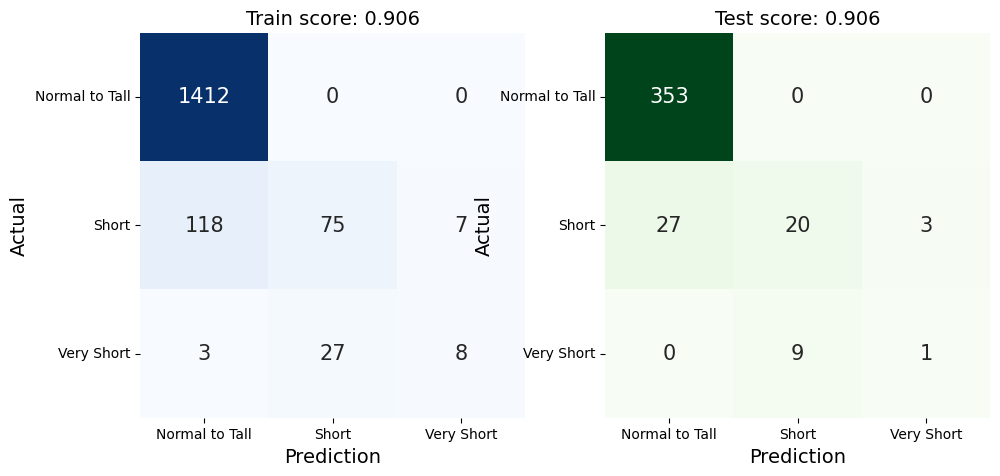

time: 580 ms (started: 2025-10-28 15:01:01 +00:00)


In [118]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, lr_model)

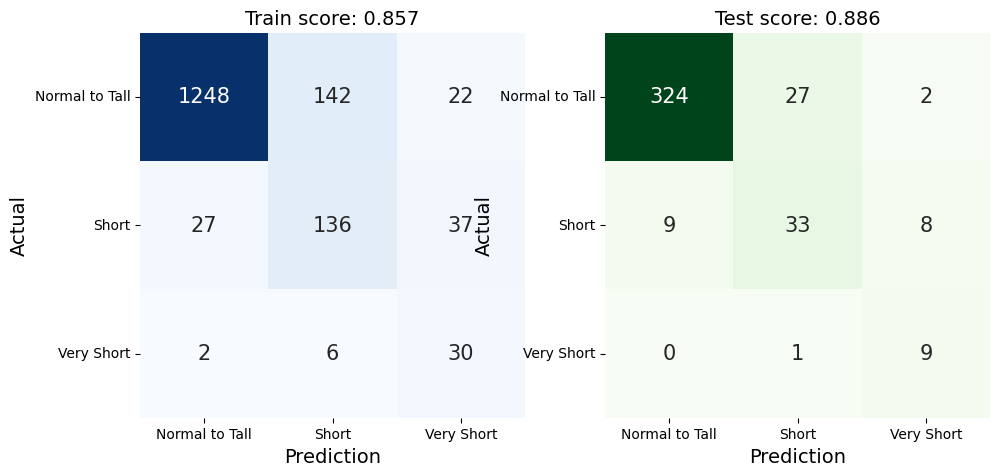

time: 617 ms (started: 2025-10-28 15:01:01 +00:00)


In [119]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, lr_smote_model)

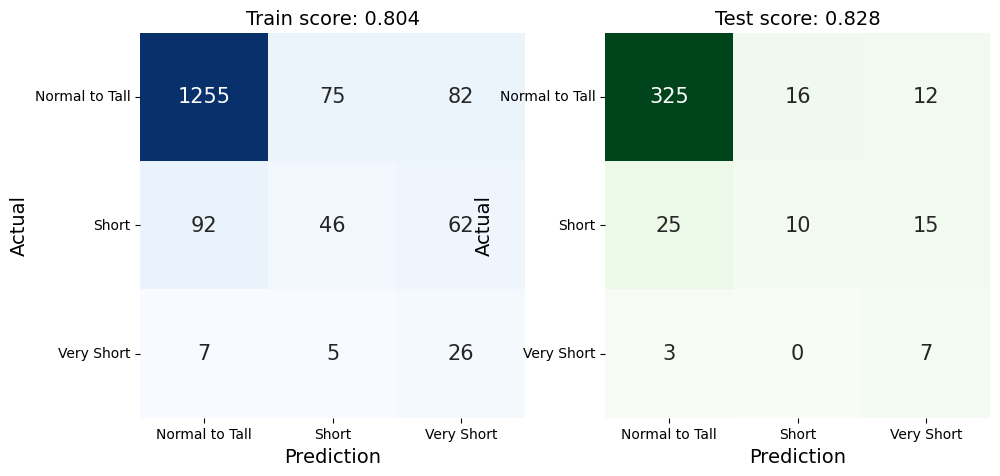

time: 559 ms (started: 2025-10-28 15:01:02 +00:00)


In [120]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, lr_model_tuned)

Train report
                precision    recall  f1-score   support

Normal to Tall       0.92      1.00      0.96      1412
         Short       0.74      0.38      0.50       200
    Very Short       0.53      0.21      0.30        38

      accuracy                           0.91      1650
     macro avg       0.73      0.53      0.59      1650
  weighted avg       0.89      0.91      0.89      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.93      1.00      0.96       353
         Short       0.69      0.40      0.51        50
    Very Short       0.25      0.10      0.14        10

      accuracy                           0.91       413
     macro avg       0.62      0.50      0.54       413
  weighted avg       0.88      0.91      0.89       413



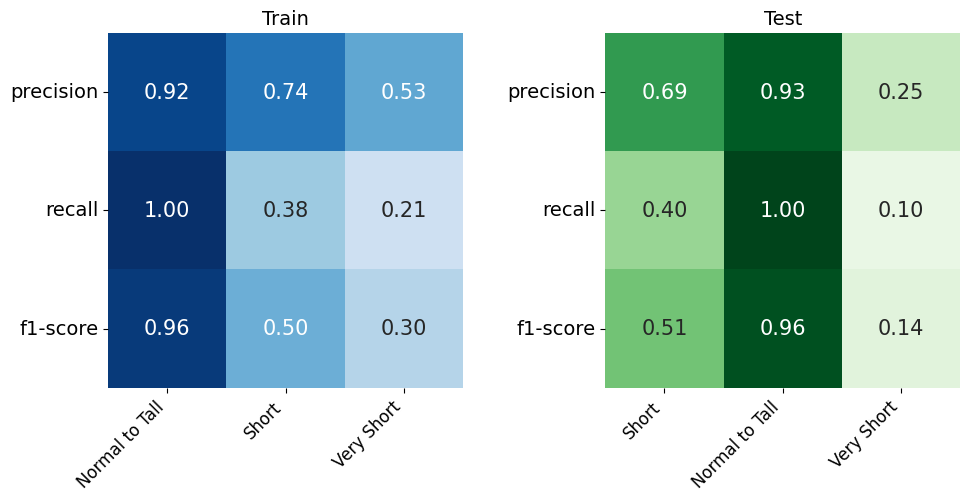

time: 640 ms (started: 2025-10-28 15:01:02 +00:00)


In [121]:
plot_classification_report(X_train, y_train, X_test, y_test, lr_model, report=True, return_df=False)
lr_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], lr_model, report=False, return_df=True)

Train report
                precision    recall  f1-score   support

Normal to Tall       0.98      0.88      0.93      1412
         Short       0.48      0.68      0.56       200
    Very Short       0.34      0.79      0.47        38

      accuracy                           0.86      1650
     macro avg       0.60      0.78      0.65      1650
  weighted avg       0.90      0.86      0.87      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.97      0.92      0.94       353
         Short       0.54      0.66      0.59        50
    Very Short       0.47      0.90      0.62        10

      accuracy                           0.89       413
     macro avg       0.66      0.83      0.72       413
  weighted avg       0.91      0.89      0.89       413



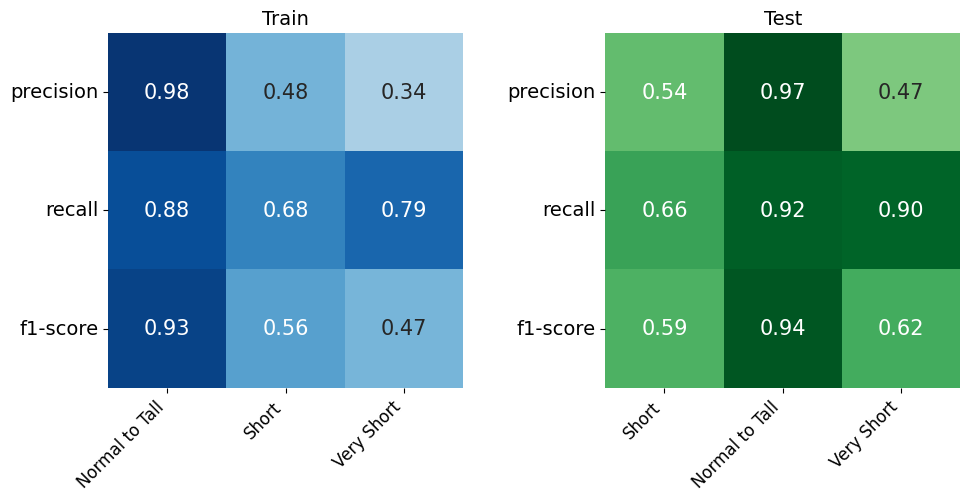

time: 608 ms (started: 2025-10-28 15:01:03 +00:00)


In [122]:
plot_classification_report(X_train, y_train, X_test, y_test, lr_smote_model, report=True, return_df=False)
lr_smote_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], lr_smote_model, report=False, return_df=True)

Train report
                precision    recall  f1-score   support

Normal to Tall       0.93      0.89      0.91      1412
         Short       0.37      0.23      0.28       200
    Very Short       0.15      0.68      0.25        38

      accuracy                           0.80      1650
     macro avg       0.48      0.60      0.48      1650
  weighted avg       0.84      0.80      0.82      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.92      0.92      0.92       353
         Short       0.38      0.20      0.26        50
    Very Short       0.21      0.70      0.32        10

      accuracy                           0.83       413
     macro avg       0.50      0.61      0.50       413
  weighted avg       0.84      0.83      0.83       413



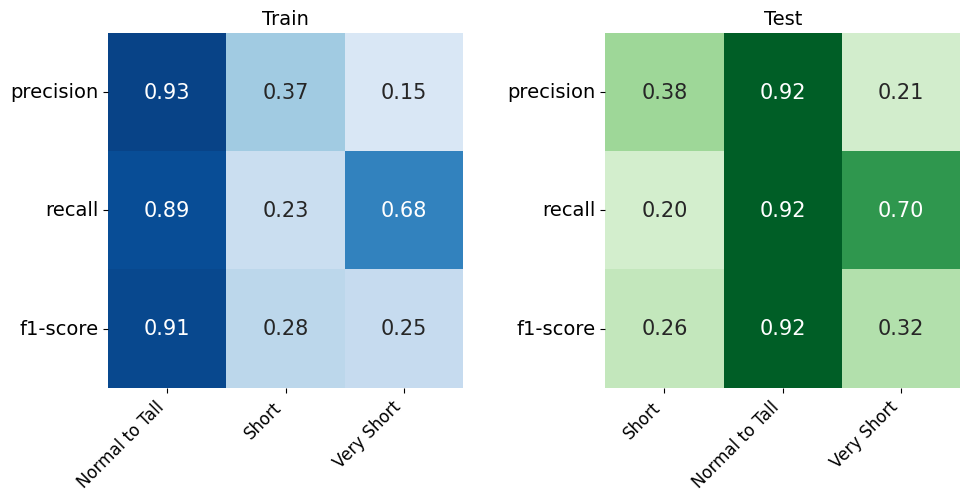

time: 621 ms (started: 2025-10-28 15:01:04 +00:00)


In [123]:
plot_classification_report(X_train, y_train, X_test, y_test, lr_model_tuned, report=True, return_df=False)
lr_tuned_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], lr_model_tuned, report=False, return_df=True)

## 9.2. k-Nearest Neighbors

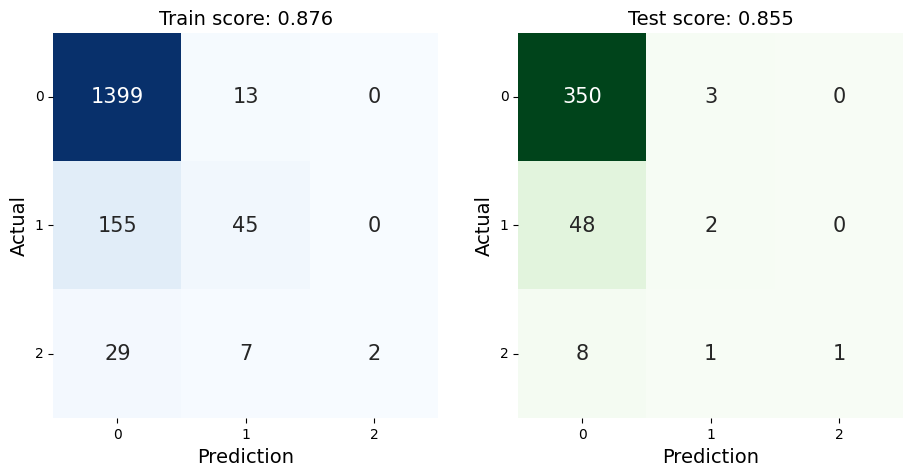

time: 546 ms (started: 2025-10-28 15:01:04 +00:00)


In [124]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, knn_model)

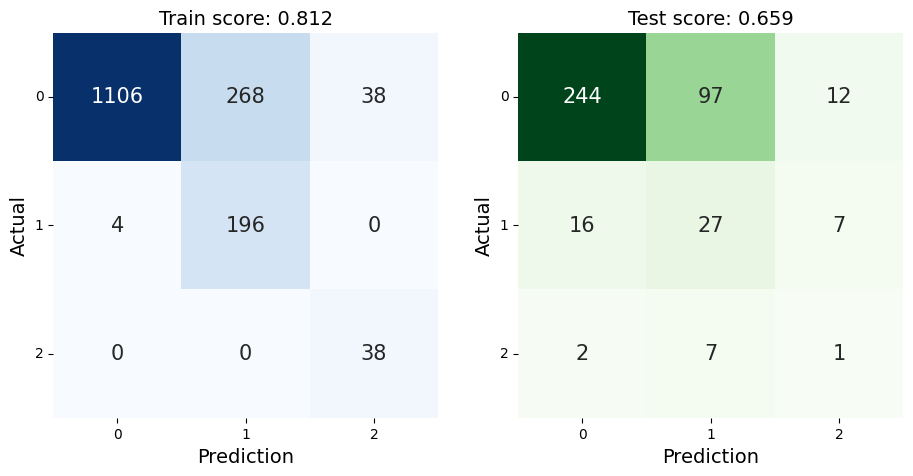

time: 577 ms (started: 2025-10-28 15:01:05 +00:00)


In [125]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, knn_smote_model)

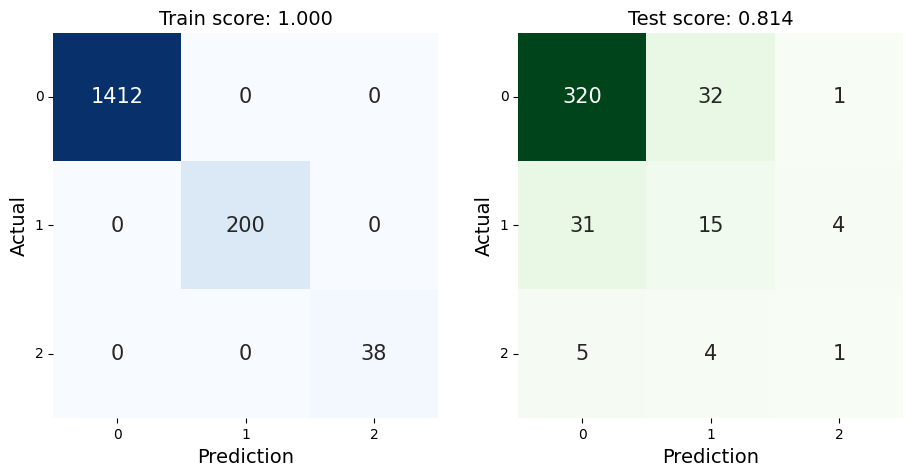

time: 1.28 s (started: 2025-10-28 15:01:05 +00:00)


In [126]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, knn_model_tuned)

Train report
              precision    recall  f1-score   support

           0       0.88      0.99      0.93      1412
           1       0.69      0.23      0.34       200
           2       1.00      0.05      0.10        38

    accuracy                           0.88      1650
   macro avg       0.86      0.42      0.46      1650
weighted avg       0.86      0.88      0.84      1650


Test report
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       353
           1       0.33      0.04      0.07        50
           2       1.00      0.10      0.18        10

    accuracy                           0.85       413
   macro avg       0.73      0.38      0.39       413
weighted avg       0.80      0.85      0.80       413



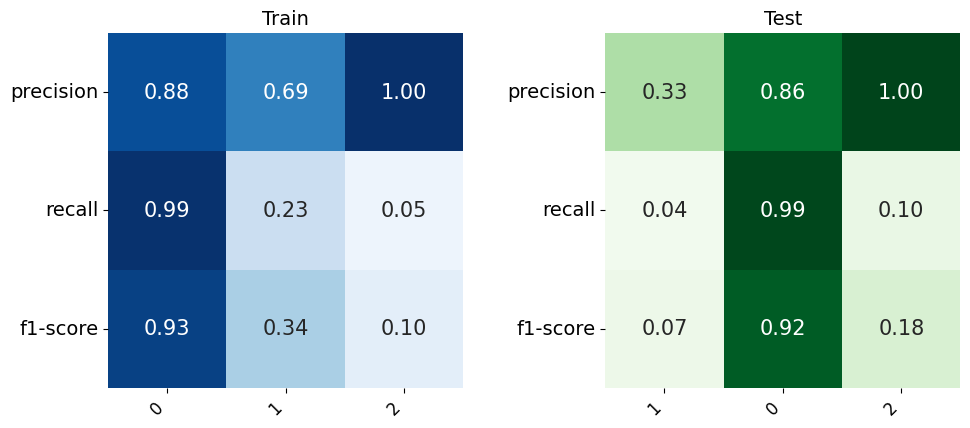

time: 558 ms (started: 2025-10-28 15:01:07 +00:00)


In [127]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, knn_model, report=True, return_df=False)
knn_eval = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], knn_model, report=False, return_df=True)

Train report
              precision    recall  f1-score   support

           0       1.00      0.78      0.88      1412
           1       0.42      0.98      0.59       200
           2       0.50      1.00      0.67        38

    accuracy                           0.81      1650
   macro avg       0.64      0.92      0.71      1650
weighted avg       0.92      0.81      0.84      1650


Test report
              precision    recall  f1-score   support

           0       0.93      0.69      0.79       353
           1       0.21      0.54      0.30        50
           2       0.05      0.10      0.07        10

    accuracy                           0.66       413
   macro avg       0.40      0.44      0.39       413
weighted avg       0.82      0.66      0.72       413



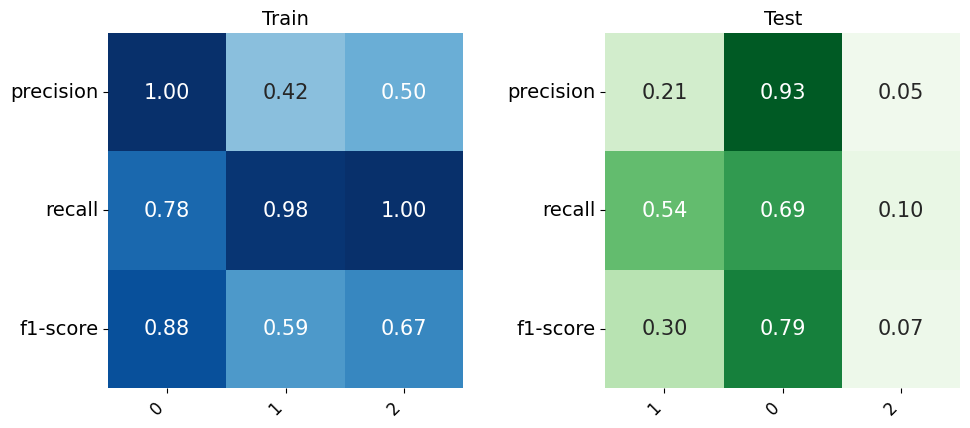

time: 649 ms (started: 2025-10-28 15:01:07 +00:00)


In [128]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, knn_smote_model, report=True, return_df=False)
knn_smote_eval = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], knn_smote_model, report=False, return_df=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1412
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00        38

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Test report
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       353
           1       0.29      0.30      0.30        50
           2       0.17      0.10      0.12        10

    accuracy                           0.81       413
   macro avg       0.45      0.44      0.44       413
weighted avg       0.81      0.81      0.81       413



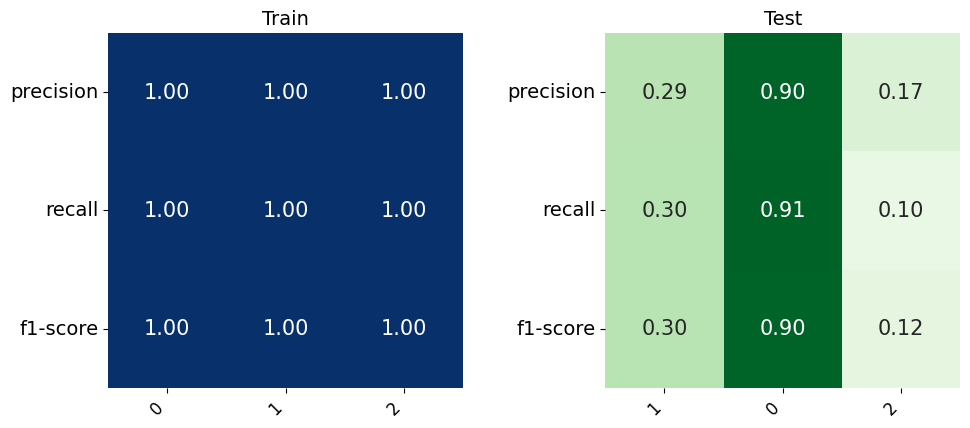

time: 1.35 s (started: 2025-10-28 15:01:08 +00:00)


In [129]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, knn_model_tuned, report=True, return_df=False)
knn_tuned_eval = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], knn_model_tuned, report=False, return_df=True)

## 9.3. Support Vector Machine

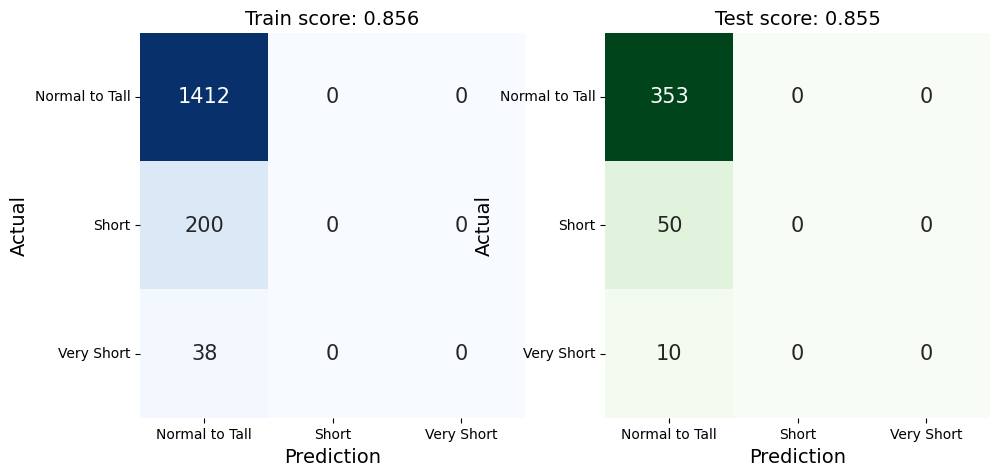

time: 679 ms (started: 2025-10-28 15:01:09 +00:00)


In [130]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, svm_model)

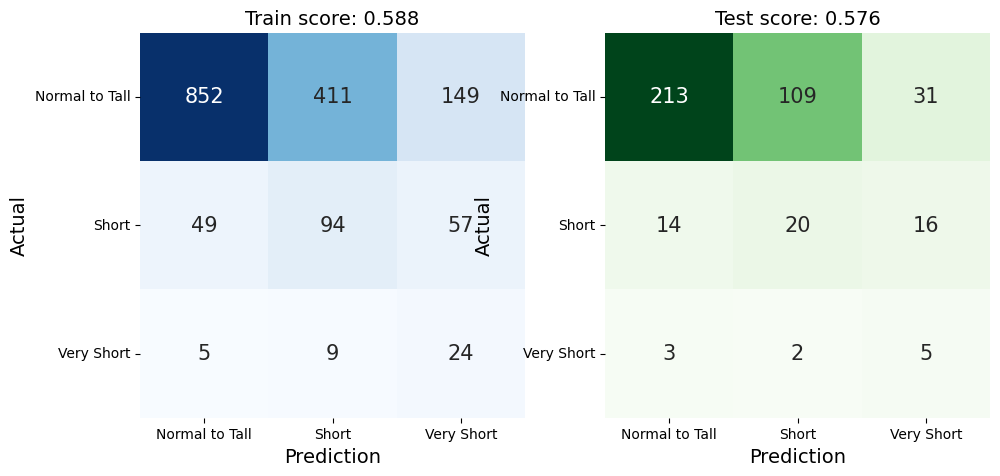

time: 2.06 s (started: 2025-10-28 15:01:10 +00:00)


In [131]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, svm_smote_model)

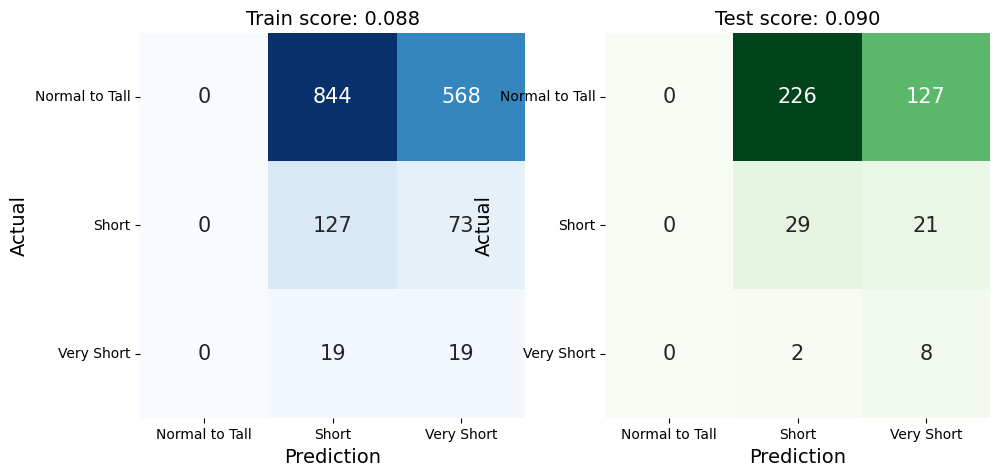

time: 2.11 s (started: 2025-10-28 15:01:12 +00:00)


In [132]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, svm_model_tuned)

Train report
                precision    recall  f1-score   support

Normal to Tall       0.86      1.00      0.92      1412
         Short       0.00      0.00      0.00       200
    Very Short       0.00      0.00      0.00        38

      accuracy                           0.86      1650
     macro avg       0.29      0.33      0.31      1650
  weighted avg       0.73      0.86      0.79      1650


Test report


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

                precision    recall  f1-score   support

Normal to Tall       0.85      1.00      0.92       353
         Short       0.00      0.00      0.00        50
    Very Short       0.00      0.00      0.00        10

      accuracy                           0.85       413
     macro avg       0.28      0.33      0.31       413
  weighted avg       0.73      0.85      0.79       413



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

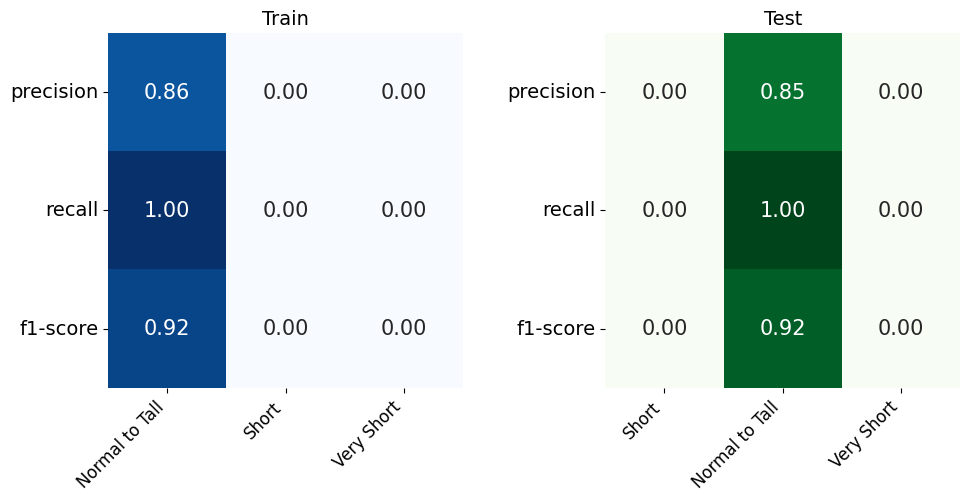

time: 803 ms (started: 2025-10-28 15:01:14 +00:00)


In [133]:
plot_classification_report(X_train, y_train, X_test, y_test, svm_model, report=True, return_df=False)
svm_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], svm_model, report=False, return_df=True)

Train report
                precision    recall  f1-score   support

Normal to Tall       0.94      0.60      0.74      1412
         Short       0.18      0.47      0.26       200
    Very Short       0.10      0.63      0.18        38

      accuracy                           0.59      1650
     macro avg       0.41      0.57      0.39      1650
  weighted avg       0.83      0.59      0.67      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.93      0.60      0.73       353
         Short       0.15      0.40      0.22        50
    Very Short       0.10      0.50      0.16        10

      accuracy                           0.58       413
     macro avg       0.39      0.50      0.37       413
  weighted avg       0.81      0.58      0.66       413



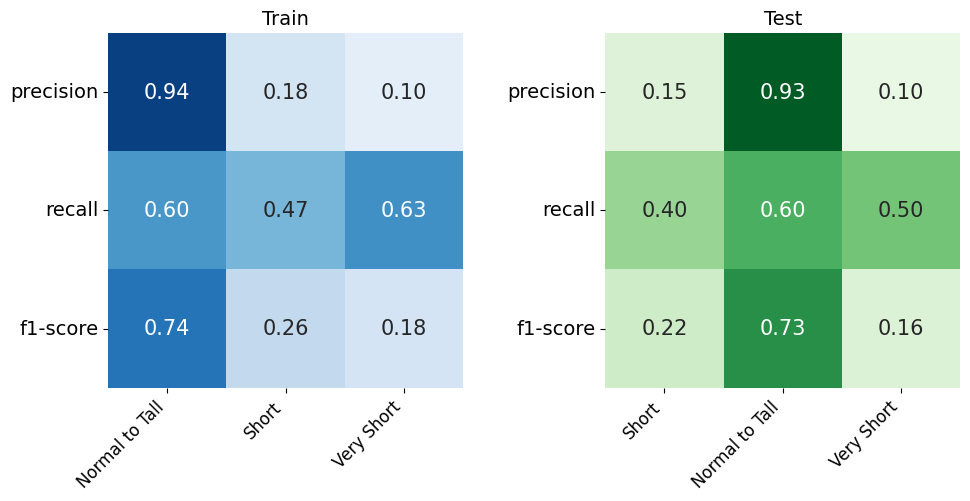

time: 2.14 s (started: 2025-10-28 15:01:15 +00:00)


In [134]:
plot_classification_report(X_train, y_train, X_test, y_test, svm_smote_model, report=True, return_df=False)
svm_smote_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], svm_smote_model, report=False, return_df=True)

Train report


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


                precision    recall  f1-score   support

Normal to Tall       0.00      0.00      0.00      1412
         Short       0.13      0.64      0.21       200
    Very Short       0.03      0.50      0.05        38

      accuracy                           0.09      1650
     macro avg       0.05      0.38      0.09      1650
  weighted avg       0.02      0.09      0.03      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.00      0.00      0.00       353
         Short       0.11      0.58      0.19        50
    Very Short       0.05      0.80      0.10        10

      accuracy                           0.09       413
     macro avg       0.05      0.46      0.10       413
  weighted avg       0.01      0.09      0.03       413



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

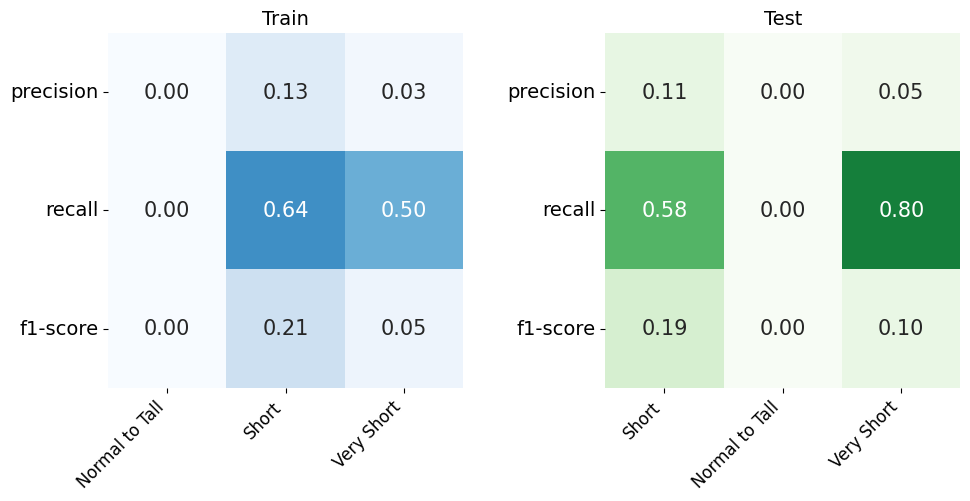

time: 2.48 s (started: 2025-10-28 15:01:17 +00:00)


In [135]:
plot_classification_report(X_train, y_train, X_test, y_test, svm_model_tuned, report=True, return_df=False)
svm_tuned_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], svm_model_tuned, report=False, return_df=True)

## 9.4. Random Forest

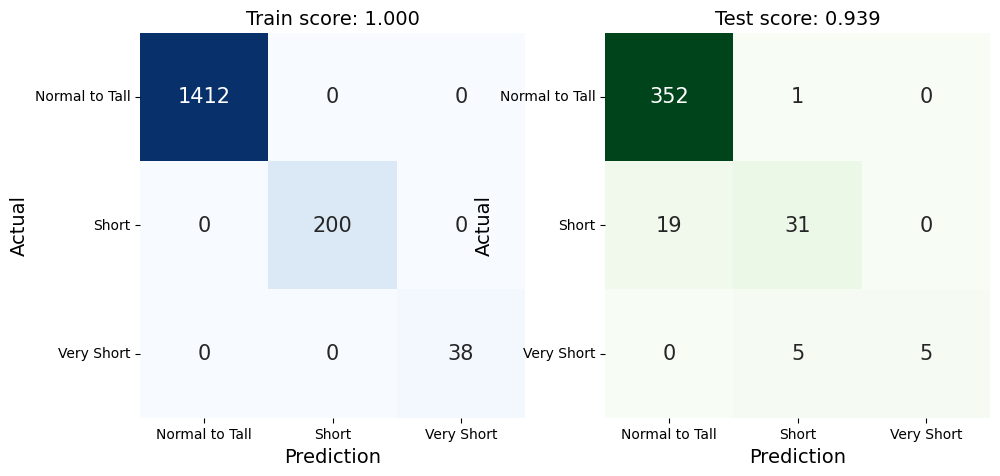

time: 559 ms (started: 2025-10-28 15:01:19 +00:00)


In [136]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, rf_model)

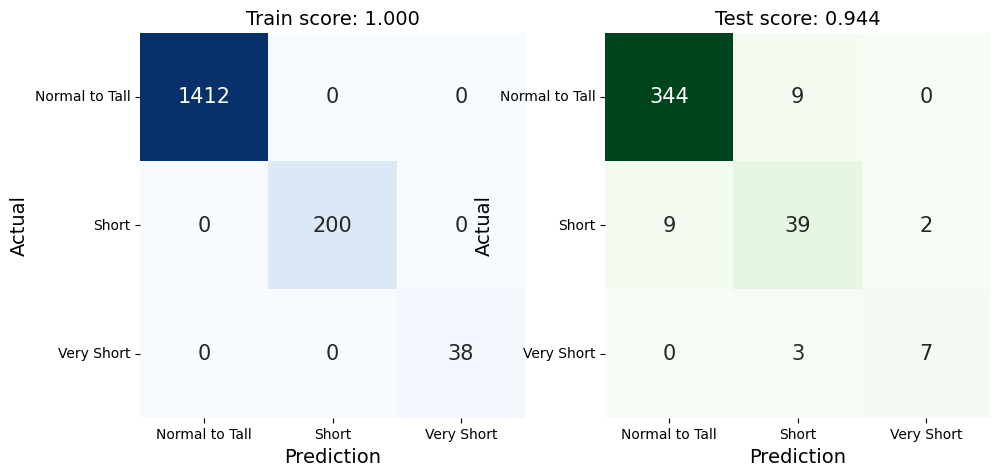

time: 548 ms (started: 2025-10-28 15:01:20 +00:00)


In [137]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, rf_smote_model)

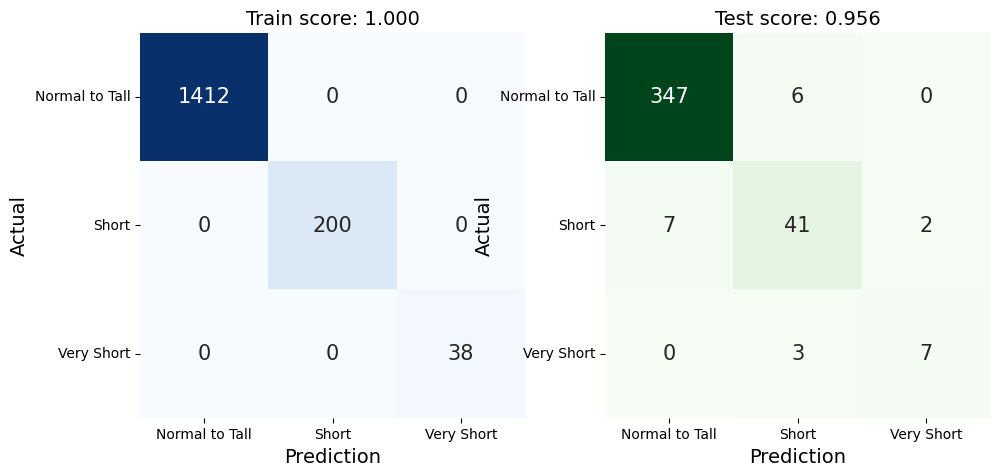

time: 546 ms (started: 2025-10-28 15:01:21 +00:00)


In [138]:
plot_confusion_matrix(X_train, y_train, X_test, y_test, rf_model_tuned)

Train report
                precision    recall  f1-score   support

Normal to Tall       1.00      1.00      1.00      1412
         Short       1.00      1.00      1.00       200
    Very Short       1.00      1.00      1.00        38

      accuracy                           1.00      1650
     macro avg       1.00      1.00      1.00      1650
  weighted avg       1.00      1.00      1.00      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.95      1.00      0.97       353
         Short       0.84      0.62      0.71        50
    Very Short       1.00      0.50      0.67        10

      accuracy                           0.94       413
     macro avg       0.93      0.71      0.78       413
  weighted avg       0.94      0.94      0.93       413



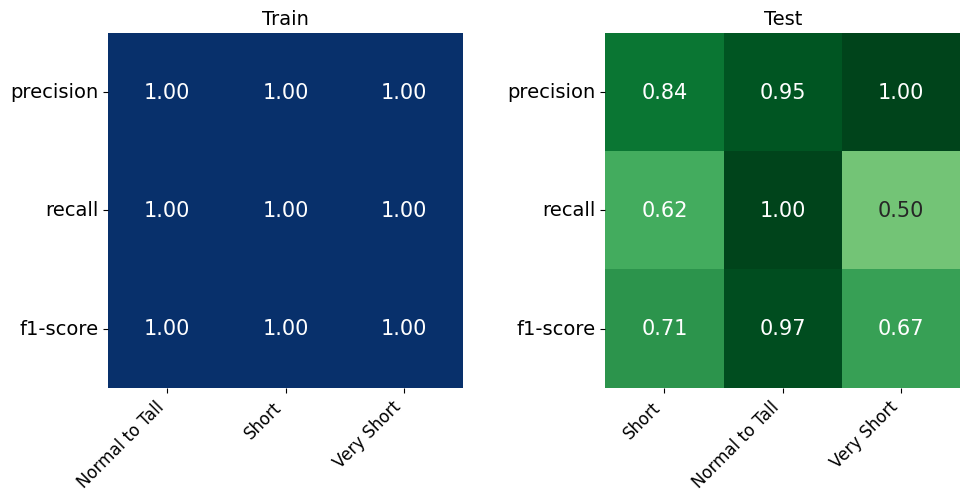

time: 669 ms (started: 2025-10-28 15:01:21 +00:00)


In [139]:
plot_classification_report(X_train, y_train, X_test, y_test, rf_model, report=True, return_df=False)
rf_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], rf_model, report=False, return_df=True)

Train report
                precision    recall  f1-score   support

Normal to Tall       1.00      1.00      1.00      1412
         Short       1.00      1.00      1.00       200
    Very Short       1.00      1.00      1.00        38

      accuracy                           1.00      1650
     macro avg       1.00      1.00      1.00      1650
  weighted avg       1.00      1.00      1.00      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.97      0.97      0.97       353
         Short       0.76      0.78      0.77        50
    Very Short       0.78      0.70      0.74        10

      accuracy                           0.94       413
     macro avg       0.84      0.82      0.83       413
  weighted avg       0.94      0.94      0.94       413



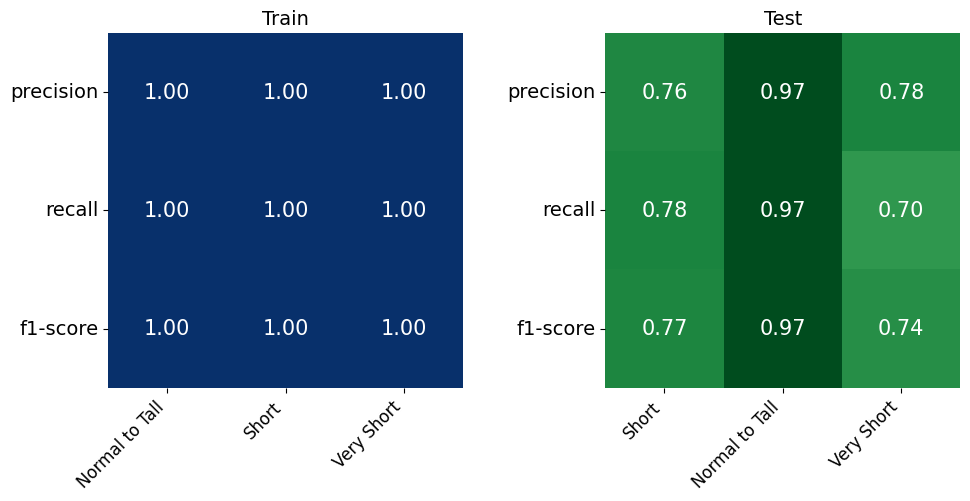

time: 672 ms (started: 2025-10-28 15:01:22 +00:00)


In [140]:
plot_classification_report(X_train, y_train, X_test, y_test, rf_smote_model, report=True, return_df=False)
rf_smote_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], rf_smote_model, report=False, return_df=True)

Train report
                precision    recall  f1-score   support

Normal to Tall       1.00      1.00      1.00      1412
         Short       1.00      1.00      1.00       200
    Very Short       1.00      1.00      1.00        38

      accuracy                           1.00      1650
     macro avg       1.00      1.00      1.00      1650
  weighted avg       1.00      1.00      1.00      1650


Test report
                precision    recall  f1-score   support

Normal to Tall       0.98      0.98      0.98       353
         Short       0.82      0.82      0.82        50
    Very Short       0.78      0.70      0.74        10

      accuracy                           0.96       413
     macro avg       0.86      0.83      0.85       413
  weighted avg       0.96      0.96      0.96       413



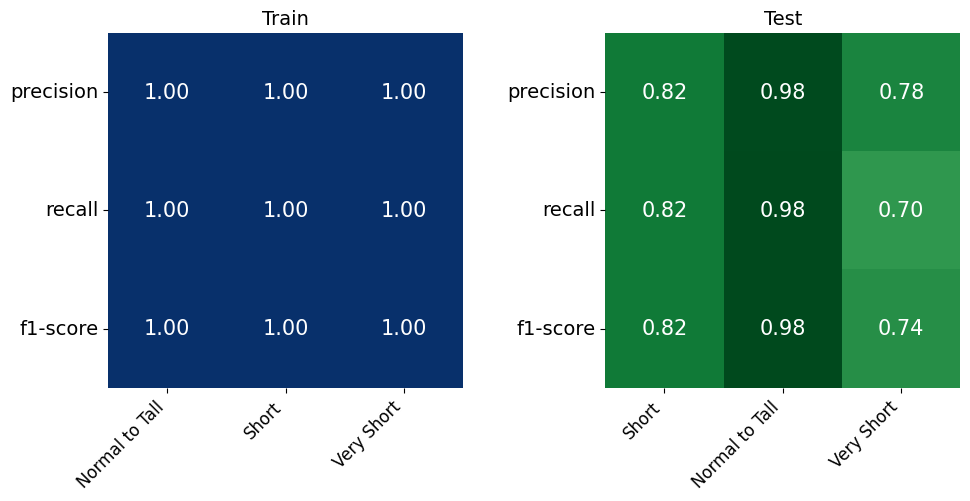

time: 644 ms (started: 2025-10-28 15:01:22 +00:00)


In [141]:
plot_classification_report(X_train, y_train, X_test, y_test, rf_model_tuned, report=True, return_df=False)
rf_tuned_eval = plot_classification_report(X_train, pd.DataFrame(y_train)[0], X_test, pd.DataFrame(y_test)[0], rf_model_tuned, report=False, return_df=True)

## 9.5. XGBoost

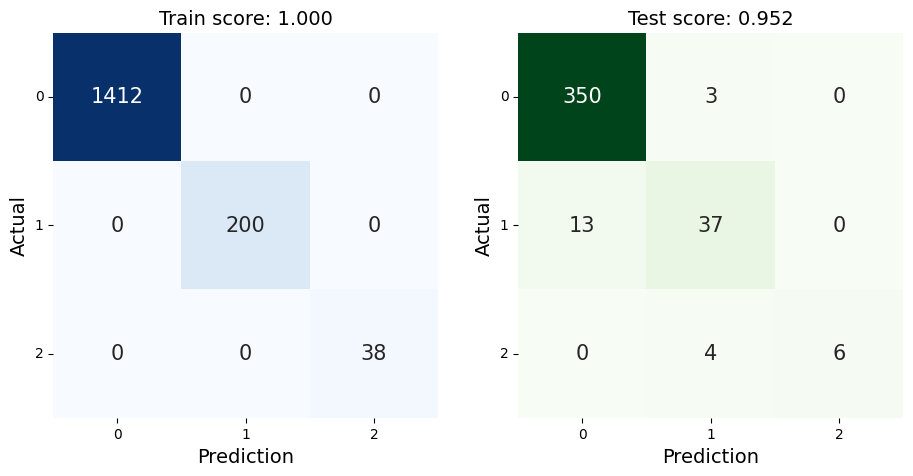

time: 541 ms (started: 2025-10-28 15:01:23 +00:00)


In [142]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, xgb_model)

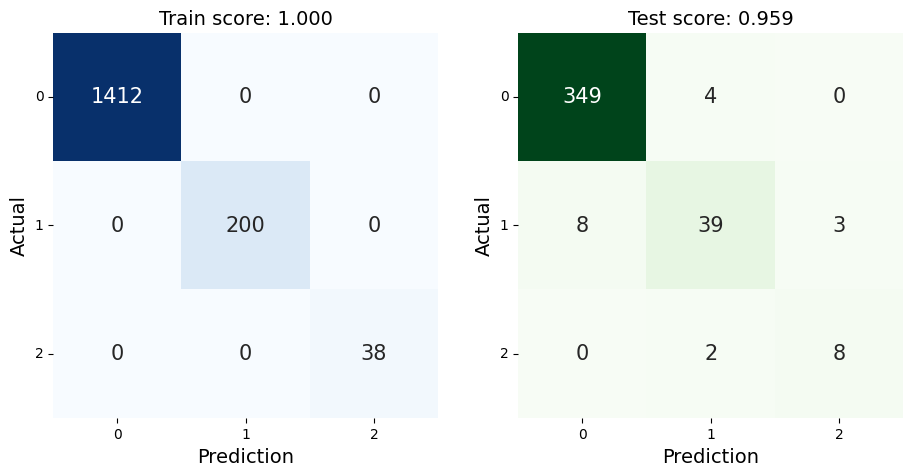

time: 534 ms (started: 2025-10-28 15:01:24 +00:00)


In [143]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, xgb_smote_model)

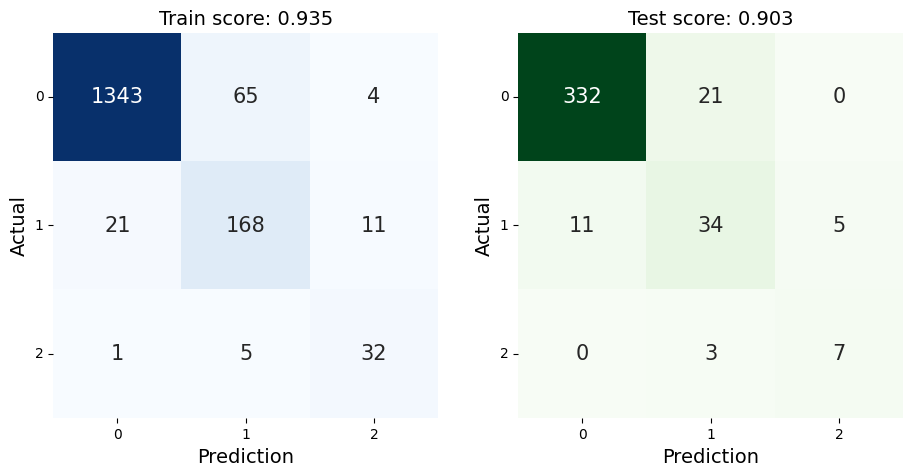

time: 531 ms (started: 2025-10-28 15:01:24 +00:00)


In [144]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, xgb_model_tuned)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1412
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00        38

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Test report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       353
           1       0.84      0.74      0.79        50
           2       1.00      0.60      0.75        10

    accuracy                           0.95       413
   macro avg       0.94      0.78      0.84       413
weighted avg       0.95      0.95      0.95       413



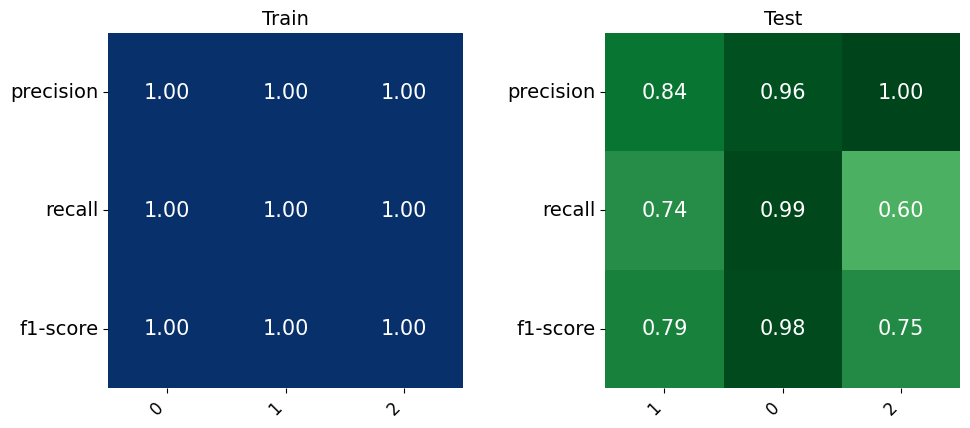

time: 510 ms (started: 2025-10-28 15:01:25 +00:00)


In [145]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, xgb_model, report=True, return_df=False)
xgb_eval = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], xgb_model, report=False, return_df=True)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1412
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00        38

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Test report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       353
           1       0.87      0.78      0.82        50
           2       0.73      0.80      0.76        10

    accuracy                           0.96       413
   macro avg       0.86      0.86      0.86       413
weighted avg       0.96      0.96      0.96       413



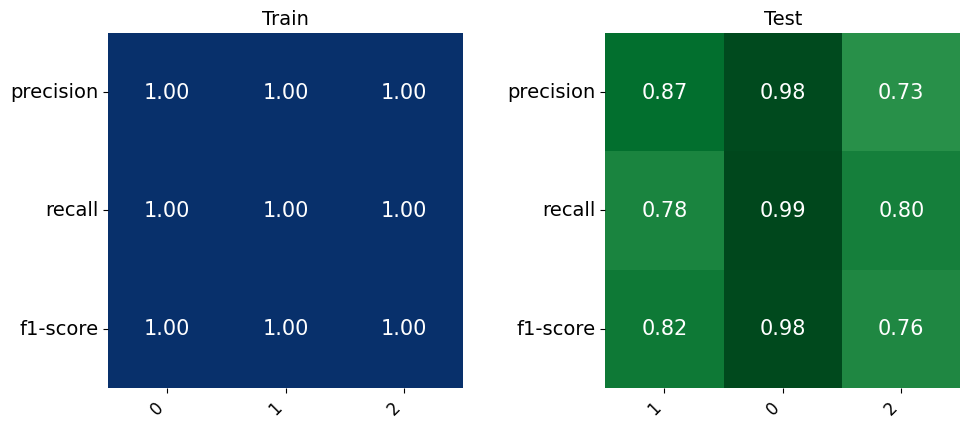

time: 525 ms (started: 2025-10-28 15:01:25 +00:00)


In [146]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, xgb_smote_model, report=True, return_df=False)
xgb_smote_eval = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], xgb_smote_model, report=False, return_df=True)

Train report
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      1412
           1       0.71      0.84      0.77       200
           2       0.68      0.84      0.75        38

    accuracy                           0.94      1650
   macro avg       0.79      0.88      0.83      1650
weighted avg       0.94      0.94      0.94      1650


Test report
              precision    recall  f1-score   support

           0       0.97      0.94      0.95       353
           1       0.59      0.68      0.63        50
           2       0.58      0.70      0.64        10

    accuracy                           0.90       413
   macro avg       0.71      0.77      0.74       413
weighted avg       0.91      0.90      0.91       413



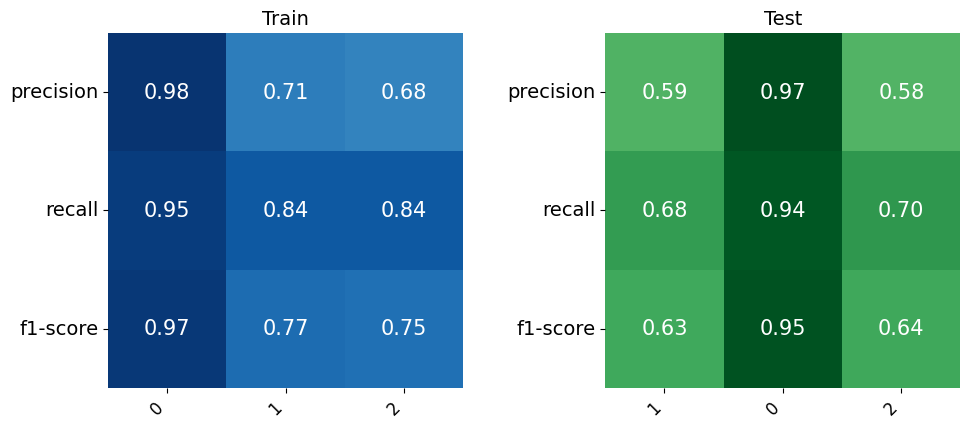

time: 555 ms (started: 2025-10-28 15:01:26 +00:00)


In [147]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, xgb_model_tuned, report=True, return_df=False)
xgb_tuned_eval = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], xgb_model_tuned, report=False, return_df=True)

# 10. Model Performance Comparison

In [148]:
# Daftar model dan jenis percobaan
models = ['Logistic Regression', 'k-Nearest Neighbors', 'Support Vector Machine', 'Random Forest', 'XGBoost']
experiments = ['Base Model', 'SMOTE', 'SMOTE + Tuned (GridSearchCV + CV)']

# Mapping variabel evaluasi dengan nama model dan jenis percobaan
eval_map = {
    ('Logistic Regression', 'Base Model'): lr_eval,
    ('Logistic Regression', 'SMOTE'): lr_smote_eval,
    ('Logistic Regression', 'SMOTE + Tuned (GridSearchCV + CV)'): lr_tuned_eval,
    
    ('k-Nearest Neighbors', 'Base Model'): knn_eval,
    ('k-Nearest Neighbors', 'SMOTE'): knn_smote_eval,
    ('k-Nearest Neighbors', 'SMOTE + Tuned (GridSearchCV + CV)'): knn_tuned_eval,
    
    ('Support Vector Machine', 'Base Model'): svm_eval,
    ('Support Vector Machine', 'SMOTE'): svm_smote_eval,
    ('Support Vector Machine', 'SMOTE + Tuned (GridSearchCV + CV)'): svm_tuned_eval,
    
    ('Random Forest', 'Base Model'): rf_eval,
    ('Random Forest', 'SMOTE'): rf_smote_eval,
    ('Random Forest', 'SMOTE + Tuned (GridSearchCV + CV)'): rf_tuned_eval,
    
    ('XGBoost', 'Base Model'): xgb_eval,
    ('XGBoost', 'SMOTE'): xgb_smote_eval,
    ('XGBoost', 'SMOTE + Tuned (GridSearchCV + CV)'): xgb_tuned_eval,
}

# Membuat list untuk menampung hasil
rows = []

# Loop untuk ambil nilai metrik dari masing-masing model dan percobaan
for (model, exp_name), eval_data in eval_map.items():
    train_df, test_df = eval_data

    # Ambil metrik macro average
    train_f1 = train_df.loc['macro avg', 'f1-score']
    test_f1 = test_df.loc['macro avg', 'f1-score']

    train_recall = train_df.loc['macro avg', 'recall']
    test_recall = test_df.loc['macro avg', 'recall']

    train_precision = train_df.loc['macro avg', 'precision']
    test_precision = test_df.loc['macro avg', 'precision']

    # Ambil accuracy
    train_acc = train_df.loc['accuracy', 'f1-score']
    test_acc = test_df.loc['accuracy', 'f1-score']

    # Tambahkan ke list hasil
    rows.append({
        'Nama Model': model,
        'Percobaan': exp_name,
        'Accuracy (Train)': train_acc,
        'Accuracy (Test)': test_acc,
        'F1-Score (Train)': train_f1,
        'F1-Score (Test)': test_f1,
        'Recall-Macro (Train)': train_recall,
        'Recall-Macro (Test)': test_recall,
        'Precision-Macro (Train)': train_precision,
        'Precision-Macro (Test)': test_precision
    })

# Konversi ke DataFrame
df_model_evaluation = pd.DataFrame(rows)

# Tampilkan hasil
display(df_model_evaluation.head())
display(df_model_evaluation.tail())


Nama Model                          Percobaan  Accuracy (Train)  \
0  Logistic Regression                         Base Model              0.91   
1  Logistic Regression                              SMOTE              0.86   
2  Logistic Regression  SMOTE + Tuned (GridSearchCV + CV)              0.80   
3  k-Nearest Neighbors                         Base Model              0.88   
4  k-Nearest Neighbors                              SMOTE              0.81   

   Accuracy (Test)  F1-Score (Train)  F1-Score (Test)  Recall-Macro (Train)  \
0             0.91              0.59             0.54                  0.53   
1             0.89              0.65             0.72                  0.78   
2             0.83              0.48             0.50                  0.60   
3             0.85              0.46             0.39                  0.42   
4             0.66              0.71             0.39                  0.92   

   Recall-Macro (Test)  Precision-Macro (Train)  Precision-Macro (Test)  
0                 0.50                     0.73                    0.62  
1                 0.83                     0.60                    0.66  
2                 0.61                     0.48                    0.50  
3                 0.38                     0.86                    0.73  
4                 0.44                     0.64                    0.40

Nama Model                          Percobaan  Accuracy (Train)  \
10  Random Forest                              SMOTE              1.00   
11  Random Forest  SMOTE + Tuned (GridSearchCV + CV)              1.00   
12        XGBoost                         Base Model              1.00   
13        XGBoost                              SMOTE              1.00   
14        XGBoost  SMOTE + Tuned (GridSearchCV + CV)              0.94   

    Accuracy (Test)  F1-Score (Train)  F1-Score (Test)  Recall-Macro (Train)  \
10             0.94              1.00             0.83                  1.00   
11             0.96              1.00             0.85                  1.00   
12             0.95              1.00             0.84                  1.00   
13             0.96              1.00             0.86                  1.00   
14             0.90              0.83             0.74                  0.88   

    Recall-Macro (Test)  Precision-Macro (Train)  Precision-Macro (Test)  
10                 0.82                     1.00                    0.84  
11                 0.83                     1.00                    0.86  
12                 0.78                     1.00                    0.94  
13                 0.86                     1.00                    0.86  
14                 0.77                     0.79                    0.71

time: 24 ms (started: 2025-10-28 15:01:26 +00:00)


In [149]:
def plot_model_comparison(df, metric_name):
    """
    Menampilkan perbandingan performa model berdasarkan metrik tertentu
    untuk Train dan Test set, dengan hue berdasarkan jenis percobaan.
    Warna: Train (biru gradasi), Test (kuning gradasi), garis reference merah.
    
    Garis reference merah menunjukkan rata-rata skor untuk Train dan Test set.
    """

    # Pemetaan metrik ke kolom dataframe
    metric_columns = {
        "Accuracy": ("Accuracy (Train)", "Accuracy (Test)"),
        "F1-Score": ("F1-Score (Train)", "F1-Score (Test)"),
        "Precision-Macro": ("Precision-Macro (Train)", "Precision-Macro (Test)"),
        "Recall-Macro": ("Recall-Macro (Train)", "Recall-Macro (Test)")
    }

    if metric_name not in metric_columns:
        raise ValueError(
            f"Metrik '{metric_name}' tidak dikenali. "
            f"Gunakan salah satu dari {list(metric_columns.keys())}"
        )

    train_col, test_col = metric_columns[metric_name]

    # Ubah dataframe ke format long agar mudah diplot dengan seaborn
    df_long = pd.melt(
        df[["Nama Model", "Percobaan", train_col, test_col]].rename(columns={
            train_col: "Train",
            test_col: "Test"
        }),
        id_vars=["Nama Model", "Percobaan"],
        var_name="Set",
        value_name="Score"
    )

    # Gabungkan Percobaan dan Set menjadi satu label hue
    df_long["Kategori"] = df_long["Percobaan"] + " - " + df_long["Set"]

    # Tentukan urutan label hue agar warnanya konsisten
    categories = [
        "Base Model - Train", "SMOTE - Train", "SMOTE + Tuned (GridSearchCV + CV) - Train",
        "Base Model - Test", "SMOTE - Test", "SMOTE + Tuned (GridSearchCV + CV) - Test"
    ]
    df_long["Kategori"] = pd.Categorical(df_long["Kategori"], categories=categories, ordered=True)

    # Buat palet warna: gradasi biru untuk Train, kuning untuk Test
    blue_palette = sns.color_palette("Blues", n_colors=3)
    yellow_palette = sns.color_palette("YlOrBr", n_colors=3)
    custom_palette = blue_palette + yellow_palette

    # Urutkan berdasarkan nilai test rata-rata
    order = df.groupby("Nama Model")[test_col].mean().sort_values(ascending=False).index

    # Plot
    plt.figure(figsize=(14, 7))
    ax = sns.barplot(
        data=df_long,
        x="Nama Model",
        y="Score",
        hue="Kategori",
        order=order,
        palette=custom_palette,
        ci=None
    )

    # Label nilai di atas bar
    for container in ax.containers:
        ax.bar_label(container, fmt='%.3f', label_type='edge', padding=3, fontsize=8)

    # Garis reference merah untuk rata-rata Train dan Test
    ref_train = df[train_col].mean()
    ref_test = df[test_col].mean()
    plt.axhline(ref_train, color='darkblue', linestyle='--', linewidth=1., label=f'Train Avg ({ref_train:.3f})')
    plt.axhline(ref_test, color='darkred', linestyle='--', linewidth=1., label=f'Test Avg ({ref_test:.3f})')

    # Styling plot
    plt.title(
        f"Model Comparison based on {metric_name}\n"
        f"(Train: Blue, Test: Yellow — 3 experiment types)\n"
        f"Red dashed line = average Train score, solid red line = average Test score"
    )
    plt.ylabel(metric_name)
    plt.xlabel("Model Name")
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Experiment - Set")
    plt.tight_layout()
    plt.show()


time: 8.3 ms (started: 2025-10-28 15:01:26 +00:00)


## 10.1. Accuracy

/tmp/ipykernel_37/3121632261.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


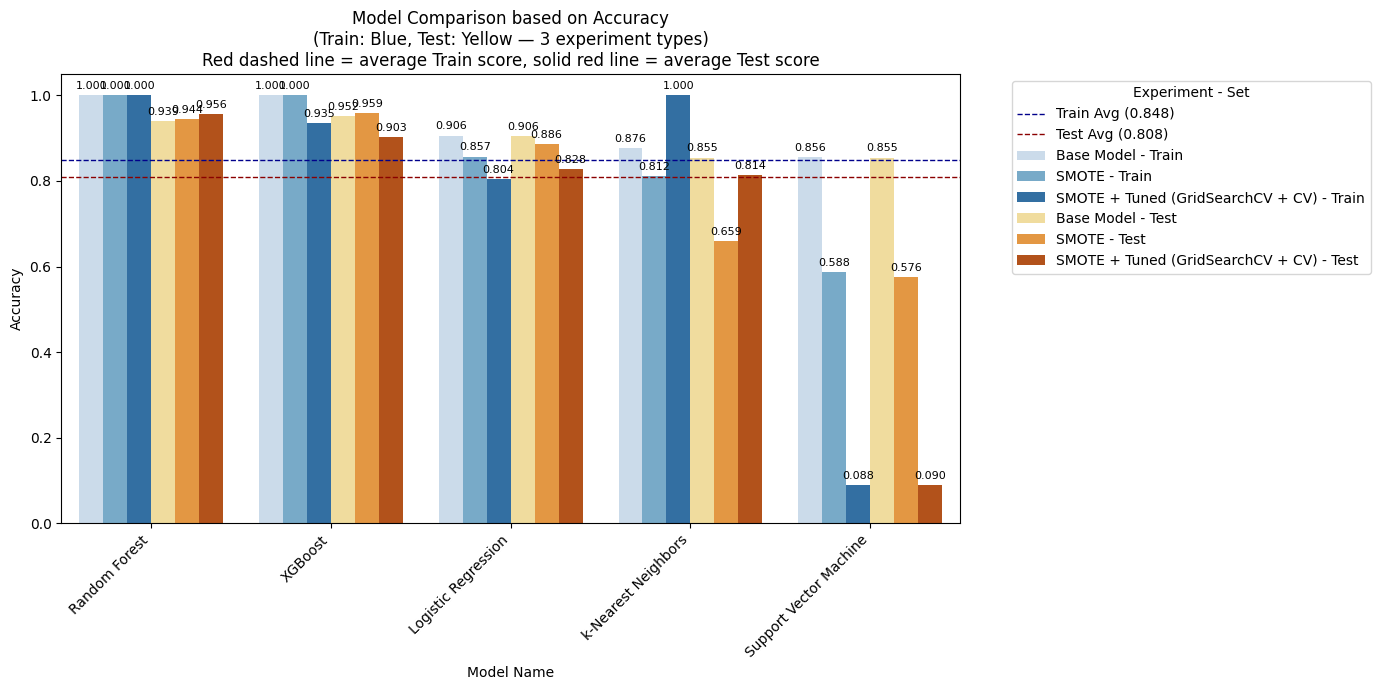

time: 587 ms (started: 2025-10-28 15:01:26 +00:00)


In [150]:
plot_model_comparison(df_model_evaluation, "Accuracy")

## 10.1. F1-Score

/tmp/ipykernel_37/3121632261.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


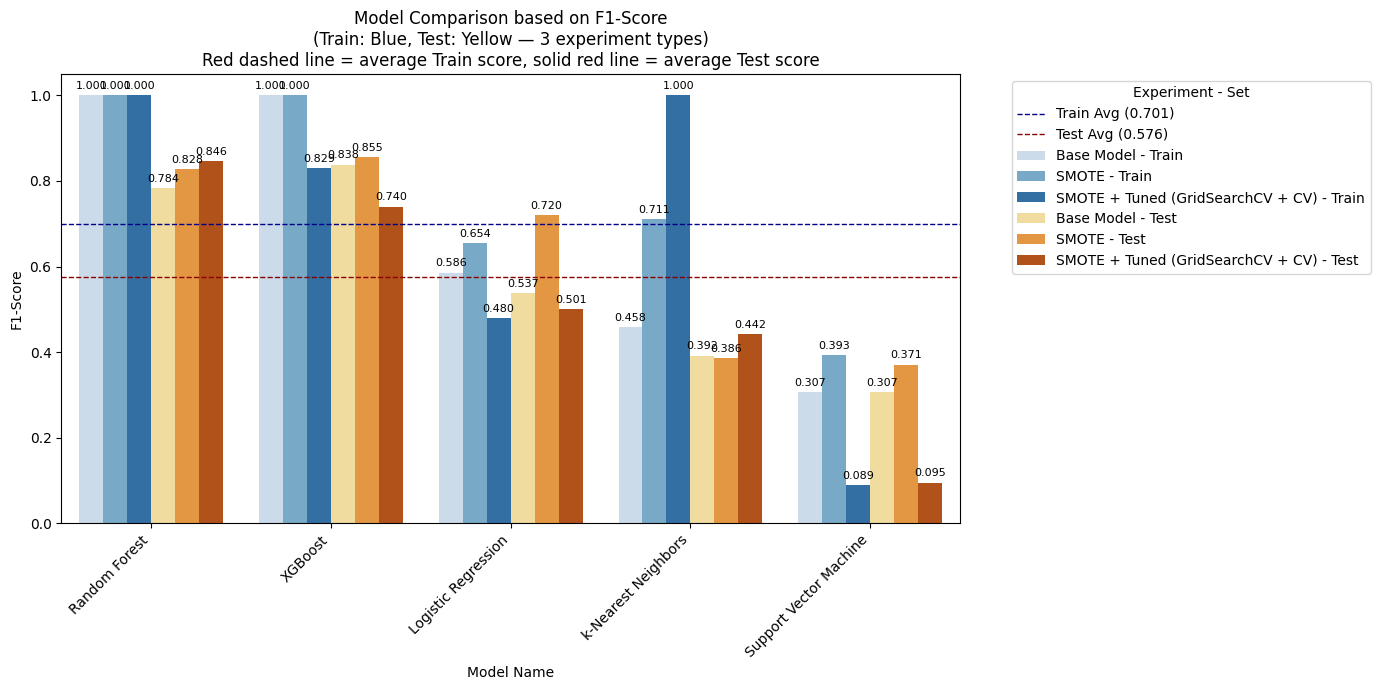

time: 556 ms (started: 2025-10-28 15:01:27 +00:00)


In [151]:
plot_model_comparison(df_model_evaluation, "F1-Score")

## 10.2. Recall-Macro

/tmp/ipykernel_37/3121632261.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


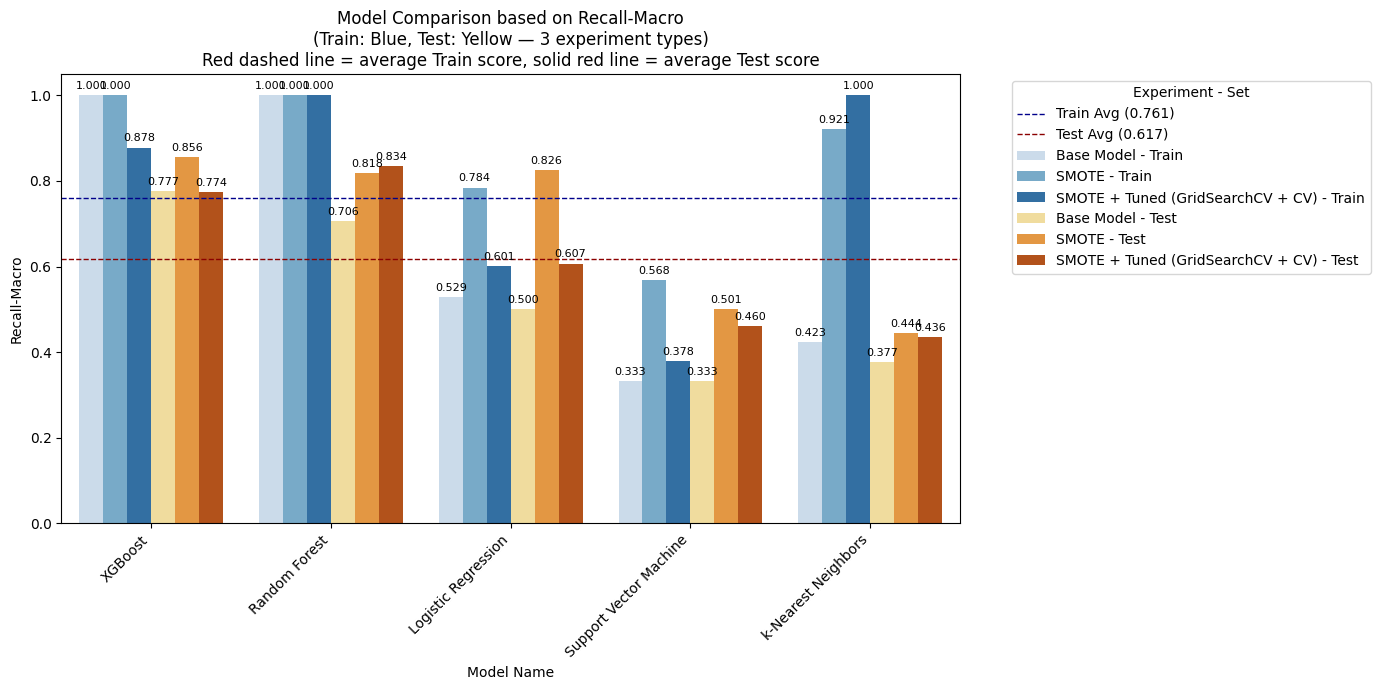

time: 568 ms (started: 2025-10-28 15:01:28 +00:00)


In [152]:
plot_model_comparison(df_model_evaluation, "Recall-Macro")

## 10.3. Precision-Macro

/tmp/ipykernel_37/3121632261.py:57: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(


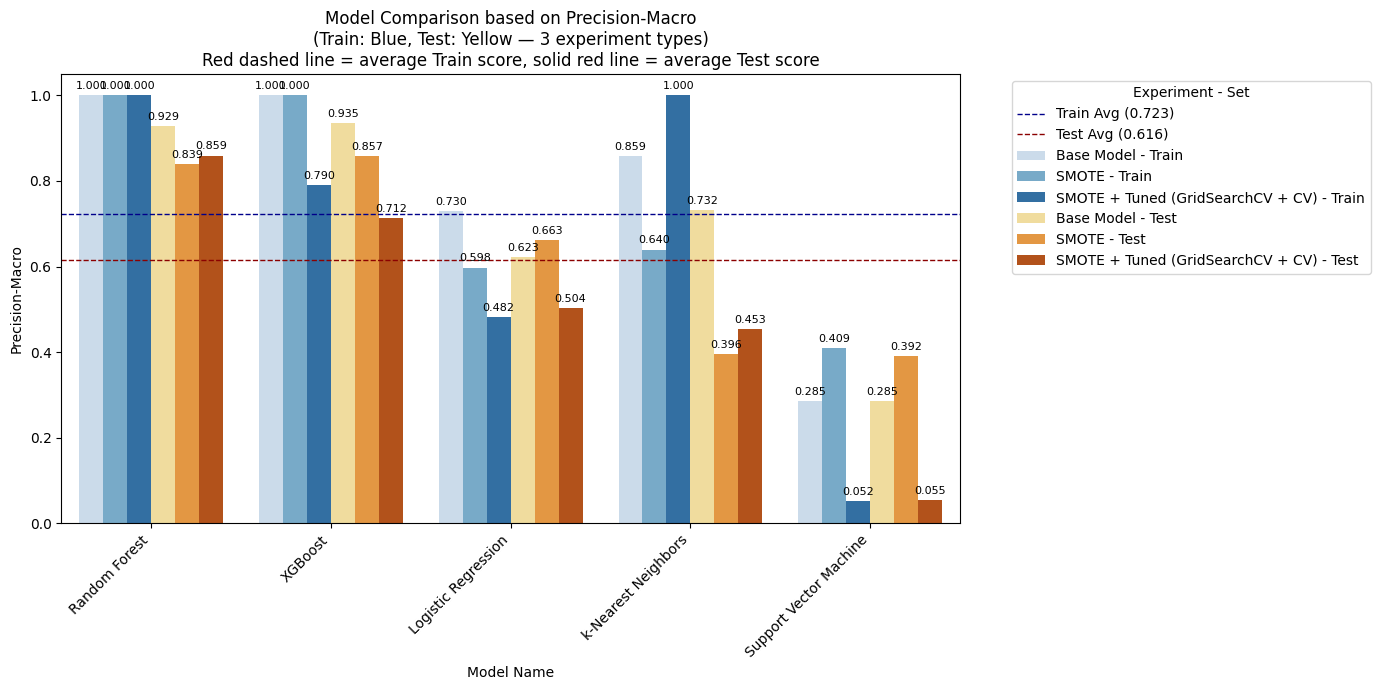

time: 568 ms (started: 2025-10-28 15:01:28 +00:00)


In [153]:
plot_model_comparison(df_model_evaluation, "Precision-Macro")

# 11. Best Model

**📊 1. Accuracy**
- Model terbaik: ✅ XGBoost
- Skenario terbaik: SMOTE
- Walaupun Random Forest menunjukkan accuracy yang lebih stabil  daripada XGBoost pada semua skenario pelatihan, tetapi XGBoost memiliki akurasi test tertinggi (0.959) dengan penggunaan metode SMOTE, dengan hasil yang menandakan generalisasi yang baik.

**📈 2. F1-Score**
- Model terbaik: ✅ XGBoost
- Skenario terbaik: SMOTE
- F1-Score test mendekati 0.855, jauh di atas rata-rata (0.57) dari semua model dan skenario. Ini menunjukkan keseimbangan terbaik antara presisi dan recall untuk semua kelas, termasuk “Sangat Pendek” atau stunting.

**🔁 3. Recall-Macro**
- Model terbaik: ✅ XGBoost
- Skenario terbaik: SMOTE
- Random Forest menunjukkan recall-macro test tertinggi (0.856), menandakan kemampuan mendeteksi seluruh kelas (terutama minor seperti “Sangat Pendek”) dengan baik.

**🎯 4. Precision-Macro**
- Model terbaik: ✅ XGBoost
- Skenario terbaik: Base Model
- Walaupun Random Forest menunjukkan precision-macro yang lebih stabil  daripada XGBoost pada semua skenario pelatihan, XGBoost kembali unggul dengan precision test yaitu 0.935 pada skenario pelatihan Base Model, artinya prediksi yang dibuat lebih jarang salah (false positive rendah).

## 11.1. Mean Score Decrease

feature  importance  stdev
10                ZS BB/U        0.34   0.01
12               ZS BB/TB        0.27   0.00
9                    BB/U        0.04   0.00
6                  Tinggi        0.04   0.00
14  Usia Saat Ukur (hari)        0.01   0.00
4                Posyandu        0.00   0.00
2                TB Lahir        0.00   0.00
5                   Berat        0.00   0.00
11                  BB/TB        0.00   0.00
8                    LiLA        0.00   0.00
13       Naik Berat Badan        0.00   0.00
1                BB Lahir        0.00   0.00
0                      JK        0.00   0.00
3                Desa/Kel        0.00   0.00
7               Cara Ukur        0.00   0.00

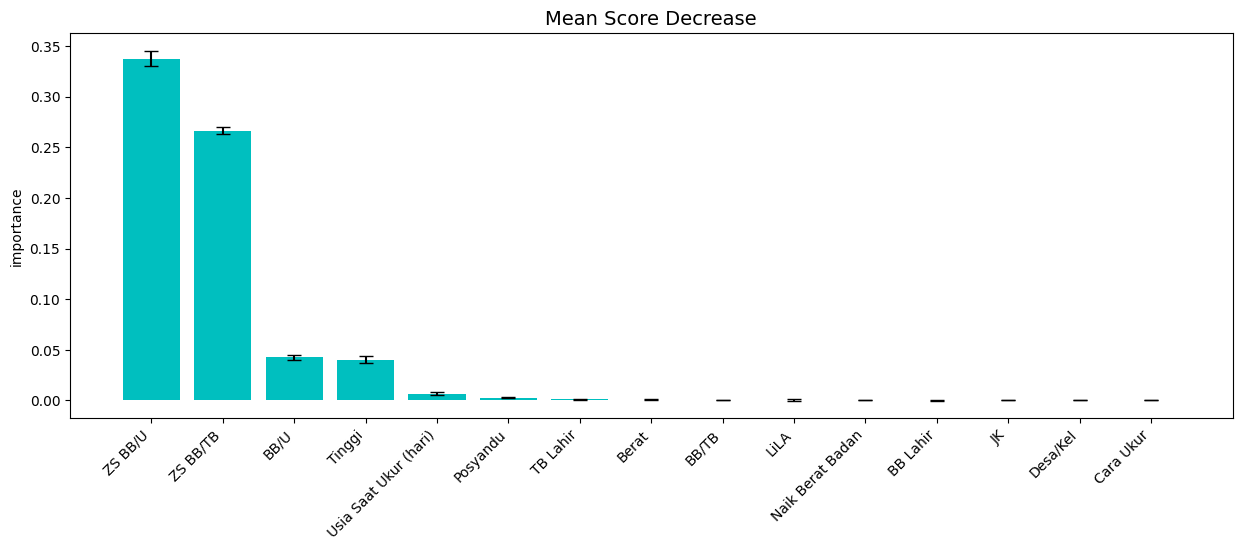

time: 7 s (started: 2025-10-28 15:01:29 +00:00)


In [154]:
mean_score_decrease(
    X_train,
    y_train_encoded,
    xgb_smote_model,
    plot=True,
    topk=None,
    n_fold=5,
    normalize=False,
    random_state=42,
)

## 11.2. XGBoost-SMOTE Eval

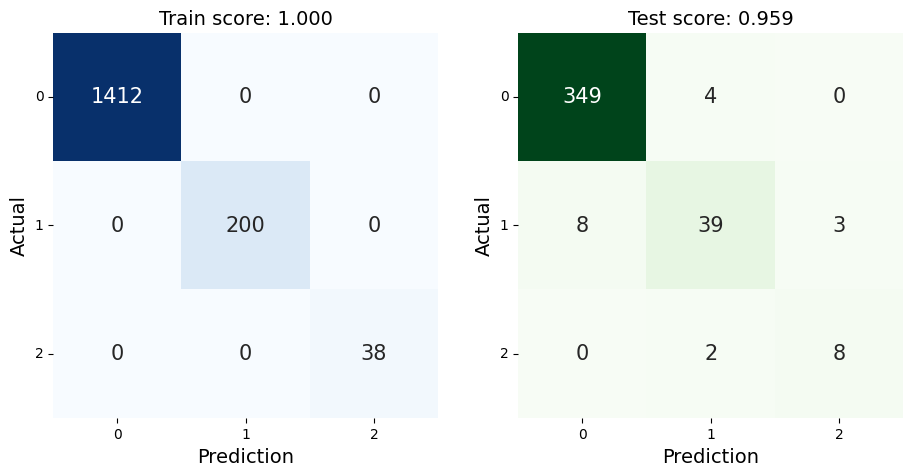

time: 515 ms (started: 2025-10-28 15:01:36 +00:00)


In [155]:
plot_confusion_matrix(X_train, y_train_encoded, X_test, y_test_encoded, xgb_smote_model)

Train report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1412
           1       1.00      1.00      1.00       200
           2       1.00      1.00      1.00        38

    accuracy                           1.00      1650
   macro avg       1.00      1.00      1.00      1650
weighted avg       1.00      1.00      1.00      1650


Test report
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       353
           1       0.84      0.74      0.79        50
           2       1.00      0.60      0.75        10

    accuracy                           0.95       413
   macro avg       0.94      0.78      0.84       413
weighted avg       0.95      0.95      0.95       413



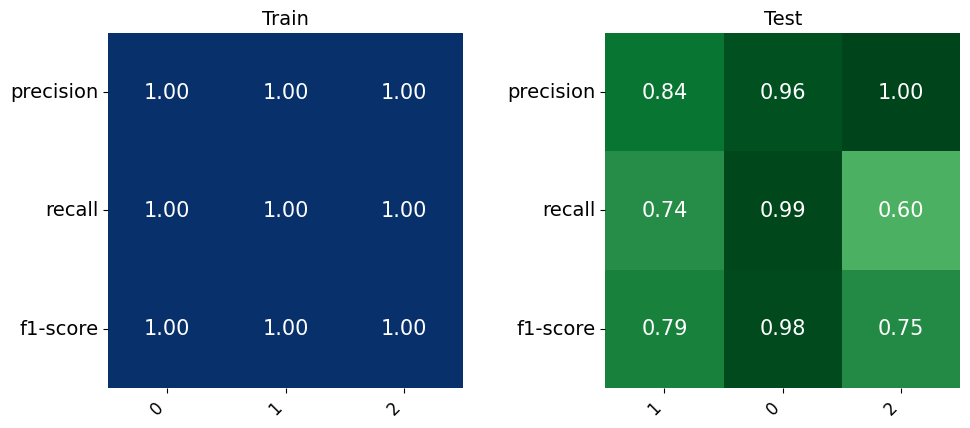

time: 530 ms (started: 2025-10-28 15:01:36 +00:00)


In [156]:
plot_classification_report(X_train, y_train_encoded, X_test, y_test_encoded, xgb_model, report=True, return_df=False)
_ = plot_classification_report(X_train, pd.DataFrame(y_train_encoded)[0], X_test, pd.DataFrame(y_test_encoded)[0], xgb_model, report=False, return_df=True)